<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [50]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-01-28 10:53:34.305211: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_3475876/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum   version  \
_id                                                                           
633c360f9d08c565cfa12311     db  e88212da6eb7e31a30a6fea422bc58dc     3.0.0   
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a    1.11.2   
...                         ...                               ...       ...   
63c506d9e2456d59975e1402     db  0b84d66ba1ce7e5f31566388cbd2c90e  23.01.04   
63ce4a72e83d1ee490f3f8fa     db  2e4c9a58124bd9e0397699de79fc6115  23.01.23   
63c506d5e2456d59975e1389     db  2628dbfa46813bc351104e1ebdc6d6a2  23.01.04   
5f016dee777d4b67a92d5840   file  4ea9485a7c529809ed110d0c77f2e16f     2.0.0   
5efe9280777d4b67a92d56ce   file  02a4101c17ceaa4b9d473f6840ac4d7a     2.0.0   

                                               export_date      len  \
_id                                                                   
633c360f9d08c565cfa12311  2022-12-10 06:23:46.684500+00:00   6730.0   
6340244c9d08c565cfa12341  2022-12-10 06:23:47.164630+00:00   6740.0   
6391b4771864c6df4d29f332        2023-01-28 04:29:41.374031   1990.0   
5ec2b8da665f7603e03b1255        2023-01-28 04:29:24.502369   5840.0   
5ded4e284ddc27bcf92dd6ce        2023-01-28 04:29:03.988134    460.0   
...                                                    ...      ...   
63c506d9e2456d59975e1402        2023-01-28 04:29:44.653774    810.0   
63ce4a72e83d1ee490f3f8fa        2023-01-28 04:30:36.086491    340.0   
63c506d5e2456d59975e1389        2023-01-28 04:29:44.636744   2170.0   
5f016dee777d4b67a92d5840        2023-01-28 04:29:20.514901     20.0   
5efe9280777d4b67a92d56ce        2023-01-28 04:29:19.964642  14020.0   

                                             analyze_date         value  \
_id                                                                       
633c360f9d08c565cfa12311 2022-10-04 16:33:37.333000+00:00  5.000000e+10   
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
...                                                   ...           ...   
63c506d9e2456d59975e1402 2023-01-16 11:21:57.571000+00:00           NaN   
63ce4a72e83d1ee490f3f8fa 2023-01-25 06:03:26.854000+00:00           NaN   
63c506d5e2456d59975e1389 2023-01-16 11:21:48.816000+00:00           NaN   
5f016dee777d4b67a92d5840 2020-07-05 14:13:31.165000+00:00           NaN   
5efe9280777d4b67a92d56ce 2020-07-03 21:47:22.279000+00:00           NaN   

                          value_log1p  value_span currency  ... valid  \
_id                                                         ...         
633c360f9d08c565cfa12311    24.635289       401.0      RUB  ...  True   
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...  True   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...  True   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...  True   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...  True   
...                               ...         ...      ...  ...   ...   
63c506d9e2456d59975e1402          NaN         NaN      NaN  ...  True   
63ce4a72e83d1ee490f3f8fa          NaN         NaN      NaN  ...  True   
63c506d5e2456d59975e1389          NaN         NaN      NaN  ...  True   
5f016dee777d4b67a92d5840          NaN         NaN      NaN  ...  True   
5efe9280777d4b67a92d56ce          NaN         NaN      NaN  ...  True   

                         documentType subj_len  \
_id                                              
633c360f9d08c565cfa12311    AGREEMENT      NaN 

In [17]:
print(len(stats))

2723


# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [18]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

len(stats)
get_feature_log_weights(stats, 'documentType')

CONTRACT                   0.644513
SUPPLEMENTARY_AGREEMENT    1.103771
AGREEMENT                  1.251716
Name: documentType, dtype: float64

In [19]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [20]:


subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

1.0
1.0
0.020707783669837578
0.14896298881161021
6.229902247483103
6.6219623593656305


Service                              0.121868
Deal                                 0.237383
Renting                              0.394919
Other                                0.416604
GeneralContract                      0.428858
Loans                                0.484872
AgencyContract                       0.594314
DealIntellectualProperty             0.678755
Charity                              0.782526
Insurance                            0.875119
RealEstate                           1.192077
RealEstateTransactions               2.122573
BankGuarantees                       2.626358
PledgeEncumbrance                    2.860646
ParticipationInOtherOrganizations    3.146083
SecuritiesTransactions               4.550688
Name: subject, dtype: float64

In [21]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [22]:
%%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

2723
CPU times: user 3.55 s, sys: 14.1 s, total: 17.7 s
Wall time: 49.1 s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [23]:
len(stats_valid)

2723

In [24]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0
1.0
1.0
0.14896298881161021


sample_weight
MIN	 0.020707783669837578
MEAN	 1.0


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


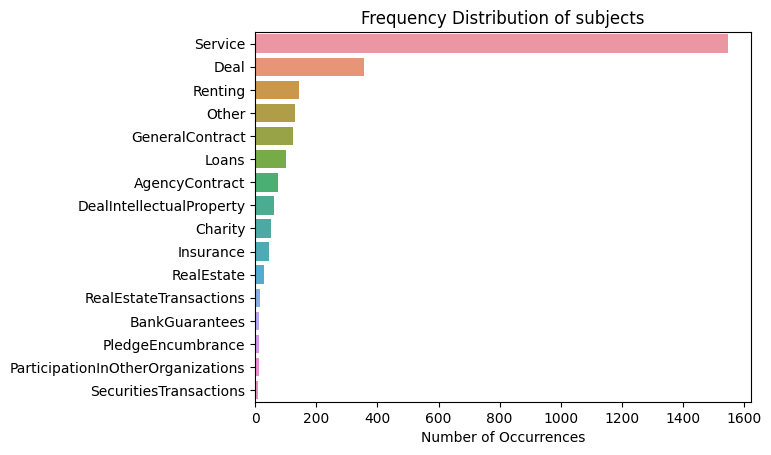


min 8
max 1546
total 2723


In [25]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [26]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Loans', 'BankGuarantees', 'Service', 'Charity', 'AgencyContract', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.495789
Deal                                 0.619180
Renting                              0.733673
Other                                0.746864
GeneralContract                      0.754116
Loans                                0.785614
AgencyContract                       0.840760
DealIntellectualProperty             0.878829
Charity                              0.921509
Insurance                            0.956509
RealEstate                           1.060315
RealEstateTransactions               1.285151
BankGuarantees                       1.379700
PledgeEncumbrance                    1.419563
ParticipationInOtherOrganizations    1.465289
SecuritiesTransactions               1.657139
Name: subject, dtype: float64

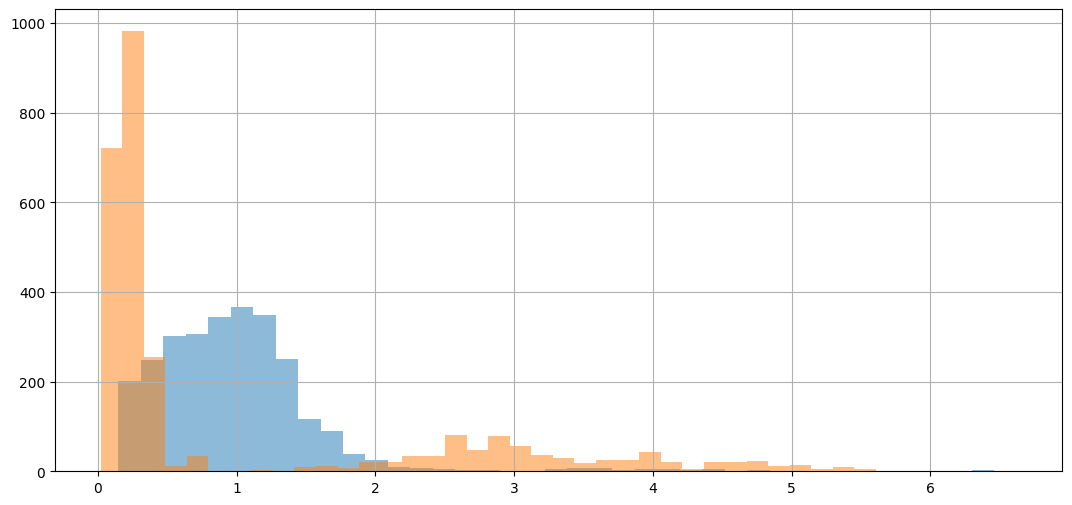

In [27]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

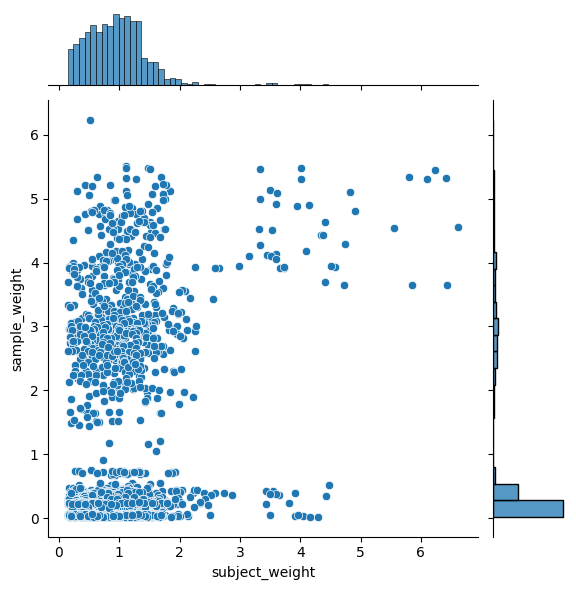

In [28]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


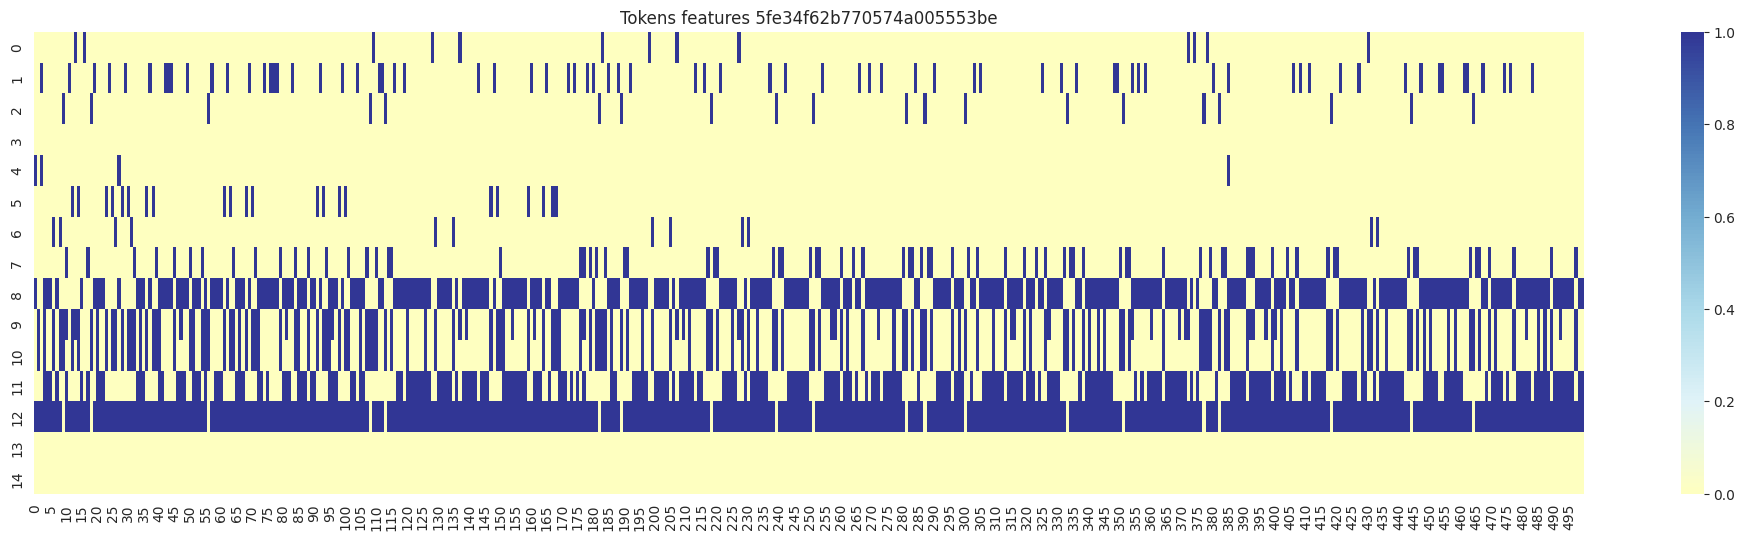

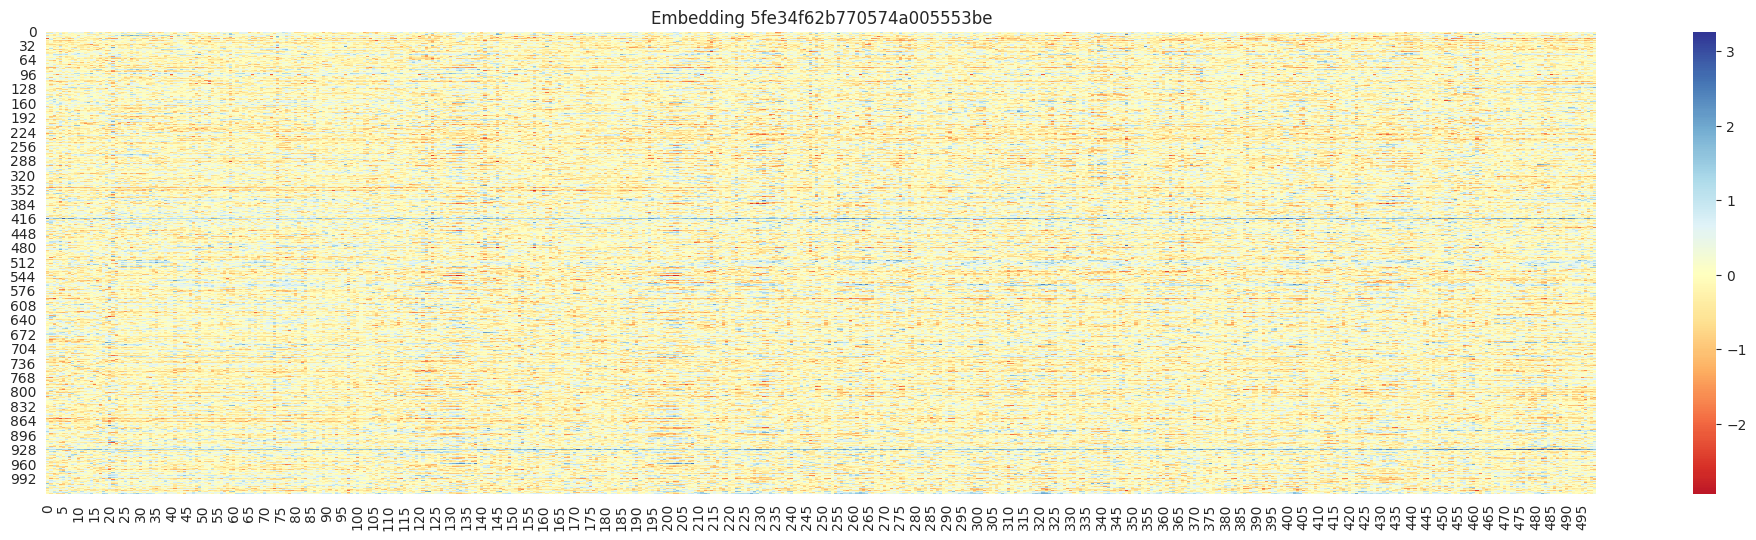

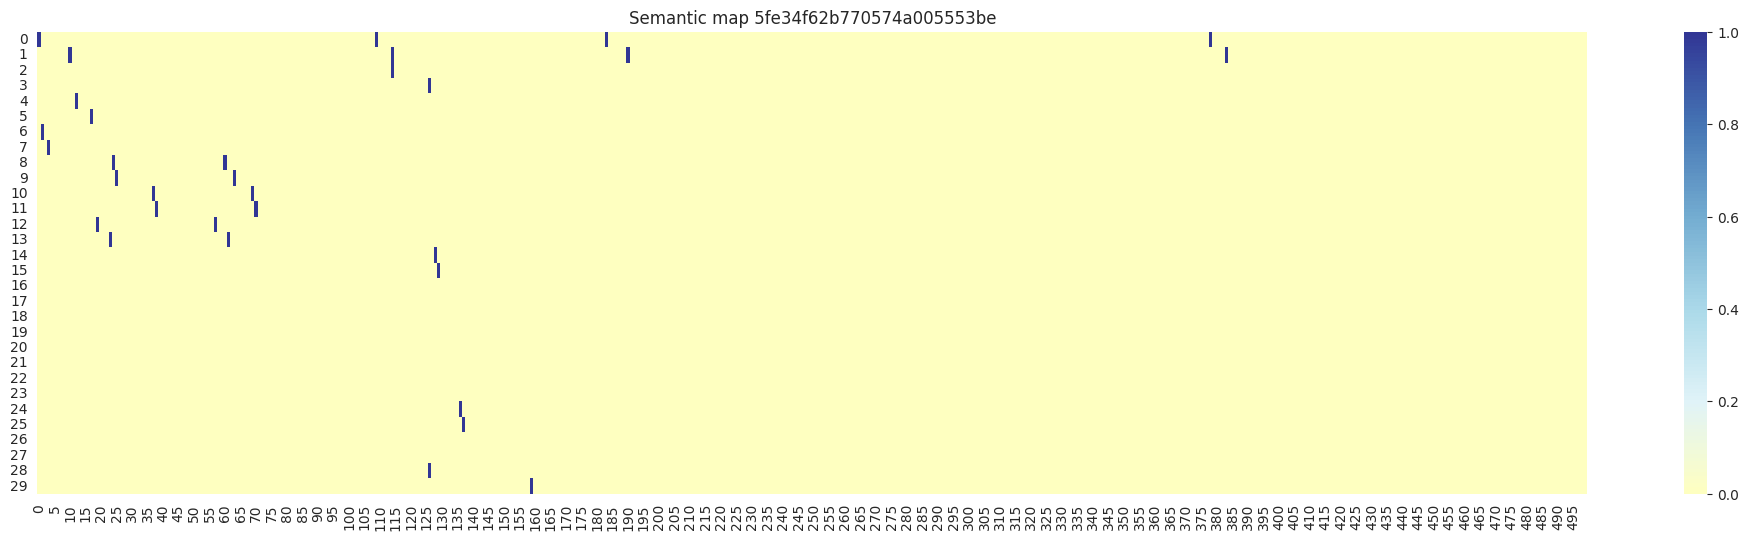

In [29]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 573, 30)


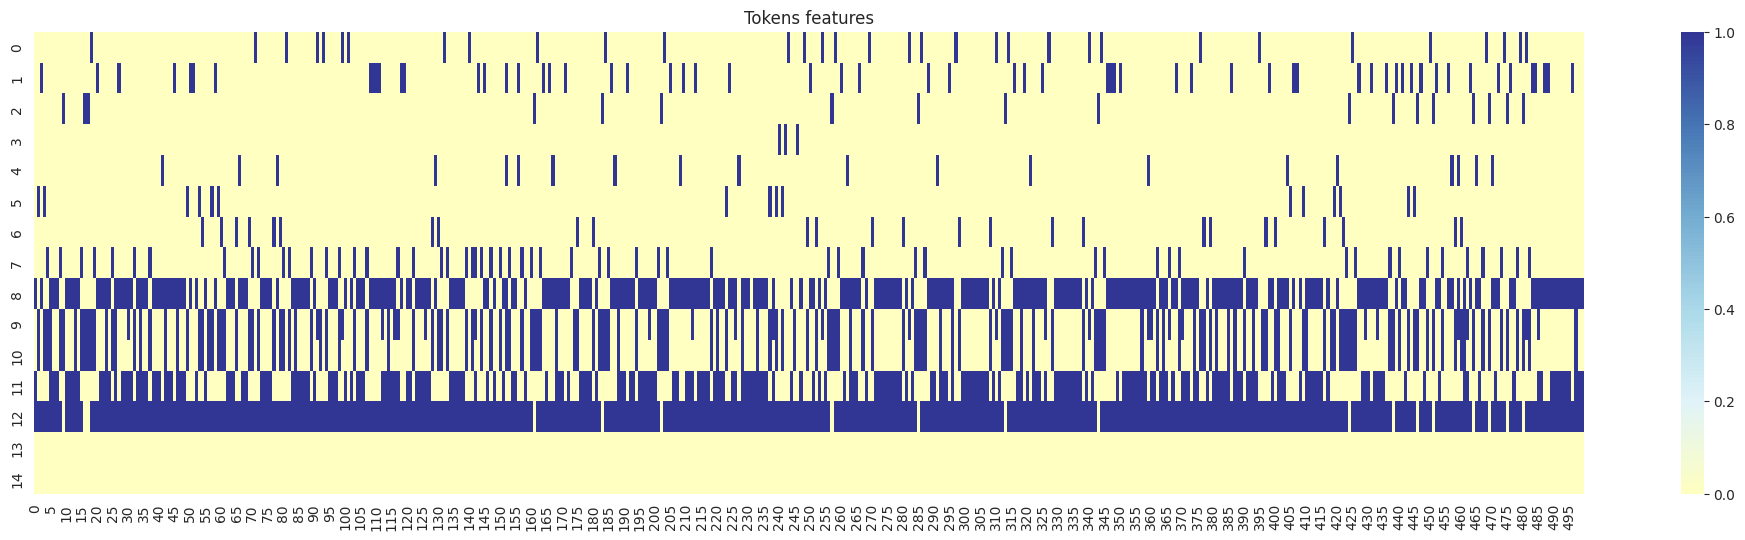

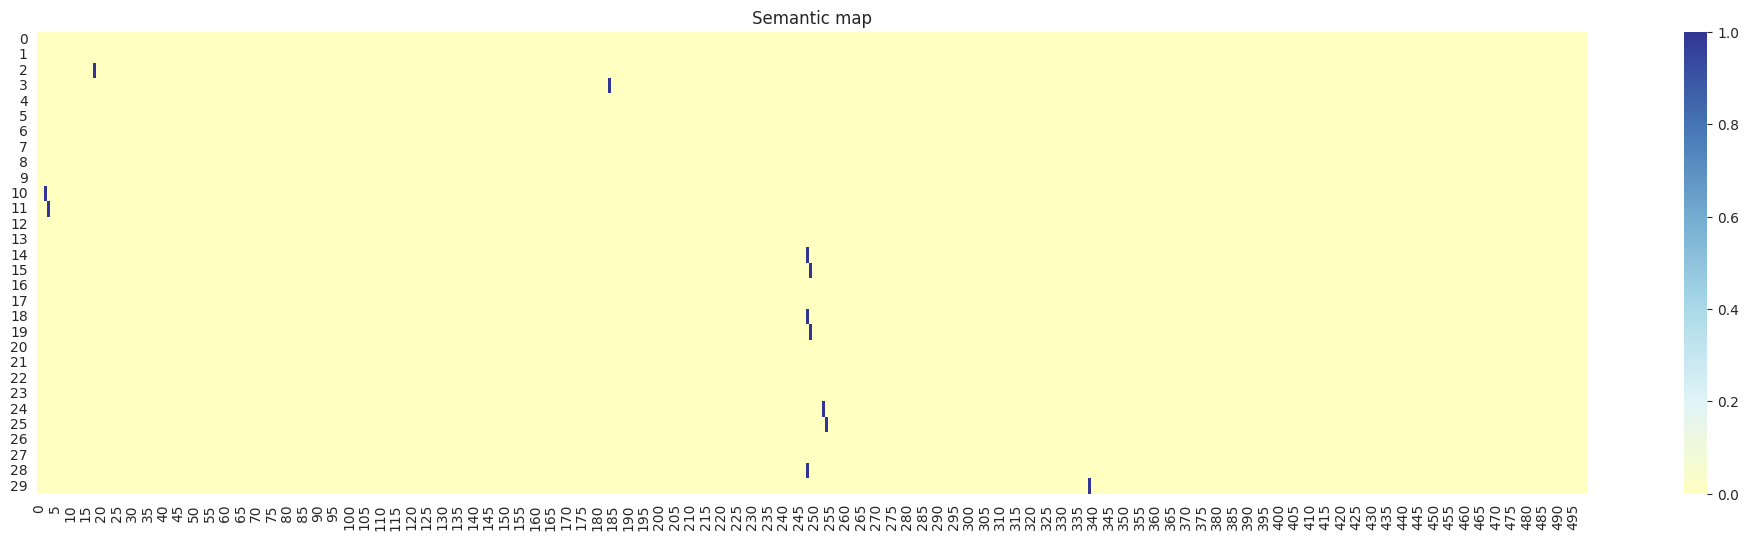

In [30]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [31]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

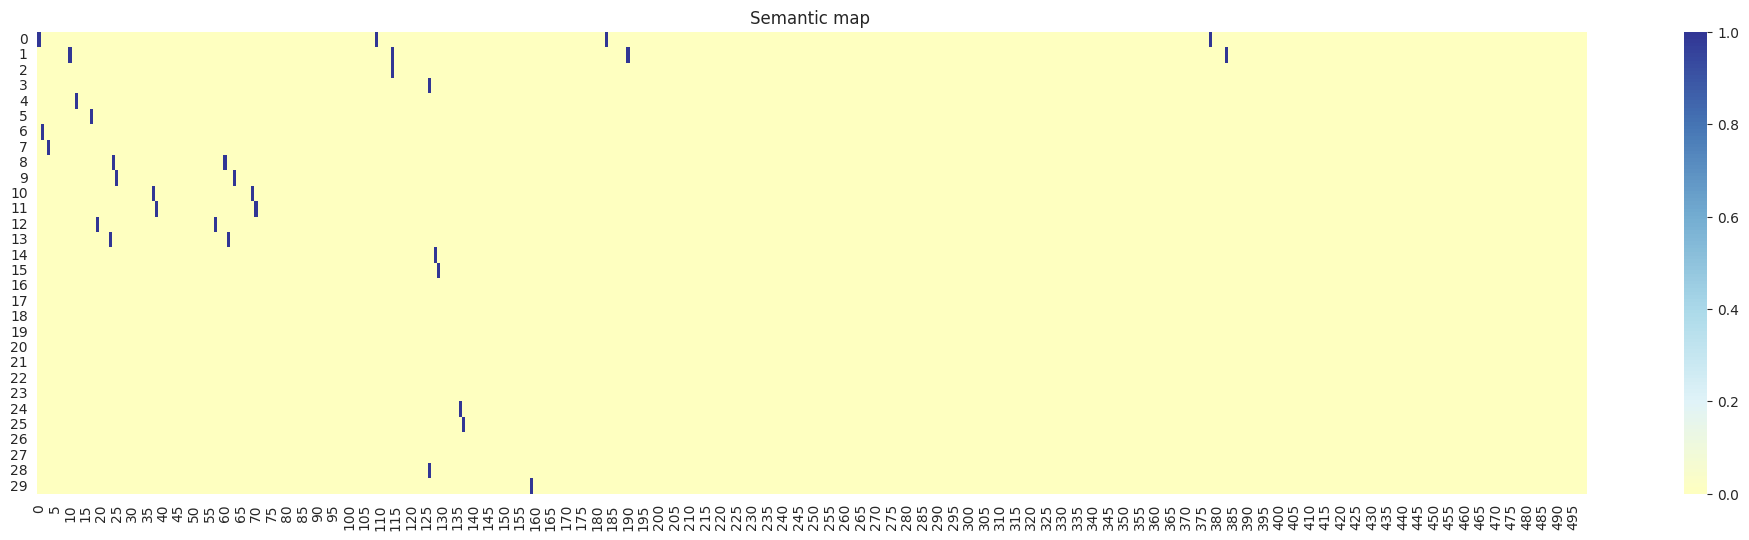

In [32]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 6294c0e7df54d406a99b167f
test_indices[0]: 5fe4821ab770574a00555654


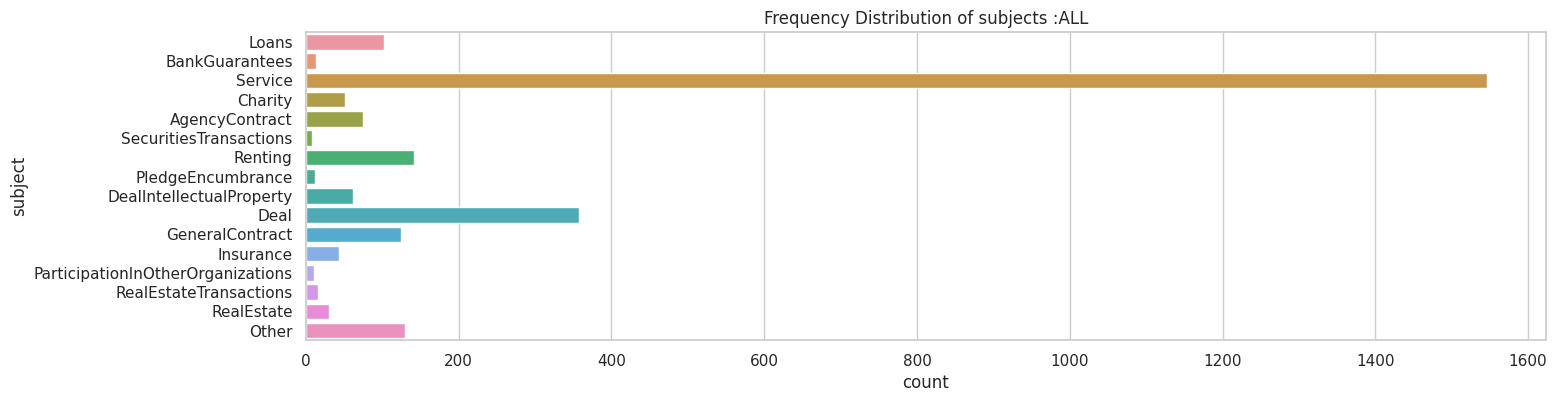

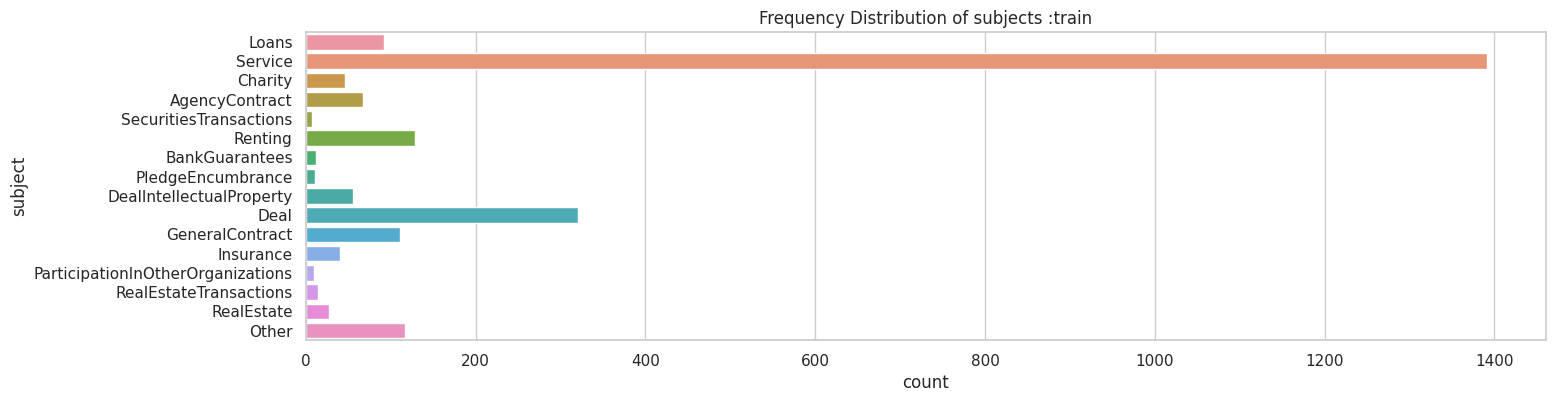

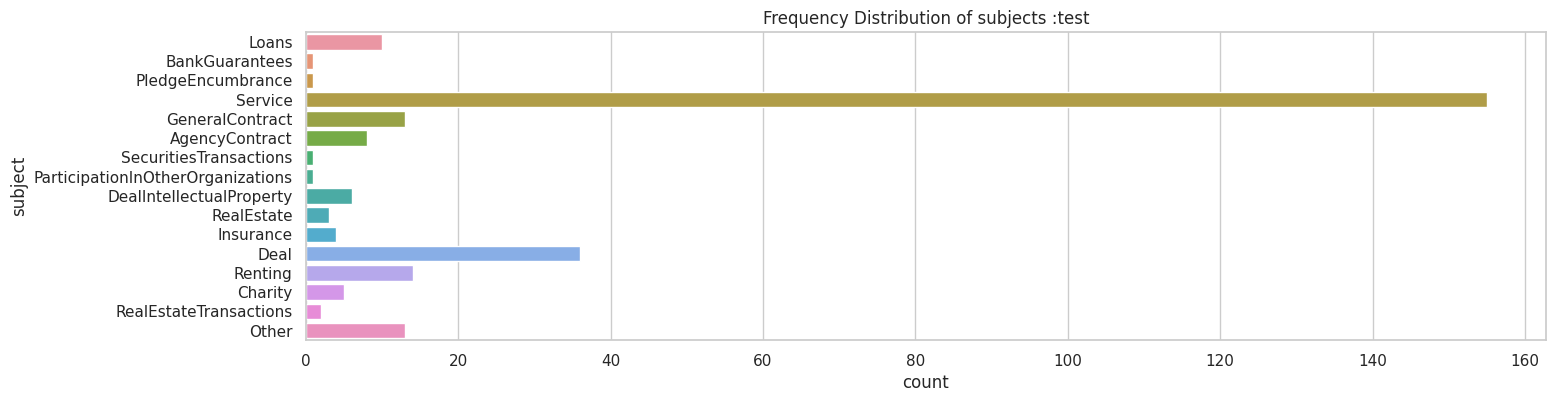

In [33]:
EPOCHS = 50
BATCH_SIZE = 128
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [34]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	128
train_samples:	9800
test_samples:	273
steps_per_epoch:	76
validation_steps:	38


# Models 🦖

In [35]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [36]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [37]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [38]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [39]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [40]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [41]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-01-28 10:54:40.953383: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-28 10:54:41.491728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 10:54:41.492386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-28 10:54:41.492402: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-28 10:54:41.492433: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-28 10:54:41.492449: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [42]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [43]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 12
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

2023-01-28 10:54:45.029698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-28 10:54:45.049938: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/24


2023-01-28 10:54:48.618394: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-01-28 10:54:49.993197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


2023-01-28 10:54:50.996550: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-28 10:54:50.996871: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2023-01-28 10:54:51.354734: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/76 [..............................] - ETA: 8:47 - loss: 0.0125 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0062 - O1_tagging_kullback_leibler_divergence: 0.1700 - O1_tagging_mse: 4.0897e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_kullback_leibler_divergence: 0.3567 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0145

 2/76 [..............................] - ETA: 25s - loss: 0.0149 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0082 - O1_tagging_kullback_leibler_divergence: 0.1771 - O1_tagging_mse: 4.2794e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.4138 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0159 

 3/76 [>.............................] - ETA: 41s - loss: 0.0171 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0089 - O1_tagging_kullback_leibler_divergence: 0.1920 - O1_tagging_mse: 4.6900e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.4479 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0171

 4/76 [>.............................] - ETA: 53s - loss: 0.0166 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0084 - O1_tagging_kullback_leibler_divergence: 0.1965 - O1_tagging_mse: 4.7852e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.4314 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0168

 5/76 [>.............................] - ETA: 1:09 - loss: 0.0170 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0085 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.9529e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4310 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0167

 6/76 [=>............................] - ETA: 1:19 - loss: 0.0178 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0091 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.9887e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4554 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

 7/76 [=>............................] - ETA: 1:25 - loss: 0.0175 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0087 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 5.0320e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4547 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0173

 8/76 [==>...........................] - ETA: 1:41 - loss: 0.0171 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0086 - O1_tagging_kullback_leibler_divergence: 0.2016 - O1_tagging_mse: 4.8938e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4336 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0167

 9/76 [==>...........................] - ETA: 1:37 - loss: 0.0176 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0088 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 5.0499e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4393 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0168

10/76 [==>...........................] - ETA: 1:40 - loss: 0.0182 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0094 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 5.0243e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4645 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0175

11/76 [===>..........................] - ETA: 1:36 - loss: 0.0190 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.1480e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0185

12/76 [===>..........................] - ETA: 1:37 - loss: 0.0186 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1804e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4956 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0183

13/76 [====>.........................] - ETA: 1:36 - loss: 0.0190 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2989e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5064 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0186

14/76 [====>.........................] - ETA: 1:38 - loss: 0.0192 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.3817e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0188

15/76 [====>.........................] - ETA: 1:44 - loss: 0.0192 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.2644e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5116 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0188

16/76 [=====>........................] - ETA: 1:41 - loss: 0.0195 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.3035e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0187

17/76 [=====>........................] - ETA: 1:40 - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.2601e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5237 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

18/76 [======>.......................] - ETA: 1:37 - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.3481e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5187 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

19/76 [======>.......................] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.4517e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

20/76 [======>.......................] - ETA: 1:32 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.5010e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5319 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0193

21/76 [=======>......................] - ETA: 1:30 - loss: 0.0211 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.5794e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

22/76 [=======>......................] - ETA: 1:28 - loss: 0.0209 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.6082e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

23/76 [========>.....................] - ETA: 1:28 - loss: 0.0208 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.5734e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0192

24/76 [========>.....................] - ETA: 1:27 - loss: 0.0207 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.5192e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

25/76 [========>.....................] - ETA: 1:25 - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.5000e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

26/76 [=========>....................] - ETA: 1:22 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.5718e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5289 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0192

27/76 [=========>....................] - ETA: 1:21 - loss: 0.0207 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.5408e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5216 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0190

28/76 [==========>...................] - ETA: 1:19 - loss: 0.0209 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.5761e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0192

29/76 [==========>...................] - ETA: 1:18 - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.5255e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

30/76 [==========>...................] - ETA: 1:15 - loss: 0.0207 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.5677e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

31/76 [===========>..................] - ETA: 1:13 - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.5606e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0192

32/76 [===========>..................] - ETA: 1:12 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.5453e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

33/76 [============>.................] - ETA: 1:09 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.5651e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5259 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

34/76 [============>.................] - ETA: 1:09 - loss: 0.0206 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.4830e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5255 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

35/76 [============>.................] - ETA: 1:07 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.5265e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5298 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

36/76 [=============>................] - ETA: 1:05 - loss: 0.0207 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.5623e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5291 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

37/76 [=============>................] - ETA: 1:03 - loss: 0.0207 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.5915e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5232 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

38/76 [==============>...............] - ETA: 1:02 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.5424e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

39/76 [==============>...............] - ETA: 1:00 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.5363e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5237 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

40/76 [==============>...............] - ETA: 59s - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.5132e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5218 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190 

41/76 [===============>..............] - ETA: 58s - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.4796e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5185 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

42/76 [===============>..............] - ETA: 56s - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.4934e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

43/76 [===============>..............] - ETA: 54s - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.4939e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5188 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

44/76 [================>.............] - ETA: 52s - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.4421e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5183 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

45/76 [================>.............] - ETA: 50s - loss: 0.0206 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.4743e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

46/76 [=================>............] - ETA: 49s - loss: 0.0206 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.4734e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5176 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

47/76 [=================>............] - ETA: 47s - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.4805e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5136 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

48/76 [=================>............] - ETA: 45s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.5013e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5128 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

49/76 [==================>...........] - ETA: 43s - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.5385e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5112 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

50/76 [==================>...........] - ETA: 42s - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.5689e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5117 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

51/76 [===================>..........] - ETA: 40s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.6004e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

52/76 [===================>..........] - ETA: 38s - loss: 0.0211 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.5994e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5094 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

53/76 [===================>..........] - ETA: 37s - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.5744e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5078 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

54/76 [====================>.........] - ETA: 35s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.5819e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5065 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

55/76 [====================>.........] - ETA: 34s - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.5795e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5055 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

56/76 [=====================>........] - ETA: 32s - loss: 0.0210 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.5889e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

57/76 [=====================>........] - ETA: 30s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.5936e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5073 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

58/76 [=====================>........] - ETA: 29s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.5648e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5058 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

59/76 [======================>.......] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.5939e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5076 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

60/76 [======================>.......] - ETA: 26s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2276 - O1_tagging_mse: 5.6099e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5087 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

61/76 [=======================>......] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.5745e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5080 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

62/76 [=======================>......] - ETA: 23s - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.5829e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

63/76 [=======================>......] - ETA: 21s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.5734e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

64/76 [========================>.....] - ETA: 19s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.5991e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5080 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

65/76 [========================>.....] - ETA: 18s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.5830e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5063 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

66/76 [=========================>....] - ETA: 16s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.5952e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5107 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

67/76 [=========================>....] - ETA: 14s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.5784e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

68/76 [=========================>....] - ETA: 13s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.5741e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5109 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

69/76 [==========================>...] - ETA: 11s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 5.5958e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5112 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

70/76 [==========================>...] - ETA: 9s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.6147e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5118 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189 

71/76 [===========================>..] - ETA: 8s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.6136e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5095 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

72/76 [===========================>..] - ETA: 6s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.6197e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5077 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

73/76 [===========================>..] - ETA: 5s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.6444e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

74/76 [============================>.] - ETA: 3s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 5.6095e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5119 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

75/76 [============================>.] - ETA: 1s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2285 - O1_tagging_mse: 5.6334e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.6257e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5078 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

76/76 [==============================] - 236s 3s/step - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.6257e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5078 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188 - val_loss: 0.0201 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0129 - val_O1_tagging_kullback_leibler_divergence: 0.1816 - val_O1_tagging_mse: 4.0456e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_kullback_leibler_divergence: 0.2371 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0091



Epoch 00001: val_loss improved from inf to 0.02011, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/24


 1/76 [..............................] - ETA: 32s - loss: 0.0213 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 4.5840e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6852 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0235

 2/76 [..............................] - ETA: 2:06 - loss: 0.0193 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 4.9856e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6593 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0224

 3/76 [>.............................] - ETA: 2:31 - loss: 0.0194 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2068 - O1_tagging_mse: 4.8643e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5850 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0207

 4/76 [>.............................] - ETA: 2:25 - loss: 0.0192 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2019 - O1_tagging_mse: 4.7747e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5560 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

 5/76 [>.............................] - ETA: 2:25 - loss: 0.0202 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.1970 - O1_tagging_mse: 4.6394e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5534 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

 6/76 [=>............................] - ETA: 2:18 - loss: 0.0194 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.1988 - O1_tagging_mse: 4.6805e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

 7/76 [=>............................] - ETA: 2:16 - loss: 0.0193 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2015 - O1_tagging_mse: 4.7874e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5336 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

 8/76 [==>...........................] - ETA: 2:19 - loss: 0.0195 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1976 - O1_tagging_mse: 4.7119e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5304 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

 9/76 [==>...........................] - ETA: 2:12 - loss: 0.0197 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2029 - O1_tagging_mse: 4.8604e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5343 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

10/76 [==>...........................] - ETA: 2:10 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 5.0213e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5559 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

11/76 [===>..........................] - ETA: 2:18 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9818e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5299 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

12/76 [===>..........................] - ETA: 2:19 - loss: 0.0198 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8972e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5219 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

13/76 [====>.........................] - ETA: 2:14 - loss: 0.0202 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 4.9420e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5236 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

14/76 [====>.........................] - ETA: 2:15 - loss: 0.0200 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 4.8557e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5088 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

15/76 [====>.........................] - ETA: 2:15 - loss: 0.0201 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 4.7967e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5011 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

16/76 [=====>........................] - ETA: 2:14 - loss: 0.0201 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 4.7629e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4902 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

17/76 [=====>........................] - ETA: 2:09 - loss: 0.0201 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 4.8298e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4983 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

18/76 [======>.......................] - ETA: 2:08 - loss: 0.0198 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2007 - O1_tagging_mse: 4.7631e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4921 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

19/76 [======>.......................] - ETA: 2:05 - loss: 0.0200 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2000 - O1_tagging_mse: 4.7473e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5022 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

20/76 [======>.......................] - ETA: 2:01 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 4.7998e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5146 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

21/76 [=======>......................] - ETA: 2:00 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2018 - O1_tagging_mse: 4.8026e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5055 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

22/76 [=======>......................] - ETA: 1:57 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2028 - O1_tagging_mse: 4.8359e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

23/76 [========>.....................] - ETA: 1:55 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.8554e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5116 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

24/76 [========>.....................] - ETA: 1:53 - loss: 0.0203 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2022 - O1_tagging_mse: 4.8235e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

25/76 [========>.....................] - ETA: 1:50 - loss: 0.0203 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2026 - O1_tagging_mse: 4.8479e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5019 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

26/76 [=========>....................] - ETA: 1:47 - loss: 0.0202 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.9094e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5005 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

27/76 [=========>....................] - ETA: 1:46 - loss: 0.0200 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.9232e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4958 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

28/76 [==========>...................] - ETA: 1:44 - loss: 0.0201 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 4.9076e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5009 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

29/76 [==========>...................] - ETA: 1:44 - loss: 0.0200 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 4.8976e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

30/76 [==========>...................] - ETA: 1:42 - loss: 0.0200 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2050 - O1_tagging_mse: 4.9108e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5071 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

31/76 [===========>..................] - ETA: 1:40 - loss: 0.0201 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.9067e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

32/76 [===========>..................] - ETA: 1:38 - loss: 0.0200 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 4.9168e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5079 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

33/76 [============>.................] - ETA: 1:35 - loss: 0.0199 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 4.9151e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

34/76 [============>.................] - ETA: 1:33 - loss: 0.0198 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.9011e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5003 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

35/76 [============>.................] - ETA: 1:31 - loss: 0.0199 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.9195e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

36/76 [=============>................] - ETA: 1:29 - loss: 0.0199 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.9235e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5025 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

37/76 [=============>................] - ETA: 1:26 - loss: 0.0199 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 4.9506e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5053 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

38/76 [==============>...............] - ETA: 1:23 - loss: 0.0198 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.9772e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5011 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

39/76 [==============>...............] - ETA: 1:22 - loss: 0.0199 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9610e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5091 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

40/76 [==============>...............] - ETA: 1:19 - loss: 0.0201 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9946e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5058 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

41/76 [===============>..............] - ETA: 1:17 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.0135e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5011 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

42/76 [===============>..............] - ETA: 1:15 - loss: 0.0202 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2088 - O1_tagging_mse: 4.9993e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5018 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

43/76 [===============>..............] - ETA: 1:13 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0335e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5024 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

44/76 [================>.............] - ETA: 1:10 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0513e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5038 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

45/76 [================>.............] - ETA: 1:08 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0741e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

46/76 [=================>............] - ETA: 1:06 - loss: 0.0202 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0397e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

47/76 [=================>............] - ETA: 1:05 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.0173e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5022 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

48/76 [=================>............] - ETA: 1:02 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0395e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4995 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

49/76 [==================>...........] - ETA: 1:00 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.0234e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4982 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

50/76 [==================>...........] - ETA: 58s - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0529e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5001 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185 

51/76 [===================>..........] - ETA: 55s - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0840e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5066 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

52/76 [===================>..........] - ETA: 53s - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1046e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

53/76 [===================>..........] - ETA: 51s - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0891e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

54/76 [====================>.........] - ETA: 49s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0866e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5072 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

55/76 [====================>.........] - ETA: 46s - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1067e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5073 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

56/76 [=====================>........] - ETA: 44s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1033e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

57/76 [=====================>........] - ETA: 42s - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0779e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5041 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

58/76 [=====================>........] - ETA: 40s - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0650e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5053 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

59/76 [======================>.......] - ETA: 38s - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0513e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5062 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

60/76 [======================>.......] - ETA: 36s - loss: 0.0205 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0649e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5066 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

61/76 [=======================>......] - ETA: 33s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0697e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5075 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

62/76 [=======================>......] - ETA: 31s - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0731e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

63/76 [=======================>......] - ETA: 29s - loss: 0.0207 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0650e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5113 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

64/76 [========================>.....] - ETA: 27s - loss: 0.0207 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0626e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5128 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

65/76 [========================>.....] - ETA: 24s - loss: 0.0207 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0383e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5105 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

66/76 [=========================>....] - ETA: 22s - loss: 0.0208 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0629e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

67/76 [=========================>....] - ETA: 20s - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0873e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5175 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

68/76 [=========================>....] - ETA: 18s - loss: 0.0209 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0655e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5161 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

69/76 [==========================>...] - ETA: 15s - loss: 0.0211 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0903e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5197 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

70/76 [==========================>...] - ETA: 13s - loss: 0.0211 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0755e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

71/76 [===========================>..] - ETA: 11s - loss: 0.0212 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0983e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

72/76 [===========================>..] - ETA: 8s - loss: 0.0212 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1089e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191 

73/76 [===========================>..] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1096e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

74/76 [============================>.] - ETA: 4s - loss: 0.0211 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1031e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5244 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

75/76 [============================>.] - ETA: 2s - loss: 0.0211 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1190e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5237 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

76/76 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1355e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

76/76 [==============================] - 268s 4s/step - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1355e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191 - val_loss: 0.0205 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0130 - val_O1_tagging_kullback_leibler_divergence: 0.1859 - val_O1_tagging_mse: 4.0749e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2335 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0093



Epoch 00002: val_loss did not improve from 0.02011
Epoch 3/24


 1/76 [..............................] - ETA: 34s - loss: 0.0237 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 4.8373e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.3642 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0137

 2/76 [..............................] - ETA: 2:57 - loss: 0.0228 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.1900 - O1_tagging_mse: 4.5741e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.4945 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0177

 3/76 [>.............................] - ETA: 2:26 - loss: 0.0232 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2034 - O1_tagging_mse: 4.9014e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5489 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 4/76 [>.............................] - ETA: 2:36 - loss: 0.0215 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.1973 - O1_tagging_mse: 4.7457e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5542 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

 5/76 [>.............................] - ETA: 2:20 - loss: 0.0216 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.9617e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

 6/76 [=>............................] - ETA: 2:22 - loss: 0.0218 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 4.9422e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

 7/76 [=>............................] - ETA: 2:18 - loss: 0.0217 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 4.9809e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5075 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 8/76 [==>...........................] - ETA: 2:18 - loss: 0.0210 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 4.9676e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4867 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 9/76 [==>...........................] - ETA: 2:21 - loss: 0.0199 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1983 - O1_tagging_mse: 4.8088e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.4622 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

10/76 [==>...........................] - ETA: 2:16 - loss: 0.0197 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.1994 - O1_tagging_mse: 4.8370e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4667 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

11/76 [===>..........................] - ETA: 2:13 - loss: 0.0193 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2017 - O1_tagging_mse: 4.9011e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4581 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

12/76 [===>..........................] - ETA: 2:12 - loss: 0.0191 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.1998 - O1_tagging_mse: 4.8369e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4551 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0175

13/76 [====>.........................] - ETA: 2:12 - loss: 0.0193 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.1998 - O1_tagging_mse: 4.8238e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4410 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0171

14/76 [====>.........................] - ETA: 2:07 - loss: 0.0197 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.9396e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4491 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

15/76 [====>.........................] - ETA: 2:05 - loss: 0.0196 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2038 - O1_tagging_mse: 4.9457e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4481 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

16/76 [=====>........................] - ETA: 2:02 - loss: 0.0197 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.9692e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4620 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

17/76 [=====>........................] - ETA: 1:57 - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 5.0542e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4769 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

18/76 [======>.......................] - ETA: 1:55 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.1394e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4851 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

19/76 [======>.......................] - ETA: 2:06 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.1229e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4883 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

20/76 [======>.......................] - ETA: 2:08 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.1378e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5001 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

21/76 [=======>......................] - ETA: 2:06 - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.1444e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4963 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

22/76 [=======>......................] - ETA: 2:05 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.0748e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4998 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

23/76 [========>.....................] - ETA: 2:03 - loss: 0.0201 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 4.9930e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4946 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

24/76 [========>.....................] - ETA: 1:59 - loss: 0.0201 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 5.0054e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

25/76 [========>.....................] - ETA: 1:56 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 5.0627e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4954 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

26/76 [=========>....................] - ETA: 1:53 - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.1042e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5054 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

27/76 [=========>....................] - ETA: 1:53 - loss: 0.0205 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 5.0549e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

28/76 [==========>...................] - ETA: 1:49 - loss: 0.0207 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 5.0404e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5194 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

29/76 [==========>...................] - ETA: 1:46 - loss: 0.0208 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.0935e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5184 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

30/76 [==========>...................] - ETA: 1:44 - loss: 0.0208 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.1043e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

31/76 [===========>..................] - ETA: 1:41 - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.1312e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5219 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

32/76 [===========>..................] - ETA: 1:41 - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0924e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5227 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

33/76 [============>.................] - ETA: 1:41 - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0836e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5195 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

34/76 [============>.................] - ETA: 1:37 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.1081e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5175 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

35/76 [============>.................] - ETA: 1:34 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1524e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5144 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

36/76 [=============>................] - ETA: 1:31 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.1320e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

37/76 [=============>................] - ETA: 1:28 - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1730e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

38/76 [==============>...............] - ETA: 1:26 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1856e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

39/76 [==============>...............] - ETA: 1:24 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1545e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5136 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

40/76 [==============>...............] - ETA: 1:21 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1933e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5152 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

41/76 [===============>..............] - ETA: 1:20 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1617e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5138 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

42/76 [===============>..............] - ETA: 1:18 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1401e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5139 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

43/76 [===============>..............] - ETA: 1:15 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.1343e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

44/76 [================>.............] - ETA: 1:12 - loss: 0.0207 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.1063e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5182 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

45/76 [================>.............] - ETA: 1:10 - loss: 0.0208 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.1201e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5198 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

46/76 [=================>............] - ETA: 1:07 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.1238e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

47/76 [=================>............] - ETA: 1:04 - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1548e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

48/76 [=================>............] - ETA: 1:03 - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1362e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5248 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

49/76 [==================>...........] - ETA: 1:01 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.1067e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5214 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

50/76 [==================>...........] - ETA: 58s - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1421e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193 

51/76 [===================>..........] - ETA: 56s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1296e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

52/76 [===================>..........] - ETA: 54s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1411e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5218 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

53/76 [===================>..........] - ETA: 51s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1415e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5200 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

54/76 [====================>.........] - ETA: 49s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1251e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5192 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

55/76 [====================>.........] - ETA: 47s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1518e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

56/76 [=====================>........] - ETA: 45s - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1349e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5228 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

57/76 [=====================>........] - ETA: 42s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1645e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5236 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

58/76 [=====================>........] - ETA: 40s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1665e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

59/76 [======================>.......] - ETA: 38s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1458e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5208 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

60/76 [======================>.......] - ETA: 35s - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1704e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5286 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

61/76 [=======================>......] - ETA: 33s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1642e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

62/76 [=======================>......] - ETA: 31s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1448e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

63/76 [=======================>......] - ETA: 29s - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.1133e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

64/76 [========================>.....] - ETA: 26s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1273e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5227 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

65/76 [========================>.....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1388e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

66/76 [=========================>....] - ETA: 22s - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1505e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

67/76 [=========================>....] - ETA: 19s - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1310e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5242 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

68/76 [=========================>....] - ETA: 17s - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1288e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5235 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

69/76 [==========================>...] - ETA: 15s - loss: 0.0216 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1472e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5254 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

70/76 [==========================>...] - ETA: 13s - loss: 0.0215 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1335e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5255 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

71/76 [===========================>..] - ETA: 10s - loss: 0.0216 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1329e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5246 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

72/76 [===========================>..] - ETA: 8s - loss: 0.0215 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1177e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5266 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193 

73/76 [===========================>..] - ETA: 6s - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0966e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

74/76 [============================>.] - ETA: 4s - loss: 0.0215 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1173e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

75/76 [============================>.] - ETA: 2s - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1047e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

76/76 [==============================] - ETA: 0s - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0992e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

76/76 [==============================] - 260s 3s/step - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0992e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192 - val_loss: 0.0215 - val_O1_tagging_loss: 0.0079 - val_O2_subject_loss: 0.0136 - val_O1_tagging_kullback_leibler_divergence: 0.1868 - val_O1_tagging_mse: 4.0589e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_kullback_leibler_divergence: 0.2520 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0097



Epoch 00003: val_loss did not improve from 0.02011
Epoch 4/24


 1/76 [..............................] - ETA: 15s - loss: 0.0147 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0069 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1893e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5945 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0198

 2/76 [..............................] - ETA: 2:49 - loss: 0.0175 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0610e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5667 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0191

 3/76 [>.............................] - ETA: 2:16 - loss: 0.0190 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2358 - O1_tagging_mse: 5.7134e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5841 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0202

 4/76 [>.............................] - ETA: 2:14 - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2444 - O1_tagging_mse: 5.9485e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5616 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0198

 5/76 [>.............................] - ETA: 2:30 - loss: 0.0197 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.3131e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5160 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0189

 6/76 [=>............................] - ETA: 2:37 - loss: 0.0191 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.9841e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5039 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 7/76 [=>............................] - ETA: 2:24 - loss: 0.0198 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0904e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5437 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

 8/76 [==>...........................] - ETA: 2:18 - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.3079e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

 9/76 [==>...........................] - ETA: 2:14 - loss: 0.0195 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3785e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4854 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

10/76 [==>...........................] - ETA: 2:12 - loss: 0.0195 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2741e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

11/76 [===>..........................] - ETA: 2:10 - loss: 0.0197 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.2014e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5024 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

12/76 [===>..........................] - ETA: 2:07 - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2826e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5041 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

13/76 [====>.........................] - ETA: 2:04 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.3137e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4948 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

14/76 [====>.........................] - ETA: 2:00 - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2958e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5130 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

15/76 [====>.........................] - ETA: 2:02 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.2097e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

16/76 [=====>........................] - ETA: 1:57 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2526e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5010 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

17/76 [=====>........................] - ETA: 1:55 - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2363e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

18/76 [======>.......................] - ETA: 1:54 - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1633e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5043 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

19/76 [======>.......................] - ETA: 1:52 - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1844e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4959 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

20/76 [======>.......................] - ETA: 1:48 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2550e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4892 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

21/76 [=======>......................] - ETA: 1:48 - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.3188e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4880 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

22/76 [=======>......................] - ETA: 1:48 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2452e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4833 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

23/76 [========>.....................] - ETA: 1:47 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2358e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4911 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

24/76 [========>.....................] - ETA: 1:43 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.3129e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4967 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

25/76 [========>.....................] - ETA: 1:43 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2333e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4986 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

26/76 [=========>....................] - ETA: 1:40 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1737e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

27/76 [=========>....................] - ETA: 1:39 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1083e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4949 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

28/76 [==========>...................] - ETA: 1:36 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1009e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4874 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

29/76 [==========>...................] - ETA: 1:35 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0621e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4869 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

30/76 [==========>...................] - ETA: 1:33 - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0574e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4800 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

31/76 [===========>..................] - ETA: 1:32 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.0071e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4783 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

32/76 [===========>..................] - ETA: 1:30 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.0177e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4741 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

33/76 [============>.................] - ETA: 1:27 - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0534e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4761 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

34/76 [============>.................] - ETA: 1:26 - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0922e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4731 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

35/76 [============>.................] - ETA: 1:24 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0887e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4743 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

36/76 [=============>................] - ETA: 1:21 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1325e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4779 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

37/76 [=============>................] - ETA: 1:20 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1571e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

38/76 [==============>...............] - ETA: 1:18 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1445e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4847 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

39/76 [==============>...............] - ETA: 1:16 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1692e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4855 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

40/76 [==============>...............] - ETA: 1:14 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1766e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4837 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

41/76 [===============>..............] - ETA: 1:12 - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1866e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4866 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

42/76 [===============>..............] - ETA: 1:10 - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1735e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4893 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

43/76 [===============>..............] - ETA: 1:08 - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1971e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4951 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

44/76 [================>.............] - ETA: 1:06 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1544e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4932 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

45/76 [================>.............] - ETA: 1:04 - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1424e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4917 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

46/76 [=================>............] - ETA: 1:01 - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1356e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4936 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

47/76 [=================>............] - ETA: 59s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1356e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4948 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183 

48/76 [=================>............] - ETA: 57s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1079e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4966 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

49/76 [==================>...........] - ETA: 55s - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1121e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5012 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

50/76 [==================>...........] - ETA: 53s - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0998e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4997 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

51/76 [===================>..........] - ETA: 51s - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0731e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5004 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

52/76 [===================>..........] - ETA: 49s - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0485e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5006 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

53/76 [===================>..........] - ETA: 47s - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0687e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

54/76 [====================>.........] - ETA: 45s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1002e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5062 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

55/76 [====================>.........] - ETA: 43s - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1017e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5065 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

56/76 [=====================>........] - ETA: 41s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0991e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5060 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

57/76 [=====================>........] - ETA: 38s - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1290e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5113 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

58/76 [=====================>........] - ETA: 37s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1061e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

59/76 [======================>.......] - ETA: 34s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0885e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5080 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

60/76 [======================>.......] - ETA: 32s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0943e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5066 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

61/76 [=======================>......] - ETA: 30s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1060e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

62/76 [=======================>......] - ETA: 28s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1269e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

63/76 [=======================>......] - ETA: 26s - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1443e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

64/76 [========================>.....] - ETA: 24s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1579e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

65/76 [========================>.....] - ETA: 22s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1536e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

66/76 [=========================>....] - ETA: 20s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1805e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

67/76 [=========================>....] - ETA: 18s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1527e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

68/76 [=========================>....] - ETA: 16s - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1528e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5145 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

69/76 [==========================>...] - ETA: 14s - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1770e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5157 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

70/76 [==========================>...] - ETA: 12s - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1658e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5127 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

71/76 [===========================>..] - ETA: 10s - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1793e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5131 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

72/76 [===========================>..] - ETA: 8s - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1980e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188 

73/76 [===========================>..] - ETA: 6s - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1977e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5105 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

74/76 [============================>.] - ETA: 4s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1952e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5104 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

75/76 [============================>.] - ETA: 2s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1956e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - ETA: 0s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2020e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - 247s 3s/step - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2020e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186 - val_loss: 0.0206 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0133 - val_O1_tagging_kullback_leibler_divergence: 0.1831 - val_O1_tagging_mse: 4.0406e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2410 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0095



Epoch 00004: val_loss did not improve from 0.02011
Epoch 5/24


 1/76 [..............................] - ETA: 32s - loss: 0.0169 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0086 - O1_tagging_kullback_leibler_divergence: 0.1922 - O1_tagging_mse: 4.6728e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_kullback_leibler_divergence: 0.4061 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0148

 2/76 [..............................] - ETA: 1:58 - loss: 0.0187 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 5.0706e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5528 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0193

 3/76 [>.............................] - ETA: 2:20 - loss: 0.0188 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 5.0391e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0182

 4/76 [>.............................] - ETA: 2:43 - loss: 0.0192 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.1985 - O1_tagging_mse: 4.7731e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5227 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0186

 5/76 [>.............................] - ETA: 2:25 - loss: 0.0192 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.0766e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0190

 6/76 [=>............................] - ETA: 2:16 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.3473e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5428 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0195

 7/76 [=>............................] - ETA: 2:17 - loss: 0.0205 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2516e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5195 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

 8/76 [==>...........................] - ETA: 2:16 - loss: 0.0205 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1189e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0187

 9/76 [==>...........................] - ETA: 2:09 - loss: 0.0206 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1786e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4906 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0183

10/76 [==>...........................] - ETA: 2:07 - loss: 0.0208 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2400e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4918 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

11/76 [===>..........................] - ETA: 2:05 - loss: 0.0204 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1564e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4839 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0180

12/76 [===>..........................] - ETA: 2:03 - loss: 0.0205 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1656e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

13/76 [====>.........................] - ETA: 1:59 - loss: 0.0205 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1406e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4739 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

14/76 [====>.........................] - ETA: 1:57 - loss: 0.0206 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1670e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4737 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

15/76 [====>.........................] - ETA: 1:54 - loss: 0.0205 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1468e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4709 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

16/76 [=====>........................] - ETA: 1:55 - loss: 0.0203 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1809e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4680 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

17/76 [=====>........................] - ETA: 1:51 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2639e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4668 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

18/76 [======>.......................] - ETA: 1:48 - loss: 0.0207 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3101e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4721 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0178

19/76 [======>.......................] - ETA: 1:49 - loss: 0.0207 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2396e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4722 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

20/76 [======>.......................] - ETA: 1:47 - loss: 0.0210 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2686e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4704 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

21/76 [=======>......................] - ETA: 1:47 - loss: 0.0209 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.2006e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4713 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

22/76 [=======>......................] - ETA: 1:46 - loss: 0.0209 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.2025e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4706 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

23/76 [========>.....................] - ETA: 1:46 - loss: 0.0208 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1434e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4673 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

24/76 [========>.....................] - ETA: 1:44 - loss: 0.0208 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0895e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4621 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

25/76 [========>.....................] - ETA: 1:41 - loss: 0.0208 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0825e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4722 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

26/76 [=========>....................] - ETA: 1:38 - loss: 0.0207 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0964e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4704 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

27/76 [=========>....................] - ETA: 1:35 - loss: 0.0208 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1429e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4738 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

28/76 [==========>...................] - ETA: 1:32 - loss: 0.0211 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1959e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4706 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

29/76 [==========>...................] - ETA: 1:29 - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2412e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4721 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

30/76 [==========>...................] - ETA: 1:29 - loss: 0.0210 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2295e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4708 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

31/76 [===========>..................] - ETA: 1:27 - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2436e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4810 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

32/76 [===========>..................] - ETA: 1:24 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2717e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4894 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

33/76 [============>.................] - ETA: 1:23 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2522e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4940 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

34/76 [============>.................] - ETA: 1:21 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2116e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4893 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

35/76 [============>.................] - ETA: 1:19 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1642e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4851 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

36/76 [=============>................] - ETA: 1:18 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1345e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4853 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

37/76 [=============>................] - ETA: 1:16 - loss: 0.0206 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4882 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

38/76 [==============>...............] - ETA: 1:14 - loss: 0.0205 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1373e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4883 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

39/76 [==============>...............] - ETA: 1:13 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1194e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4876 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

40/76 [==============>...............] - ETA: 1:11 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1133e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4916 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

41/76 [===============>..............] - ETA: 1:09 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1158e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4883 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

42/76 [===============>..............] - ETA: 1:06 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1355e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4849 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

43/76 [===============>..............] - ETA: 1:04 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1418e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4838 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

44/76 [================>.............] - ETA: 1:02 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1436e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4869 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

45/76 [================>.............] - ETA: 1:00 - loss: 0.0202 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1714e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4834 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

46/76 [=================>............] - ETA: 58s - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1794e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4877 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181 

47/76 [=================>............] - ETA: 56s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1804e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4881 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

48/76 [=================>............] - ETA: 55s - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1675e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4855 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

49/76 [==================>...........] - ETA: 52s - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1675e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4897 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

50/76 [==================>...........] - ETA: 51s - loss: 0.0202 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1700e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4878 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

51/76 [===================>..........] - ETA: 49s - loss: 0.0201 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1371e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4847 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

52/76 [===================>..........] - ETA: 46s - loss: 0.0202 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1676e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

53/76 [===================>..........] - ETA: 44s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1892e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4934 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

54/76 [====================>.........] - ETA: 43s - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1521e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4912 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

55/76 [====================>.........] - ETA: 40s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1724e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4907 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

56/76 [=====================>........] - ETA: 39s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1647e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4903 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

57/76 [=====================>........] - ETA: 37s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1432e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4899 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

58/76 [=====================>........] - ETA: 35s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.1214e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4904 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

59/76 [======================>.......] - ETA: 33s - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1509e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4900 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

60/76 [======================>.......] - ETA: 31s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1296e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4945 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

61/76 [=======================>......] - ETA: 29s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1167e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4927 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

62/76 [=======================>......] - ETA: 27s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1203e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

63/76 [=======================>......] - ETA: 25s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1295e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4944 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

64/76 [========================>.....] - ETA: 23s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1310e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4955 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

65/76 [========================>.....] - ETA: 21s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1258e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4962 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

66/76 [=========================>....] - ETA: 19s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1385e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4992 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

67/76 [=========================>....] - ETA: 17s - loss: 0.0202 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1237e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5036 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

68/76 [=========================>....] - ETA: 15s - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1385e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5039 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

69/76 [==========================>...] - ETA: 13s - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.1375e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

70/76 [==========================>...] - ETA: 11s - loss: 0.0202 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1611e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5011 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

71/76 [===========================>..] - ETA: 9s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1846e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5013 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184 

72/76 [===========================>..] - ETA: 7s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1925e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4998 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

73/76 [===========================>..] - ETA: 5s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1824e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4989 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

74/76 [============================>.] - ETA: 3s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1745e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5007 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

75/76 [============================>.] - ETA: 1s - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1898e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

76/76 [==============================] - ETA: 0s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1893e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5055 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

76/76 [==============================] - 241s 3s/step - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1893e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5055 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185 - val_loss: 0.0200 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1842 - val_O1_tagging_mse: 4.0564e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2309 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0090



Epoch 00005: val_loss improved from 0.02011 to 0.02002, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 6/24


 1/76 [..............................] - ETA: 36s - loss: 0.0305 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.1964 - O1_tagging_mse: 4.6777e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.8826 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0282

 2/76 [..............................] - ETA: 1:41 - loss: 0.0270 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1558e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.7132 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0237

 3/76 [>.............................] - ETA: 2:04 - loss: 0.0246 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 4.8914e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.7051 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0232

 4/76 [>.............................] - ETA: 1:55 - loss: 0.0249 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2713e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6600 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0224

 5/76 [>.............................] - ETA: 2:00 - loss: 0.0261 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.4885e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.6472 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0223

 6/76 [=>............................] - ETA: 2:06 - loss: 0.0264 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.4080e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.6980 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0236

 7/76 [=>............................] - ETA: 2:11 - loss: 0.0251 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2753e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.6274 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0217

 8/76 [==>...........................] - ETA: 2:14 - loss: 0.0245 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1753e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6009 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 9/76 [==>...........................] - ETA: 2:14 - loss: 0.0230 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0139 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0454e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5818 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

10/76 [==>...........................] - ETA: 2:07 - loss: 0.0219 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9945e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5582 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

11/76 [===>..........................] - ETA: 2:02 - loss: 0.0216 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0482e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5666 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

12/76 [===>..........................] - ETA: 1:59 - loss: 0.0211 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0501e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5495 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0196

13/76 [====>.........................] - ETA: 1:55 - loss: 0.0210 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.1089e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

14/76 [====>.........................] - ETA: 2:00 - loss: 0.0206 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 5.0049e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

15/76 [====>.........................] - ETA: 1:58 - loss: 0.0202 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 4.9624e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5133 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

16/76 [=====>........................] - ETA: 1:57 - loss: 0.0198 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 4.9268e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

17/76 [=====>........................] - ETA: 1:57 - loss: 0.0201 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 4.9051e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5060 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

18/76 [======>.......................] - ETA: 1:54 - loss: 0.0199 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.8876e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5007 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

19/76 [======>.......................] - ETA: 1:50 - loss: 0.0196 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.8682e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4973 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

20/76 [======>.......................] - ETA: 1:48 - loss: 0.0195 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.9075e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4975 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

21/76 [=======>......................] - ETA: 1:47 - loss: 0.0193 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 4.8761e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4984 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

22/76 [=======>......................] - ETA: 1:44 - loss: 0.0192 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2052 - O1_tagging_mse: 4.9036e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5049 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

23/76 [========>.....................] - ETA: 1:42 - loss: 0.0194 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9648e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4993 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

24/76 [========>.....................] - ETA: 1:39 - loss: 0.0193 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9920e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4920 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

25/76 [========>.....................] - ETA: 1:37 - loss: 0.0192 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.9676e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4913 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

26/76 [=========>....................] - ETA: 1:35 - loss: 0.0193 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9805e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

27/76 [=========>....................] - ETA: 1:33 - loss: 0.0194 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9492e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4948 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

28/76 [==========>...................] - ETA: 1:32 - loss: 0.0193 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 4.9180e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4915 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

29/76 [==========>...................] - ETA: 1:30 - loss: 0.0193 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.9360e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4980 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

30/76 [==========>...................] - ETA: 1:27 - loss: 0.0194 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9648e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4945 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

31/76 [===========>..................] - ETA: 1:25 - loss: 0.0197 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 5.0202e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4978 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

32/76 [===========>..................] - ETA: 1:25 - loss: 0.0196 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9891e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4930 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

33/76 [============>.................] - ETA: 1:22 - loss: 0.0198 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9962e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4950 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

34/76 [============>.................] - ETA: 1:20 - loss: 0.0198 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0350e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4939 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

35/76 [============>.................] - ETA: 1:19 - loss: 0.0199 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0238e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4918 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

36/76 [=============>................] - ETA: 1:16 - loss: 0.0201 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0534e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4920 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

37/76 [=============>................] - ETA: 1:14 - loss: 0.0202 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0538e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4952 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

38/76 [==============>...............] - ETA: 1:12 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0259e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4924 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

39/76 [==============>...............] - ETA: 1:10 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0581e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4878 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

40/76 [==============>...............] - ETA: 1:08 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0643e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

41/76 [===============>..............] - ETA: 1:06 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0611e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4906 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

42/76 [===============>..............] - ETA: 1:04 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0708e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

43/76 [===============>..............] - ETA: 1:02 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0638e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4933 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

44/76 [================>.............] - ETA: 1:00 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0659e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4944 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

45/76 [================>.............] - ETA: 58s - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0350e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4939 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183 

46/76 [=================>............] - ETA: 56s - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0691e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4951 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

47/76 [=================>............] - ETA: 54s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0805e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4949 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

48/76 [=================>............] - ETA: 52s - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1177e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

49/76 [==================>...........] - ETA: 50s - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1340e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5057 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

50/76 [==================>...........] - ETA: 48s - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1610e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

51/76 [===================>..........] - ETA: 46s - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1909e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

52/76 [===================>..........] - ETA: 44s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2112e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

53/76 [===================>..........] - ETA: 42s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2155e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5032 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

54/76 [====================>.........] - ETA: 40s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2288e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5035 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

55/76 [====================>.........] - ETA: 38s - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2414e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5069 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

56/76 [=====================>........] - ETA: 36s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2616e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5043 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

57/76 [=====================>........] - ETA: 34s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2697e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5059 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

58/76 [=====================>........] - ETA: 32s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2899e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5072 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

59/76 [======================>.......] - ETA: 31s - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2892e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

60/76 [======================>.......] - ETA: 29s - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2863e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5129 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

61/76 [=======================>......] - ETA: 27s - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2994e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5149 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

62/76 [=======================>......] - ETA: 25s - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.3227e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

63/76 [=======================>......] - ETA: 23s - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3262e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

64/76 [========================>.....] - ETA: 22s - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3016e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

65/76 [========================>.....] - ETA: 20s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3048e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5152 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

66/76 [=========================>....] - ETA: 18s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2862e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

67/76 [=========================>....] - ETA: 16s - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2870e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

68/76 [=========================>....] - ETA: 14s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.3000e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

69/76 [==========================>...] - ETA: 12s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.3058e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

70/76 [==========================>...] - ETA: 11s - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.3114e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5143 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

71/76 [===========================>..] - ETA: 9s - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2830e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189 

72/76 [===========================>..] - ETA: 7s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.3004e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

73/76 [===========================>..] - ETA: 5s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2915e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

74/76 [============================>.] - ETA: 3s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2883e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5205 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

75/76 [============================>.] - ETA: 1s - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.3017e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.3009e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5170 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - 233s 3s/step - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.3009e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5170 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189 - val_loss: 0.0211 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0137 - val_O1_tagging_kullback_leibler_divergence: 0.1820 - val_O1_tagging_mse: 4.0221e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2558 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0096



Epoch 00006: val_loss did not improve from 0.02002
Epoch 7/24


 1/76 [..............................] - ETA: 26s - loss: 0.0223 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2600 - O1_tagging_mse: 6.3851e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.3358 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0158

 2/76 [..............................] - ETA: 2:37 - loss: 0.0169 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0082 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 4.7821e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.3506 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0153

 3/76 [>.............................] - ETA: 2:16 - loss: 0.0165 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0079 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0153e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.3446 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0146

 4/76 [>.............................] - ETA: 2:21 - loss: 0.0163 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0079 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 4.8301e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.3499 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0148

 5/76 [>.............................] - ETA: 2:14 - loss: 0.0169 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0082 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0328e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.3674 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 6/76 [=>............................] - ETA: 2:23 - loss: 0.0176 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.9054e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4075 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0162

 7/76 [=>............................] - ETA: 2:14 - loss: 0.0182 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9885e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.3993 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 8/76 [==>...........................] - ETA: 2:07 - loss: 0.0191 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1506e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4308 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0169

 9/76 [==>...........................] - ETA: 2:11 - loss: 0.0188 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0094 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.1234e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4122 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

10/76 [==>...........................] - ETA: 2:12 - loss: 0.0186 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0093 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0302e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4083 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0161

11/76 [===>..........................] - ETA: 2:07 - loss: 0.0192 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0328e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4161 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0163

12/76 [===>..........................] - ETA: 2:05 - loss: 0.0188 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9881e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4191 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0164

13/76 [====>.........................] - ETA: 2:06 - loss: 0.0186 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.9106e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4298 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0168

14/76 [====>.........................] - ETA: 2:04 - loss: 0.0190 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 4.8985e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4440 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

15/76 [====>.........................] - ETA: 1:59 - loss: 0.0193 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9806e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4569 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

16/76 [=====>........................] - ETA: 2:03 - loss: 0.0190 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.8956e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4502 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

17/76 [=====>........................] - ETA: 2:00 - loss: 0.0188 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.9069e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4381 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0170

18/76 [======>.......................] - ETA: 1:59 - loss: 0.0190 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8884e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4353 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0169

19/76 [======>.......................] - ETA: 1:59 - loss: 0.0188 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2041 - O1_tagging_mse: 4.8470e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4340 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0169

20/76 [======>.......................] - ETA: 1:56 - loss: 0.0190 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2033 - O1_tagging_mse: 4.8222e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.4412 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0170

21/76 [=======>......................] - ETA: 1:52 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.8969e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4455 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

22/76 [=======>......................] - ETA: 1:49 - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2082 - O1_tagging_mse: 4.9533e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4471 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0172

23/76 [========>.....................] - ETA: 1:48 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9795e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4529 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

24/76 [========>.....................] - ETA: 1:47 - loss: 0.0196 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.9734e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4492 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0172

25/76 [========>.....................] - ETA: 1:45 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 4.9511e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4476 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

26/76 [=========>....................] - ETA: 1:42 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9769e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4459 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0172

27/76 [=========>....................] - ETA: 1:39 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.9482e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4545 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

28/76 [==========>...................] - ETA: 1:36 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9989e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4550 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

29/76 [==========>...................] - ETA: 1:36 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9657e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4517 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

30/76 [==========>...................] - ETA: 1:33 - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 5.0104e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4551 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

31/76 [===========>..................] - ETA: 1:32 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9646e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4506 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

32/76 [===========>..................] - ETA: 1:29 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9754e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4495 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

33/76 [============>.................] - ETA: 1:27 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 5.0034e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4554 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

34/76 [============>.................] - ETA: 1:25 - loss: 0.0197 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9756e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4614 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

35/76 [============>.................] - ETA: 1:22 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 5.0173e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4627 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

36/76 [=============>................] - ETA: 1:21 - loss: 0.0196 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 5.0154e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4633 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

37/76 [=============>................] - ETA: 1:18 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 5.0282e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4649 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

38/76 [==============>...............] - ETA: 1:17 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 5.0320e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4681 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

39/76 [==============>...............] - ETA: 1:14 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0676e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4739 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

40/76 [==============>...............] - ETA: 1:11 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.1068e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4750 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

41/76 [===============>..............] - ETA: 1:09 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1346e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4774 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

42/76 [===============>..............] - ETA: 1:07 - loss: 0.0197 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1434e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4781 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

43/76 [===============>..............] - ETA: 1:05 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1731e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4774 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

44/76 [================>.............] - ETA: 1:03 - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2080e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4788 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

45/76 [================>.............] - ETA: 1:00 - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2289e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

46/76 [=================>............] - ETA: 59s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.2112e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4804 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181 

47/76 [=================>............] - ETA: 57s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2266e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4766 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

48/76 [=================>............] - ETA: 55s - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2155e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4793 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

49/76 [==================>...........] - ETA: 53s - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.2076e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4780 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

50/76 [==================>...........] - ETA: 51s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1887e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4803 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

51/76 [===================>..........] - ETA: 49s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1700e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

52/76 [===================>..........] - ETA: 47s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.1528e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4774 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

53/76 [===================>..........] - ETA: 45s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1685e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4783 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

54/76 [====================>.........] - ETA: 43s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1363e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4773 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

55/76 [====================>.........] - ETA: 41s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1475e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4761 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

56/76 [=====================>........] - ETA: 39s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1615e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4747 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

57/76 [=====================>........] - ETA: 37s - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1898e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4738 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

58/76 [=====================>........] - ETA: 35s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.2012e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4770 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

59/76 [======================>.......] - ETA: 33s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.2250e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4760 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

60/76 [======================>.......] - ETA: 31s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1997e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4766 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

61/76 [=======================>......] - ETA: 29s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1959e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4808 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

62/76 [=======================>......] - ETA: 27s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1975e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4814 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

63/76 [=======================>......] - ETA: 25s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1800e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4815 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

64/76 [========================>.....] - ETA: 23s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1975e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

65/76 [========================>.....] - ETA: 21s - loss: 0.0201 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.2078e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4816 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

66/76 [=========================>....] - ETA: 19s - loss: 0.0200 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.2152e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4820 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

67/76 [=========================>....] - ETA: 17s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1897e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4862 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

68/76 [=========================>....] - ETA: 15s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1946e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4840 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

69/76 [==========================>...] - ETA: 13s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.2017e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4814 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

70/76 [==========================>...] - ETA: 11s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.2228e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4834 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

71/76 [===========================>..] - ETA: 9s - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2221e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4829 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182 

72/76 [===========================>..] - ETA: 7s - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1953e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4849 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

73/76 [===========================>..] - ETA: 5s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.2165e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4862 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

74/76 [============================>.] - ETA: 3s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.2220e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4877 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

75/76 [============================>.] - ETA: 1s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2367e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4882 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

76/76 [==============================] - ETA: 0s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2333e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4898 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

76/76 [==============================] - 238s 3s/step - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2333e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4898 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184 - val_loss: 0.0197 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0124 - val_O1_tagging_kullback_leibler_divergence: 0.1822 - val_O1_tagging_mse: 4.0079e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2205 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0087



Epoch 00007: val_loss improved from 0.02002 to 0.01971, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 8/24


 1/76 [..............................] - ETA: 34s - loss: 0.0150 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0080 - O1_tagging_kullback_leibler_divergence: 0.1762 - O1_tagging_mse: 4.1241e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_kullback_leibler_divergence: 0.2745 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0125

 2/76 [..............................] - ETA: 1:55 - loss: 0.0176 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0095 - O1_tagging_kullback_leibler_divergence: 0.1951 - O1_tagging_mse: 4.5118e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4902 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0176

 3/76 [>.............................] - ETA: 1:56 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2315e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5641 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

 4/76 [>.............................] - ETA: 1:52 - loss: 0.0230 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 5.5536e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5741 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

 5/76 [>.............................] - ETA: 1:57 - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.3671e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

 6/76 [=>............................] - ETA: 1:52 - loss: 0.0217 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.5070e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

 7/76 [=>............................] - ETA: 2:00 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.2024e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5405 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 8/76 [==>...........................] - ETA: 1:59 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.3111e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

 9/76 [==>...........................] - ETA: 2:06 - loss: 0.0198 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.1226e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

10/76 [==>...........................] - ETA: 2:00 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.2083e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

11/76 [===>..........................] - ETA: 2:00 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1717e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5098 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

12/76 [===>..........................] - ETA: 1:59 - loss: 0.0199 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0608e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4887 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

13/76 [====>.........................] - ETA: 1:59 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0067e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4958 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

14/76 [====>.........................] - ETA: 1:57 - loss: 0.0209 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9653e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4930 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

15/76 [====>.........................] - ETA: 1:58 - loss: 0.0208 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 4.9010e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

16/76 [=====>........................] - ETA: 1:54 - loss: 0.0204 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.9288e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4862 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

17/76 [=====>........................] - ETA: 1:51 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2076 - O1_tagging_mse: 4.9504e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4845 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

18/76 [======>.......................] - ETA: 1:51 - loss: 0.0202 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8934e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4803 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

19/76 [======>.......................] - ETA: 1:48 - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9775e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4769 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

20/76 [======>.......................] - ETA: 1:48 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.9616e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4807 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

21/76 [=======>......................] - ETA: 1:46 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9970e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4740 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

22/76 [=======>......................] - ETA: 1:45 - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 4.9850e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4753 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

23/76 [========>.....................] - ETA: 1:42 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 5.0103e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4861 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

24/76 [========>.....................] - ETA: 1:38 - loss: 0.0205 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 5.0422e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4933 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

25/76 [========>.....................] - ETA: 1:38 - loss: 0.0204 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.0141e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4916 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

26/76 [=========>....................] - ETA: 1:34 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0642e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4930 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

27/76 [=========>....................] - ETA: 1:34 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0696e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4899 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

28/76 [==========>...................] - ETA: 1:31 - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0986e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4902 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

29/76 [==========>...................] - ETA: 1:30 - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0526e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4837 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

30/76 [==========>...................] - ETA: 1:28 - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0797e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4844 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

31/76 [===========>..................] - ETA: 1:26 - loss: 0.0199 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0577e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4778 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

32/76 [===========>..................] - ETA: 1:24 - loss: 0.0198 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0466e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4766 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

33/76 [============>.................] - ETA: 1:22 - loss: 0.0198 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0627e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4706 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

34/76 [============>.................] - ETA: 1:19 - loss: 0.0197 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0851e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4736 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

35/76 [============>.................] - ETA: 1:18 - loss: 0.0198 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0940e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4749 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

36/76 [=============>................] - ETA: 1:16 - loss: 0.0198 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1112e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4696 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

37/76 [=============>................] - ETA: 1:15 - loss: 0.0201 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0881e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4746 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

38/76 [==============>...............] - ETA: 1:13 - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0436e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4736 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

39/76 [==============>...............] - ETA: 1:10 - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0854e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4792 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

40/76 [==============>...............] - ETA: 1:08 - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1166e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4767 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

41/76 [===============>..............] - ETA: 1:06 - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1181e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4774 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

42/76 [===============>..............] - ETA: 1:04 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1001e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4824 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

43/76 [===============>..............] - ETA: 1:02 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0794e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4825 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

44/76 [================>.............] - ETA: 1:01 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0772e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4785 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

45/76 [================>.............] - ETA: 58s - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0897e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4777 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178 

46/76 [=================>............] - ETA: 57s - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0713e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4728 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

47/76 [=================>............] - ETA: 55s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0602e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4729 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

48/76 [=================>............] - ETA: 53s - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0855e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4790 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

49/76 [==================>...........] - ETA: 51s - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1000e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4873 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

50/76 [==================>...........] - ETA: 49s - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.1023e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4894 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

51/76 [===================>..........] - ETA: 48s - loss: 0.0203 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0749e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4904 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

52/76 [===================>..........] - ETA: 46s - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0481e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4918 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

53/76 [===================>..........] - ETA: 44s - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0515e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4921 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

54/76 [====================>.........] - ETA: 42s - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0668e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4929 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

55/76 [====================>.........] - ETA: 40s - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0673e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4937 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

56/76 [=====================>........] - ETA: 38s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0366e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4938 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

57/76 [=====================>........] - ETA: 36s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0536e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4959 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

58/76 [=====================>........] - ETA: 34s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0563e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4986 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

59/76 [======================>.......] - ETA: 32s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0488e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4993 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

60/76 [======================>.......] - ETA: 31s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0421e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4983 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

61/76 [=======================>......] - ETA: 29s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0410e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4954 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

62/76 [=======================>......] - ETA: 27s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0666e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4961 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

63/76 [=======================>......] - ETA: 25s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0409e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4978 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

64/76 [========================>.....] - ETA: 23s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0241e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4975 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

65/76 [========================>.....] - ETA: 21s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0296e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

66/76 [=========================>....] - ETA: 19s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0465e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4960 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

67/76 [=========================>....] - ETA: 17s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2107 - O1_tagging_mse: 5.0278e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4934 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

68/76 [=========================>....] - ETA: 15s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0497e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

69/76 [==========================>...] - ETA: 13s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0423e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4984 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

70/76 [==========================>...] - ETA: 11s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0452e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4988 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

71/76 [===========================>..] - ETA: 9s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0287e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4959 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183 

72/76 [===========================>..] - ETA: 7s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0153e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4962 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

73/76 [===========================>..] - ETA: 5s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0158e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4984 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

74/76 [============================>.] - ETA: 3s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9999e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4974 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

75/76 [============================>.] - ETA: 1s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 5.0002e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4975 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

76/76 [==============================] - ETA: 0s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9989e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4956 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

76/76 [==============================] - 238s 3s/step - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9989e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4956 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183 - val_loss: 0.0206 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0130 - val_O1_tagging_kullback_leibler_divergence: 0.1843 - val_O1_tagging_mse: 4.0351e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2285 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0091



Epoch 00008: val_loss did not improve from 0.01971
Epoch 9/24


 1/76 [..............................] - ETA: 21s - loss: 0.0134 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0069 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.8764e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0187

 2/76 [..............................] - ETA: 2:29 - loss: 0.0158 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0088 - O1_tagging_kullback_leibler_divergence: 0.1949 - O1_tagging_mse: 4.4851e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5183 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0187

 3/76 [>.............................] - ETA: 2:28 - loss: 0.0193 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.1963 - O1_tagging_mse: 4.5612e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5411 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 4/76 [>.............................] - ETA: 2:16 - loss: 0.0194 - O1_tagging_loss: 0.0073 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.1998 - O1_tagging_mse: 4.6381e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0182

 5/76 [>.............................] - ETA: 2:00 - loss: 0.0202 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0045e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4870 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

 6/76 [=>............................] - ETA: 1:55 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.2408e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4884 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

 7/76 [=>............................] - ETA: 2:06 - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2086e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4655 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 8/76 [==>...........................] - ETA: 2:00 - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.3697e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4834 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0180

 9/76 [==>...........................] - ETA: 2:05 - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1177e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4699 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0176

10/76 [==>...........................] - ETA: 2:10 - loss: 0.0205 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 4.9563e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4800 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

11/76 [===>..........................] - ETA: 2:06 - loss: 0.0202 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2090 - O1_tagging_mse: 4.8961e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4697 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

12/76 [===>..........................] - ETA: 2:01 - loss: 0.0207 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0075e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4809 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

13/76 [====>.........................] - ETA: 2:04 - loss: 0.0205 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 4.9991e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4887 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

14/76 [====>.........................] - ETA: 2:00 - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0713e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4728 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

15/76 [====>.........................] - ETA: 2:02 - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0089e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4736 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0178

16/76 [=====>........................] - ETA: 2:00 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 4.9936e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4853 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

17/76 [=====>........................] - ETA: 1:59 - loss: 0.0201 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 4.9751e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4865 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

18/76 [======>.......................] - ETA: 1:55 - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0392e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4907 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

19/76 [======>.......................] - ETA: 1:51 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1085e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

20/76 [======>.......................] - ETA: 1:49 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1453e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4961 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

21/76 [=======>......................] - ETA: 1:46 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1641e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5082 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

22/76 [=======>......................] - ETA: 1:45 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.1857e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

23/76 [========>.....................] - ETA: 1:42 - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2201e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5100 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

24/76 [========>.....................] - ETA: 1:41 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.1849e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

25/76 [========>.....................] - ETA: 1:40 - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1755e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

26/76 [=========>....................] - ETA: 1:37 - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2324e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

27/76 [=========>....................] - ETA: 1:35 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2325e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

28/76 [==========>...................] - ETA: 1:34 - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2045e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5049 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

29/76 [==========>...................] - ETA: 1:32 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2232e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

30/76 [==========>...................] - ETA: 1:29 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2290e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5054 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

31/76 [===========>..................] - ETA: 1:28 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1931e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5066 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

32/76 [===========>..................] - ETA: 1:27 - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1492e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5040 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

33/76 [============>.................] - ETA: 1:25 - loss: 0.0200 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1174e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

34/76 [============>.................] - ETA: 1:23 - loss: 0.0201 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1168e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5005 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

35/76 [============>.................] - ETA: 1:21 - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1564e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5029 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

36/76 [=============>................] - ETA: 1:19 - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1745e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5047 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

37/76 [=============>................] - ETA: 1:16 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2217e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5049 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

38/76 [==============>...............] - ETA: 1:14 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2130e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5054 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

39/76 [==============>...............] - ETA: 1:12 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2542e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5080 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

40/76 [==============>...............] - ETA: 1:11 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2236e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5030 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

41/76 [===============>..............] - ETA: 1:09 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2137e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5061 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

42/76 [===============>..............] - ETA: 1:07 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2425e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5087 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

43/76 [===============>..............] - ETA: 1:05 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2331e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5101 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

44/76 [================>.............] - ETA: 1:03 - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2034e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5107 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

45/76 [================>.............] - ETA: 1:01 - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.1949e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

46/76 [=================>............] - ETA: 59s - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2003e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5092 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187 

47/76 [=================>............] - ETA: 57s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1769e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

48/76 [=================>............] - ETA: 55s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2038e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5089 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

49/76 [==================>...........] - ETA: 53s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2063e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5068 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

50/76 [==================>...........] - ETA: 51s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2167e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5060 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

51/76 [===================>..........] - ETA: 49s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2459e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

52/76 [===================>..........] - ETA: 47s - loss: 0.0199 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2490e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5053 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

53/76 [===================>..........] - ETA: 45s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2524e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5095 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

54/76 [====================>.........] - ETA: 43s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2367e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5117 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

55/76 [====================>.........] - ETA: 41s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2512e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5143 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

56/76 [=====================>........] - ETA: 39s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2741e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

57/76 [=====================>........] - ETA: 37s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2726e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5116 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

58/76 [=====================>........] - ETA: 36s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2500e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5108 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

59/76 [======================>.......] - ETA: 33s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2708e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5091 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

60/76 [======================>.......] - ETA: 32s - loss: 0.0199 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2364e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5088 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

61/76 [=======================>......] - ETA: 29s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2619e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5109 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

62/76 [=======================>......] - ETA: 27s - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2718e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5113 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

63/76 [=======================>......] - ETA: 25s - loss: 0.0199 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2760e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5115 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

64/76 [========================>.....] - ETA: 23s - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.2935e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

65/76 [========================>.....] - ETA: 21s - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2695e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

66/76 [=========================>....] - ETA: 19s - loss: 0.0199 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2644e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5112 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

67/76 [=========================>....] - ETA: 17s - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2793e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

68/76 [=========================>....] - ETA: 15s - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3007e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5116 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

69/76 [==========================>...] - ETA: 13s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.2965e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

70/76 [==========================>...] - ETA: 11s - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.2918e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

71/76 [===========================>..] - ETA: 9s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.3006e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187 

72/76 [===========================>..] - ETA: 7s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3051e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5128 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

73/76 [===========================>..] - ETA: 5s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3265e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

74/76 [============================>.] - ETA: 3s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.3211e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5145 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

75/76 [============================>.] - ETA: 1s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.3392e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5169 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - ETA: 0s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.3531e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - 240s 3s/step - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.3531e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189 - val_loss: 0.0215 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0139 - val_O1_tagging_kullback_leibler_divergence: 0.1845 - val_O1_tagging_mse: 4.0555e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2491 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0096



Epoch 00009: val_loss did not improve from 0.01971
Epoch 10/24


 1/76 [..............................] - ETA: 31s - loss: 0.0202 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0090 - O1_tagging_kullback_leibler_divergence: 0.2036 - O1_tagging_mse: 4.7010e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.2816 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0137

 2/76 [..............................] - ETA: 1:36 - loss: 0.0219 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2324 - O1_tagging_mse: 5.5878e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0199

 3/76 [>.............................] - ETA: 1:58 - loss: 0.0193 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.3494e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4922 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0192

 4/76 [>.............................] - ETA: 1:55 - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.5419e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0193

 5/76 [>.............................] - ETA: 1:50 - loss: 0.0227 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2359 - O1_tagging_mse: 5.7277e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5275 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0196

 6/76 [=>............................] - ETA: 1:52 - loss: 0.0224 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 5.6736e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5065 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 7/76 [=>............................] - ETA: 1:59 - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.5038e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0190

 8/76 [==>...........................] - ETA: 1:59 - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.3992e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4901 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0185

 9/76 [==>...........................] - ETA: 1:53 - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 5.5785e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0190

10/76 [==>...........................] - ETA: 2:02 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.3737e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0189

11/76 [===>..........................] - ETA: 1:59 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3471e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0188

12/76 [===>..........................] - ETA: 2:00 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3233e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4941 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0186

13/76 [====>.........................] - ETA: 2:00 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2361e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4924 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0185

14/76 [====>.........................] - ETA: 1:58 - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1236e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4856 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

15/76 [====>.........................] - ETA: 1:53 - loss: 0.0199 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.2321e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4862 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0182

16/76 [=====>........................] - ETA: 1:54 - loss: 0.0200 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1325e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4818 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

17/76 [=====>........................] - ETA: 1:50 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.1526e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4786 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

18/76 [======>.......................] - ETA: 1:47 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.1955e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4865 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

19/76 [======>.......................] - ETA: 1:50 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.0867e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4897 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

20/76 [======>.......................] - ETA: 1:47 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.1700e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4950 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

21/76 [=======>......................] - ETA: 1:44 - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2384e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4945 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

22/76 [=======>......................] - ETA: 1:42 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.2615e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4927 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

23/76 [========>.....................] - ETA: 1:39 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.2767e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4907 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

24/76 [========>.....................] - ETA: 1:37 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.2801e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4932 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

25/76 [========>.....................] - ETA: 1:37 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2142e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4835 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

26/76 [=========>....................] - ETA: 1:35 - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1589e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4796 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

27/76 [=========>....................] - ETA: 1:34 - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1135e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4780 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

28/76 [==========>...................] - ETA: 1:32 - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0863e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4828 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

29/76 [==========>...................] - ETA: 1:30 - loss: 0.0203 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1269e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4795 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

30/76 [==========>...................] - ETA: 1:30 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0851e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4854 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

31/76 [===========>..................] - ETA: 1:28 - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0737e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4822 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

32/76 [===========>..................] - ETA: 1:26 - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0483e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4873 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

33/76 [============>.................] - ETA: 1:23 - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0673e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4870 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

34/76 [============>.................] - ETA: 1:21 - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0367e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4916 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

35/76 [============>.................] - ETA: 1:20 - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 4.9922e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4948 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

36/76 [=============>................] - ETA: 1:18 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0213e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4984 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

37/76 [=============>................] - ETA: 1:15 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0620e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5002 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

38/76 [==============>...............] - ETA: 1:13 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0640e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4965 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

39/76 [==============>...............] - ETA: 1:11 - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0991e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4988 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

40/76 [==============>...............] - ETA: 1:09 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1366e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5013 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

41/76 [===============>..............] - ETA: 1:07 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1187e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5010 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

42/76 [===============>..............] - ETA: 1:06 - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0840e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5022 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

43/76 [===============>..............] - ETA: 1:03 - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0858e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4991 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

44/76 [================>.............] - ETA: 1:02 - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0558e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5010 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

45/76 [================>.............] - ETA: 59s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0612e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5023 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186 

46/76 [=================>............] - ETA: 58s - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0281e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5004 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

47/76 [=================>............] - ETA: 56s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0173e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5024 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

48/76 [=================>............] - ETA: 55s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0304e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

49/76 [==================>...........] - ETA: 53s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0156e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

50/76 [==================>...........] - ETA: 51s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0268e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5099 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

51/76 [===================>..........] - ETA: 49s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0190e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5091 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

52/76 [===================>..........] - ETA: 47s - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0035e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5139 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

53/76 [===================>..........] - ETA: 45s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0071e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5129 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

54/76 [====================>.........] - ETA: 43s - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9893e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5090 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

55/76 [====================>.........] - ETA: 41s - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 4.9946e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

56/76 [=====================>........] - ETA: 39s - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2096 - O1_tagging_mse: 4.9707e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

57/76 [=====================>........] - ETA: 37s - loss: 0.0212 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9785e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5116 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

58/76 [=====================>........] - ETA: 35s - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0018e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5152 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

59/76 [======================>.......] - ETA: 33s - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0199e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

60/76 [======================>.......] - ETA: 31s - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0344e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5148 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

61/76 [=======================>......] - ETA: 29s - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0262e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5158 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

62/76 [=======================>......] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0503e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5176 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

63/76 [=======================>......] - ETA: 25s - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0283e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

64/76 [========================>.....] - ETA: 23s - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0406e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5167 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

65/76 [========================>.....] - ETA: 21s - loss: 0.0212 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0292e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5144 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

66/76 [=========================>....] - ETA: 19s - loss: 0.0212 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0199e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

67/76 [=========================>....] - ETA: 17s - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0410e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5146 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

68/76 [=========================>....] - ETA: 15s - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0488e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5157 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

69/76 [==========================>...] - ETA: 13s - loss: 0.0213 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0590e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

70/76 [==========================>...] - ETA: 11s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0472e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

71/76 [===========================>..] - ETA: 9s - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0228e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189 

72/76 [===========================>..] - ETA: 7s - loss: 0.0212 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2109 - O1_tagging_mse: 5.0020e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5137 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

73/76 [===========================>..] - ETA: 5s - loss: 0.0211 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9896e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

74/76 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 4.9745e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

75/76 [============================>.] - ETA: 1s - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9656e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5094 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

76/76 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9469e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

76/76 [==============================] - 236s 3s/step - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9469e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187 - val_loss: 0.0199 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0125 - val_O1_tagging_kullback_leibler_divergence: 0.1856 - val_O1_tagging_mse: 4.0630e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2195 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0089



Epoch 00010: val_loss did not improve from 0.01971
Epoch 11/24
 1/76 [..............................] - ETA: 12s - loss: 0.0191 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0082 - O1_tagging_kullback_leibler_divergence: 0.2881 - O1_tagging_mse: 7.0472e-04 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_kullback_leibler_divergence: 0.5551 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

 2/76 [..............................] - ETA: 2:07 - loss: 0.0214 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0094 - O1_tagging_kullback_leibler_divergence: 0.2955 - O1_tagging_mse: 7.2916e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 0.5291 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0199

 3/76 [>.............................] - ETA: 1:58 - loss: 0.0210 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.3040 - O1_tagging_mse: 7.5801e-04 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_kullback_leibler_divergence: 0.4501 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0177

 4/76 [>.............................] - ETA: 1:52 - loss: 0.0195 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0088 - O1_tagging_kullback_leibler_divergence: 0.2843 - O1_tagging_mse: 7.0261e-04 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_kullback_leibler_divergence: 0.4896 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 5/76 [>.............................] - ETA: 1:53 - loss: 0.0206 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2747 - O1_tagging_mse: 6.8003e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 0.4728 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 6/76 [=>............................] - ETA: 1:45 - loss: 0.0213 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2861 - O1_tagging_mse: 7.0915e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 0.4942 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 7/76 [=>............................] - ETA: 1:52 - loss: 0.0207 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2761 - O1_tagging_mse: 6.8194e-04 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_kullback_leibler_divergence: 0.4696 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 8/76 [==>...........................] - ETA: 1:55 - loss: 0.0208 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2686 - O1_tagging_mse: 6.6577e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.4652 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 9/76 [==>...........................] - ETA: 1:54 - loss: 0.0204 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2641 - O1_tagging_mse: 6.5181e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.4635 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

10/76 [==>...........................] - ETA: 1:53 - loss: 0.0211 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2593 - O1_tagging_mse: 6.3683e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.4929 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

11/76 [===>..........................] - ETA: 1:50 - loss: 0.0208 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2589 - O1_tagging_mse: 6.3621e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.4884 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

12/76 [===>..........................] - ETA: 1:53 - loss: 0.0210 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2553 - O1_tagging_mse: 6.2620e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.4879 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

13/76 [====>.........................] - ETA: 1:50 - loss: 0.0209 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2596 - O1_tagging_mse: 6.3815e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.4889 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

14/76 [====>.........................] - ETA: 1:50 - loss: 0.0205 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2550 - O1_tagging_mse: 6.2758e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.4789 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

15/76 [====>.........................] - ETA: 1:47 - loss: 0.0201 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2524 - O1_tagging_mse: 6.2076e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.4921 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

16/76 [=====>........................] - ETA: 1:45 - loss: 0.0201 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2508 - O1_tagging_mse: 6.1610e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.4866 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

17/76 [=====>........................] - ETA: 1:47 - loss: 0.0199 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2426 - O1_tagging_mse: 5.9357e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.4751 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

18/76 [======>.......................] - ETA: 1:44 - loss: 0.0198 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2444 - O1_tagging_mse: 5.9837e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.4692 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

19/76 [======>.......................] - ETA: 1:43 - loss: 0.0200 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2464 - O1_tagging_mse: 6.0516e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.4729 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

20/76 [======>.......................] - ETA: 1:44 - loss: 0.0197 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2389 - O1_tagging_mse: 5.8463e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.4653 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

21/76 [=======>......................] - ETA: 1:43 - loss: 0.0198 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2340 - O1_tagging_mse: 5.7049e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4634 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

22/76 [=======>......................] - ETA: 1:40 - loss: 0.0196 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2331 - O1_tagging_mse: 5.6818e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4561 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

23/76 [========>.....................] - ETA: 1:41 - loss: 0.0193 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.5709e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4527 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

24/76 [========>.....................] - ETA: 1:39 - loss: 0.0192 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.4461e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4626 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

25/76 [========>.....................] - ETA: 1:36 - loss: 0.0196 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.5171e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4687 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

26/76 [=========>....................] - ETA: 1:34 - loss: 0.0197 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.5190e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

27/76 [=========>....................] - ETA: 1:33 - loss: 0.0195 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.4187e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4775 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

28/76 [==========>...................] - ETA: 1:31 - loss: 0.0197 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.4528e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4793 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

29/76 [==========>...................] - ETA: 1:30 - loss: 0.0197 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.4047e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4753 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

30/76 [==========>...................] - ETA: 1:27 - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.4494e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4792 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

31/76 [===========>..................] - ETA: 1:26 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3891e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4851 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

32/76 [===========>..................] - ETA: 1:24 - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.3640e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4882 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

33/76 [============>.................] - ETA: 1:22 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3597e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4883 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

34/76 [============>.................] - ETA: 1:20 - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.3803e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4985 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

35/76 [============>.................] - ETA: 1:18 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2239 - O1_tagging_mse: 5.4172e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4979 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

36/76 [=============>................] - ETA: 1:16 - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.4547e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4962 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

37/76 [=============>................] - ETA: 1:14 - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.4894e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4926 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

38/76 [==============>...............] - ETA: 1:12 - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.4469e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4943 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

39/76 [==============>...............] - ETA: 1:10 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.4864e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4909 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

40/76 [==============>...............] - ETA: 1:08 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.5282e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4914 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

41/76 [===============>..............] - ETA: 1:07 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.4934e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4950 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

42/76 [===============>..............] - ETA: 1:05 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.4816e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4915 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

43/76 [===============>..............] - ETA: 1:02 - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.5168e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

44/76 [================>.............] - ETA: 1:00 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2286 - O1_tagging_mse: 5.5389e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4873 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

45/76 [================>.............] - ETA: 58s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2292 - O1_tagging_mse: 5.5559e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4896 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183 

46/76 [=================>............] - ETA: 56s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.5536e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4930 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

47/76 [=================>............] - ETA: 54s - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 5.5629e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4994 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

48/76 [=================>............] - ETA: 53s - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 5.4997e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5041 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

49/76 [==================>...........] - ETA: 51s - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.5158e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5043 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

50/76 [==================>...........] - ETA: 48s - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.5474e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5021 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

51/76 [===================>..........] - ETA: 46s - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.5503e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

52/76 [===================>..........] - ETA: 45s - loss: 0.0203 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.4960e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

53/76 [===================>..........] - ETA: 43s - loss: 0.0203 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2270 - O1_tagging_mse: 5.4826e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4955 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

54/76 [====================>.........] - ETA: 42s - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.4732e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4961 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

55/76 [====================>.........] - ETA: 40s - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.4395e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4930 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

56/76 [=====================>........] - ETA: 38s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.4209e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4968 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

57/76 [=====================>........] - ETA: 36s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.4115e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4960 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

58/76 [=====================>........] - ETA: 34s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.4304e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4987 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

59/76 [======================>.......] - ETA: 32s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3871e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4993 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

60/76 [======================>.......] - ETA: 30s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3870e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5012 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

61/76 [=======================>......] - ETA: 28s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.3768e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5041 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

62/76 [=======================>......] - ETA: 26s - loss: 0.0203 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.3841e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5001 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

63/76 [=======================>......] - ETA: 24s - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.3733e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5021 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

64/76 [========================>.....] - ETA: 22s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.4010e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5035 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

65/76 [========================>.....] - ETA: 20s - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2233 - O1_tagging_mse: 5.3817e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5040 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

66/76 [=========================>....] - ETA: 19s - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.3708e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5063 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

67/76 [=========================>....] - ETA: 17s - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.3703e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5068 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

68/76 [=========================>....] - ETA: 15s - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.3578e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5059 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

69/76 [==========================>...] - ETA: 13s - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.3486e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5058 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

70/76 [==========================>...] - ETA: 11s - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.3433e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5050 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

71/76 [===========================>..] - ETA: 9s - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.3644e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5081 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187 

72/76 [===========================>..] - ETA: 7s - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.3755e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5104 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

73/76 [===========================>..] - ETA: 5s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2235 - O1_tagging_mse: 5.3957e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5115 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

74/76 [============================>.] - ETA: 3s - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.4222e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5139 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

75/76 [============================>.] - ETA: 1s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.4460e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5150 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.4477e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5137 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - 231s 3s/step - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.4477e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5137 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189 - val_loss: 0.0199 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1826 - val_O1_tagging_mse: 4.0316e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2282 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0090



Epoch 00011: val_loss did not improve from 0.01971
Epoch 12/24
 1/76 [..............................] - ETA: 11s - loss: 0.0243 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0092 - O1_tagging_kullback_leibler_divergence: 0.3842 - O1_tagging_mse: 9.6051e-04 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 2/76 [..............................] - ETA: 2:36 - loss: 0.0213 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.0842e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4484 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 3/76 [>.............................] - ETA: 2:14 - loss: 0.0203 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 5.4242e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5163 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 4/76 [>.............................] - ETA: 2:13 - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.1581e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5546 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

 5/76 [>.............................] - ETA: 2:11 - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0273e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5270 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

 6/76 [=>............................] - ETA: 2:28 - loss: 0.0189 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8223e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4823 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 7/76 [=>............................] - ETA: 2:24 - loss: 0.0191 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2046 - O1_tagging_mse: 4.8021e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4697 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 8/76 [==>...........................] - ETA: 2:22 - loss: 0.0194 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9079e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4837 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 9/76 [==>...........................] - ETA: 2:15 - loss: 0.0192 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0374e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4931 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

10/76 [==>...........................] - ETA: 2:12 - loss: 0.0193 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1844e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5078 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

11/76 [===>..........................] - ETA: 2:12 - loss: 0.0197 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1504e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

12/76 [===>..........................] - ETA: 2:15 - loss: 0.0194 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0739e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

13/76 [====>.........................] - ETA: 2:10 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0896e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

14/76 [====>.........................] - ETA: 2:09 - loss: 0.0197 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0500e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

15/76 [====>.........................] - ETA: 2:05 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0934e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5354 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

16/76 [=====>........................] - ETA: 2:03 - loss: 0.0195 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0183e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5382 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

17/76 [=====>........................] - ETA: 2:00 - loss: 0.0194 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0577e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5350 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

18/76 [======>.......................] - ETA: 1:58 - loss: 0.0194 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0687e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5290 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

19/76 [======>.......................] - ETA: 1:55 - loss: 0.0191 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0991e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

20/76 [======>.......................] - ETA: 1:53 - loss: 0.0191 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0900e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5228 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

21/76 [=======>......................] - ETA: 1:51 - loss: 0.0192 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.0993e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

22/76 [=======>......................] - ETA: 1:47 - loss: 0.0195 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1702e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5390 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

23/76 [========>.....................] - ETA: 1:43 - loss: 0.0197 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2278e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5293 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

24/76 [========>.....................] - ETA: 1:44 - loss: 0.0195 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1353e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

25/76 [========>.....................] - ETA: 1:43 - loss: 0.0195 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1149e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

26/76 [=========>....................] - ETA: 1:42 - loss: 0.0195 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0775e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5208 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

27/76 [=========>....................] - ETA: 1:42 - loss: 0.0193 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 5.0180e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5131 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

28/76 [==========>...................] - ETA: 1:39 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0607e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

29/76 [==========>...................] - ETA: 1:37 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0718e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5188 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

30/76 [==========>...................] - ETA: 1:34 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1049e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5181 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

31/76 [===========>..................] - ETA: 1:33 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0671e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5128 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

32/76 [===========>..................] - ETA: 1:31 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1047e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

33/76 [============>.................] - ETA: 1:28 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1368e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

34/76 [============>.................] - ETA: 1:26 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1520e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5198 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

35/76 [============>.................] - ETA: 1:24 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1625e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

36/76 [=============>................] - ETA: 1:23 - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.1247e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5151 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

37/76 [=============>................] - ETA: 1:21 - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0910e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5146 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

38/76 [==============>...............] - ETA: 1:18 - loss: 0.0198 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.1004e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5090 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

39/76 [==============>...............] - ETA: 1:16 - loss: 0.0199 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1063e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5090 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

40/76 [==============>...............] - ETA: 1:13 - loss: 0.0198 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.1038e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5063 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

41/76 [===============>..............] - ETA: 1:12 - loss: 0.0197 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0609e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

42/76 [===============>..............] - ETA: 1:09 - loss: 0.0197 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0997e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

43/76 [===============>..............] - ETA: 1:07 - loss: 0.0195 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0599e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5075 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

44/76 [================>.............] - ETA: 1:04 - loss: 0.0197 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0875e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

45/76 [================>.............] - ETA: 1:02 - loss: 0.0198 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0954e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

46/76 [=================>............] - ETA: 1:00 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1339e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5032 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

47/76 [=================>............] - ETA: 59s - loss: 0.0197 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1102e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4964 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183 

48/76 [=================>............] - ETA: 57s - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0787e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4948 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

49/76 [==================>...........] - ETA: 55s - loss: 0.0195 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0760e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4924 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

50/76 [==================>...........] - ETA: 53s - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.1083e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4952 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

51/76 [===================>..........] - ETA: 50s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1359e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4991 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

52/76 [===================>..........] - ETA: 48s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1577e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4991 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

53/76 [===================>..........] - ETA: 47s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1444e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4966 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

54/76 [====================>.........] - ETA: 44s - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.1433e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

55/76 [====================>.........] - ETA: 43s - loss: 0.0199 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1106e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

56/76 [=====================>........] - ETA: 40s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.1326e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4962 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

57/76 [=====================>........] - ETA: 38s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1569e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4961 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

58/76 [=====================>........] - ETA: 36s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.1343e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4939 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

59/76 [======================>.......] - ETA: 34s - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1632e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4956 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

60/76 [======================>.......] - ETA: 32s - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1412e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4984 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

61/76 [=======================>......] - ETA: 30s - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1215e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4994 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

62/76 [=======================>......] - ETA: 28s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.1208e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4975 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

63/76 [=======================>......] - ETA: 26s - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1386e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

64/76 [========================>.....] - ETA: 24s - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1413e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4998 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

65/76 [========================>.....] - ETA: 22s - loss: 0.0203 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1686e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

66/76 [=========================>....] - ETA: 20s - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1896e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4974 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

67/76 [=========================>....] - ETA: 18s - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.2106e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

68/76 [=========================>....] - ETA: 16s - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2234e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4998 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

69/76 [==========================>...] - ETA: 14s - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2507e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5013 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

70/76 [==========================>...] - ETA: 12s - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2580e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5008 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

71/76 [===========================>..] - ETA: 10s - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2540e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5029 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

72/76 [===========================>..] - ETA: 8s - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2737e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5040 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186 

73/76 [===========================>..] - ETA: 6s - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2944e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5032 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

74/76 [============================>.] - ETA: 4s - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2728e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5009 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

75/76 [============================>.] - ETA: 2s - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2886e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - ETA: 0s - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2885e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5031 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - 247s 3s/step - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2885e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5031 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186 - val_loss: 0.0205 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0129 - val_O1_tagging_kullback_leibler_divergence: 0.1832 - val_O1_tagging_mse: 4.0220e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2245 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0088



Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 00012: val_loss did not improve from 0.01971
Epoch 13/24
 1/76 [..............................] - ETA: 12s - loss: 0.0227 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2948 - O1_tagging_mse: 7.6971e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

 2/76 [..............................] - ETA: 2:58 - loss: 0.0235 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.6374e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5865 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0218

 3/76 [>.............................] - ETA: 2:22 - loss: 0.0225 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2380 - O1_tagging_mse: 5.9185e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.6333 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0225

 4/76 [>.............................] - ETA: 2:34 - loss: 0.0205 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.3250e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5645 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0206

 5/76 [>.............................] - ETA: 2:30 - loss: 0.0206 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.1793e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5408 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

 6/76 [=>............................] - ETA: 2:30 - loss: 0.0210 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 4.9062e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5951 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

 7/76 [=>............................] - ETA: 2:22 - loss: 0.0221 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 5.0387e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.6073 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0214

 8/76 [==>...........................] - ETA: 2:19 - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0503e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5902 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0209

 9/76 [==>...........................] - ETA: 2:13 - loss: 0.0219 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1816e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5811 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0208

10/76 [==>...........................] - ETA: 2:16 - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0992e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5586 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

11/76 [===>..........................] - ETA: 2:10 - loss: 0.0208 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1408e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5448 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

12/76 [===>..........................] - ETA: 2:07 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1479e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0194

13/76 [====>.........................] - ETA: 2:02 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2304e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

14/76 [====>.........................] - ETA: 2:00 - loss: 0.0206 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1931e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5382 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0196

15/76 [====>.........................] - ETA: 2:01 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1262e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5327 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0194

16/76 [=====>........................] - ETA: 1:58 - loss: 0.0198 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1857e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5200 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

17/76 [=====>........................] - ETA: 1:53 - loss: 0.0199 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2213e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5088 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

18/76 [======>.......................] - ETA: 1:51 - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2140e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5190 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

19/76 [======>.......................] - ETA: 1:50 - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2113e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5241 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

20/76 [======>.......................] - ETA: 1:49 - loss: 0.0198 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1421e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5128 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

21/76 [=======>......................] - ETA: 1:47 - loss: 0.0200 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1566e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5066 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

22/76 [=======>......................] - ETA: 1:45 - loss: 0.0199 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1219e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

23/76 [========>.....................] - ETA: 1:45 - loss: 0.0196 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0633e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5018 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

24/76 [========>.....................] - ETA: 1:42 - loss: 0.0198 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1170e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5090 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

25/76 [========>.....................] - ETA: 1:40 - loss: 0.0198 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.1045e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5050 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

26/76 [=========>....................] - ETA: 1:38 - loss: 0.0197 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1326e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4974 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

27/76 [=========>....................] - ETA: 1:36 - loss: 0.0201 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1605e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

28/76 [==========>...................] - ETA: 1:35 - loss: 0.0201 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1421e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

29/76 [==========>...................] - ETA: 1:32 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.1950e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

30/76 [==========>...................] - ETA: 1:30 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2348e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

31/76 [===========>..................] - ETA: 1:29 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1787e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5141 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

32/76 [===========>..................] - ETA: 1:27 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.1990e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5143 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

33/76 [============>.................] - ETA: 1:24 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2294e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

34/76 [============>.................] - ETA: 1:22 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2306e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

35/76 [============>.................] - ETA: 1:20 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2598e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

36/76 [=============>................] - ETA: 1:20 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2049e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

37/76 [=============>................] - ETA: 1:19 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1648e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5259 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

38/76 [==============>...............] - ETA: 1:17 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1874e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5229 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

39/76 [==============>...............] - ETA: 1:15 - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1682e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5194 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

40/76 [==============>...............] - ETA: 1:12 - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.1902e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5157 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

41/76 [===============>..............] - ETA: 1:10 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2373e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

42/76 [===============>..............] - ETA: 1:07 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2637e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

43/76 [===============>..............] - ETA: 1:05 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.3051e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5108 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

44/76 [================>.............] - ETA: 1:03 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3460e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5082 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

45/76 [================>.............] - ETA: 1:02 - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.3214e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5098 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

46/76 [=================>............] - ETA: 1:00 - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.3177e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

47/76 [=================>............] - ETA: 58s - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.3539e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5078 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188 

48/76 [=================>............] - ETA: 56s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.3416e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5089 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

49/76 [==================>...........] - ETA: 54s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3495e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5091 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

50/76 [==================>...........] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.3788e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5096 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

51/76 [===================>..........] - ETA: 50s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.4076e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5151 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

52/76 [===================>..........] - ETA: 48s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.3854e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5175 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

53/76 [===================>..........] - ETA: 46s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.3891e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

54/76 [====================>.........] - ETA: 44s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.4174e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

55/76 [====================>.........] - ETA: 42s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.3969e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5137 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

56/76 [=====================>........] - ETA: 40s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.4261e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5149 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

57/76 [=====================>........] - ETA: 38s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.3951e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5133 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

58/76 [=====================>........] - ETA: 36s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.4195e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5119 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

59/76 [======================>.......] - ETA: 34s - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2262 - O1_tagging_mse: 5.4327e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

60/76 [======================>.......] - ETA: 32s - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.4597e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

61/76 [=======================>......] - ETA: 30s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 5.4765e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

62/76 [=======================>......] - ETA: 28s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.4855e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5151 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

63/76 [=======================>......] - ETA: 26s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.5026e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

64/76 [========================>.....] - ETA: 24s - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.5093e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

65/76 [========================>.....] - ETA: 22s - loss: 0.0216 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 5.5331e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

66/76 [=========================>....] - ETA: 20s - loss: 0.0215 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2295 - O1_tagging_mse: 5.5314e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

67/76 [=========================>....] - ETA: 18s - loss: 0.0215 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.5074e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

68/76 [=========================>....] - ETA: 16s - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.5012e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5216 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

69/76 [==========================>...] - ETA: 14s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.4785e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

70/76 [==========================>...] - ETA: 12s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.4681e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5176 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

71/76 [===========================>..] - ETA: 10s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.4520e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

72/76 [===========================>..] - ETA: 8s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.4541e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190 

73/76 [===========================>..] - ETA: 6s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.4374e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5119 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

74/76 [============================>.] - ETA: 4s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.4045e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

75/76 [============================>.] - ETA: 2s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.4018e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5106 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.4218e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5152 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - 247s 3s/step - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.4218e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5152 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190 - val_loss: 0.0178 - val_O1_tagging_loss: 0.0071 - val_O2_subject_loss: 0.0107 - val_O1_tagging_kullback_leibler_divergence: 0.1834 - val_O1_tagging_mse: 4.0361e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.1946 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0080



Epoch 00013: val_loss improved from 0.01971 to 0.01780, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 14/24


 1/76 [..............................] - ETA: 14s - loss: 0.0161 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0087 - O1_tagging_kullback_leibler_divergence: 0.2551 - O1_tagging_mse: 6.1999e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.4725 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0173

 2/76 [..............................] - ETA: 2:37 - loss: 0.0251 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2839 - O1_tagging_mse: 7.0151e-04 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_kullback_leibler_divergence: 0.6764 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

 3/76 [>.............................] - ETA: 2:25 - loss: 0.0237 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2807 - O1_tagging_mse: 6.9328e-04 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_kullback_leibler_divergence: 0.6087 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 4/76 [>.............................] - ETA: 2:24 - loss: 0.0221 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2538 - O1_tagging_mse: 6.1456e-04 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.5898 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 5/76 [>.............................] - ETA: 2:12 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2474 - O1_tagging_mse: 5.9672e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.5933 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

 6/76 [=>............................] - ETA: 2:04 - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2583 - O1_tagging_mse: 6.2649e-04 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kullback_leibler_divergence: 0.5560 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

 7/76 [=>............................] - ETA: 2:02 - loss: 0.0208 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2638 - O1_tagging_mse: 6.4279e-04 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.5553 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 8/76 [==>...........................] - ETA: 2:04 - loss: 0.0203 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2622 - O1_tagging_mse: 6.3758e-04 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_kullback_leibler_divergence: 0.5385 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

 9/76 [==>...........................] - ETA: 2:12 - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2437 - O1_tagging_mse: 5.8995e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5197 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

10/76 [==>...........................] - ETA: 2:04 - loss: 0.0204 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2505 - O1_tagging_mse: 6.0970e-04 - O1_tagging_binary_crossentropy: 0.0085 - O2_subject_kullback_leibler_divergence: 0.5427 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

11/76 [===>..........................] - ETA: 2:06 - loss: 0.0200 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2440 - O1_tagging_mse: 5.9423e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5138 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

12/76 [===>..........................] - ETA: 2:09 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2348 - O1_tagging_mse: 5.6895e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

13/76 [====>.........................] - ETA: 2:06 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2350 - O1_tagging_mse: 5.7075e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5315 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

14/76 [====>.........................] - ETA: 2:07 - loss: 0.0194 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 5.5653e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

15/76 [====>.........................] - ETA: 2:05 - loss: 0.0192 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.4560e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4977 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

16/76 [=====>........................] - ETA: 2:01 - loss: 0.0190 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.5228e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4899 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

17/76 [=====>........................] - ETA: 1:58 - loss: 0.0192 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2306 - O1_tagging_mse: 5.6000e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5003 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

18/76 [======>.......................] - ETA: 1:55 - loss: 0.0194 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 5.6644e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

19/76 [======>.......................] - ETA: 1:53 - loss: 0.0196 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2355 - O1_tagging_mse: 5.7345e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

20/76 [======>.......................] - ETA: 1:52 - loss: 0.0194 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2319 - O1_tagging_mse: 5.6156e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5126 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

21/76 [=======>......................] - ETA: 1:50 - loss: 0.0195 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 5.5498e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5086 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

22/76 [=======>......................] - ETA: 1:48 - loss: 0.0192 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.4389e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5056 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

23/76 [========>.....................] - ETA: 1:46 - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.4413e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

24/76 [========>.....................] - ETA: 1:43 - loss: 0.0196 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.4912e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5178 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

25/76 [========>.....................] - ETA: 1:41 - loss: 0.0196 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2302 - O1_tagging_mse: 5.5452e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5198 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

26/76 [=========>....................] - ETA: 1:40 - loss: 0.0195 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.2273 - O1_tagging_mse: 5.4721e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5161 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

27/76 [=========>....................] - ETA: 1:40 - loss: 0.0193 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.3810e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5095 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

28/76 [==========>...................] - ETA: 1:37 - loss: 0.0192 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.3993e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5032 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

29/76 [==========>...................] - ETA: 1:36 - loss: 0.0193 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.3381e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5016 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

30/76 [==========>...................] - ETA: 1:33 - loss: 0.0195 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0100 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.3931e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5185 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

31/76 [===========>..................] - ETA: 1:30 - loss: 0.0196 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.4172e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5183 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

32/76 [===========>..................] - ETA: 1:28 - loss: 0.0197 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.4686e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

33/76 [============>.................] - ETA: 1:27 - loss: 0.0196 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.3973e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5169 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

34/76 [============>.................] - ETA: 1:25 - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.4267e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

35/76 [============>.................] - ETA: 1:23 - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.4149e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5191 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

36/76 [=============>................] - ETA: 1:20 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.4350e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

37/76 [=============>................] - ETA: 1:18 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.4499e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

38/76 [==============>...............] - ETA: 1:16 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2259 - O1_tagging_mse: 5.4226e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

39/76 [==============>...............] - ETA: 1:14 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.4067e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

40/76 [==============>...............] - ETA: 1:12 - loss: 0.0197 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.4108e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5251 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

41/76 [===============>..............] - ETA: 1:10 - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.4103e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

42/76 [===============>..............] - ETA: 1:08 - loss: 0.0203 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.4552e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5322 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

43/76 [===============>..............] - ETA: 1:05 - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.4939e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5323 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

44/76 [================>.............] - ETA: 1:03 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.4906e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5324 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

45/76 [================>.............] - ETA: 1:02 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.5019e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

46/76 [=================>............] - ETA: 1:00 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.4621e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5283 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

47/76 [=================>............] - ETA: 58s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.4717e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5279 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192 

48/76 [=================>............] - ETA: 57s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2263 - O1_tagging_mse: 5.4580e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

49/76 [==================>...........] - ETA: 54s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2269 - O1_tagging_mse: 5.4721e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5260 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

50/76 [==================>...........] - ETA: 52s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2279 - O1_tagging_mse: 5.4991e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5234 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

51/76 [===================>..........] - ETA: 50s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.5236e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5249 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

52/76 [===================>..........] - ETA: 48s - loss: 0.0205 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2271 - O1_tagging_mse: 5.4796e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5244 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

53/76 [===================>..........] - ETA: 47s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.4325e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

54/76 [====================>.........] - ETA: 45s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.4156e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5255 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

55/76 [====================>.........] - ETA: 42s - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.4346e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5256 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

56/76 [=====================>........] - ETA: 41s - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2237 - O1_tagging_mse: 5.3861e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5253 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

57/76 [=====================>........] - ETA: 39s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3646e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

58/76 [=====================>........] - ETA: 37s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3656e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5254 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

59/76 [======================>.......] - ETA: 34s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.3885e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5204 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

60/76 [======================>.......] - ETA: 32s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2240 - O1_tagging_mse: 5.3840e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5183 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

61/76 [=======================>......] - ETA: 30s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.4031e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5164 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

62/76 [=======================>......] - ETA: 28s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.4098e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5170 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

63/76 [=======================>......] - ETA: 26s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.4048e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

64/76 [========================>.....] - ETA: 24s - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2236 - O1_tagging_mse: 5.3791e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5151 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

65/76 [========================>.....] - ETA: 22s - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.3980e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

66/76 [=========================>....] - ETA: 20s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.4208e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5187 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

67/76 [=========================>....] - ETA: 18s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2256 - O1_tagging_mse: 5.4356e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

68/76 [=========================>....] - ETA: 16s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.4005e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

69/76 [==========================>...] - ETA: 14s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.4133e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5153 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

70/76 [==========================>...] - ETA: 12s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.4136e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

71/76 [===========================>..] - ETA: 10s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.4128e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5131 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

72/76 [===========================>..] - ETA: 8s - loss: 0.0207 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.4281e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190 

73/76 [===========================>..] - ETA: 6s - loss: 0.0208 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.4430e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

74/76 [============================>.] - ETA: 4s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2246 - O1_tagging_mse: 5.4148e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

75/76 [============================>.] - ETA: 2s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2249 - O1_tagging_mse: 5.4253e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - ETA: 0s - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.4482e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5129 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

76/76 [==============================] - 249s 3s/step - loss: 0.0206 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.4482e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5129 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189 - val_loss: 0.0208 - val_O1_tagging_loss: 0.0076 - val_O2_subject_loss: 0.0132 - val_O1_tagging_kullback_leibler_divergence: 0.1825 - val_O1_tagging_mse: 4.0015e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2298 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0092



Epoch 00014: val_loss did not improve from 0.01780
Epoch 15/24


 1/76 [..............................] - ETA: 33s - loss: 0.0151 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0088 - O1_tagging_kullback_leibler_divergence: 0.1932 - O1_tagging_mse: 4.4396e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.3572 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0152

 2/76 [..............................] - ETA: 1:51 - loss: 0.0208 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.0910e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4397 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0177

 3/76 [>.............................] - ETA: 1:56 - loss: 0.0220 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2328 - O1_tagging_mse: 5.6582e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.4327 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 4/76 [>.............................] - ETA: 2:14 - loss: 0.0213 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 4.9945e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4136 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

 5/76 [>.............................] - ETA: 2:10 - loss: 0.0200 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0424e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4493 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 6/76 [=>............................] - ETA: 2:05 - loss: 0.0201 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1590e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4946 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 7/76 [=>............................] - ETA: 2:15 - loss: 0.0208 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0362e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5267 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

 8/76 [==>...........................] - ETA: 2:16 - loss: 0.0202 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0471e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5073 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 9/76 [==>...........................] - ETA: 2:11 - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.2585e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5441 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0199

10/76 [==>...........................] - ETA: 2:13 - loss: 0.0215 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1531e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5515 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

11/76 [===>..........................] - ETA: 2:09 - loss: 0.0228 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.2339e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5820 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

12/76 [===>..........................] - ETA: 2:12 - loss: 0.0225 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0969e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5981 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

13/76 [====>.........................] - ETA: 2:11 - loss: 0.0225 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1899e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5869 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

14/76 [====>.........................] - ETA: 2:07 - loss: 0.0220 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.2051e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5799 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

15/76 [====>.........................] - ETA: 2:07 - loss: 0.0218 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1988e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5636 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0203

16/76 [=====>........................] - ETA: 2:09 - loss: 0.0217 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1161e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5614 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

17/76 [=====>........................] - ETA: 2:07 - loss: 0.0217 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0638e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5595 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

18/76 [======>.......................] - ETA: 2:04 - loss: 0.0214 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1199e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5451 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

19/76 [======>.......................] - ETA: 2:03 - loss: 0.0211 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0743e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5355 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

20/76 [======>.......................] - ETA: 2:02 - loss: 0.0208 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0064e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5349 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

21/76 [=======>......................] - ETA: 2:00 - loss: 0.0208 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2095 - O1_tagging_mse: 4.9482e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5385 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

22/76 [=======>......................] - ETA: 1:57 - loss: 0.0206 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9119e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

23/76 [========>.....................] - ETA: 1:54 - loss: 0.0207 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.8696e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

24/76 [========>.....................] - ETA: 1:52 - loss: 0.0206 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 4.8382e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5322 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

25/76 [========>.....................] - ETA: 1:50 - loss: 0.0204 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2049 - O1_tagging_mse: 4.8287e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5231 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

26/76 [=========>....................] - ETA: 1:46 - loss: 0.0206 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2067 - O1_tagging_mse: 4.8804e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

27/76 [=========>....................] - ETA: 1:45 - loss: 0.0205 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2057 - O1_tagging_mse: 4.8526e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5146 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

28/76 [==========>...................] - ETA: 1:41 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9161e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

29/76 [==========>...................] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9241e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

30/76 [==========>...................] - ETA: 1:37 - loss: 0.0208 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9544e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5176 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

31/76 [===========>..................] - ETA: 1:37 - loss: 0.0210 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2085 - O1_tagging_mse: 4.9374e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5217 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

32/76 [===========>..................] - ETA: 1:35 - loss: 0.0211 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2083 - O1_tagging_mse: 4.9352e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

33/76 [============>.................] - ETA: 1:33 - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2097 - O1_tagging_mse: 4.9731e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5192 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

34/76 [============>.................] - ETA: 1:30 - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 4.9950e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

35/76 [============>.................] - ETA: 1:28 - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 4.9833e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5146 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

36/76 [=============>................] - ETA: 1:26 - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2102 - O1_tagging_mse: 4.9900e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5161 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

37/76 [=============>................] - ETA: 1:23 - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0264e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

38/76 [==============>...............] - ETA: 1:21 - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2113 - O1_tagging_mse: 5.0219e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

39/76 [==============>...............] - ETA: 1:18 - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2127 - O1_tagging_mse: 5.0597e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5170 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

40/76 [==============>...............] - ETA: 1:17 - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0465e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

41/76 [===============>..............] - ETA: 1:14 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0729e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5118 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

42/76 [===============>..............] - ETA: 1:13 - loss: 0.0216 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0483e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5091 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

43/76 [===============>..............] - ETA: 1:10 - loss: 0.0214 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0602e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5071 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

44/76 [================>.............] - ETA: 1:08 - loss: 0.0214 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0500e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

45/76 [================>.............] - ETA: 1:06 - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0549e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5000 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

46/76 [=================>............] - ETA: 1:03 - loss: 0.0213 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0858e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5032 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

47/76 [=================>............] - ETA: 1:01 - loss: 0.0214 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1229e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4999 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

48/76 [=================>............] - ETA: 59s - loss: 0.0214 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1391e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4989 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185 

49/76 [==================>...........] - ETA: 57s - loss: 0.0214 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1553e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

50/76 [==================>...........] - ETA: 55s - loss: 0.0214 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1507e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4987 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

51/76 [===================>..........] - ETA: 53s - loss: 0.0213 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1595e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

52/76 [===================>..........] - ETA: 50s - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1881e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5047 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

53/76 [===================>..........] - ETA: 48s - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1697e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5093 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

54/76 [====================>.........] - ETA: 46s - loss: 0.0213 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1577e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

55/76 [====================>.........] - ETA: 44s - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1809e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5157 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

56/76 [=====================>........] - ETA: 42s - loss: 0.0214 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1896e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

57/76 [=====================>........] - ETA: 40s - loss: 0.0213 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2156e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5152 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

58/76 [=====================>........] - ETA: 37s - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2421e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5142 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

59/76 [======================>.......] - ETA: 35s - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2304e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

60/76 [======================>.......] - ETA: 33s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2209e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5111 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

61/76 [=======================>......] - ETA: 31s - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.2132e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5077 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

62/76 [=======================>......] - ETA: 29s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.1933e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5053 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

63/76 [=======================>......] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1729e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

64/76 [========================>.....] - ETA: 25s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1694e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5004 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

65/76 [========================>.....] - ETA: 23s - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1686e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4983 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

66/76 [=========================>....] - ETA: 21s - loss: 0.0209 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1483e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4999 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

67/76 [=========================>....] - ETA: 19s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1658e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

68/76 [=========================>....] - ETA: 16s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.1861e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5069 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

69/76 [==========================>...] - ETA: 14s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1791e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5039 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

70/76 [==========================>...] - ETA: 12s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.1968e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5060 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

71/76 [===========================>..] - ETA: 10s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2048e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5071 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

72/76 [===========================>..] - ETA: 8s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2206e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5035 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186 

73/76 [===========================>..] - ETA: 6s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2185e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5048 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

74/76 [============================>.] - ETA: 4s - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.2073e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

75/76 [============================>.] - ETA: 2s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.2166e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5082 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

76/76 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2192e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - 255s 3s/step - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2192e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5070 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186 - val_loss: 0.0198 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0125 - val_O1_tagging_kullback_leibler_divergence: 0.1824 - val_O1_tagging_mse: 4.0089e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2231 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0089



Epoch 00015: val_loss did not improve from 0.01780
Epoch 16/24


 1/76 [..............................] - ETA: 33s - loss: 0.0179 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0101 - O1_tagging_kullback_leibler_divergence: 0.1926 - O1_tagging_mse: 4.6318e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.3618 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0152

 2/76 [..............................] - ETA: 2:36 - loss: 0.0187 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 4.8307e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4621 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 3/76 [>.............................] - ETA: 2:15 - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2232 - O1_tagging_mse: 5.4047e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0190

 4/76 [>.............................] - ETA: 2:17 - loss: 0.0200 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2132 - O1_tagging_mse: 5.0786e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5739 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 5/76 [>.............................] - ETA: 2:07 - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.4543e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5580 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

 6/76 [=>............................] - ETA: 2:03 - loss: 0.0217 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2351 - O1_tagging_mse: 5.6956e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5601 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0199

 7/76 [=>............................] - ETA: 2:07 - loss: 0.0227 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2354 - O1_tagging_mse: 5.6986e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5676 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0201

 8/76 [==>...........................] - ETA: 2:13 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2287 - O1_tagging_mse: 5.4969e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5544 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

 9/76 [==>...........................] - ETA: 2:21 - loss: 0.0213 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1844e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5341 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

10/76 [==>...........................] - ETA: 2:22 - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0876e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5141 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

11/76 [===>..........................] - ETA: 2:14 - loss: 0.0211 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2502e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5485 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

12/76 [===>..........................] - ETA: 2:19 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1156e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5403 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

13/76 [====>.........................] - ETA: 2:19 - loss: 0.0201 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9789e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5311 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

14/76 [====>.........................] - ETA: 2:13 - loss: 0.0200 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2125 - O1_tagging_mse: 5.0605e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0190

15/76 [====>.........................] - ETA: 2:08 - loss: 0.0202 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1780e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

16/76 [=====>........................] - ETA: 2:06 - loss: 0.0198 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2175 - O1_tagging_mse: 5.1998e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

17/76 [=====>........................] - ETA: 2:04 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2505e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

18/76 [======>.......................] - ETA: 2:02 - loss: 0.0196 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1678e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5050 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0186

19/76 [======>.......................] - ETA: 1:59 - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.2007e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0189

20/76 [======>.......................] - ETA: 1:56 - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2615e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5170 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0189

21/76 [=======>......................] - ETA: 1:54 - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2524e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5175 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0189

22/76 [=======>......................] - ETA: 1:50 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.3136e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5212 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0190

23/76 [========>.....................] - ETA: 1:48 - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.3605e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

24/76 [========>.....................] - ETA: 1:47 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3318e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5274 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

25/76 [========>.....................] - ETA: 1:44 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.3840e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5312 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

26/76 [=========>....................] - ETA: 1:44 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3311e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

27/76 [=========>....................] - ETA: 1:42 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3094e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5255 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

28/76 [==========>...................] - ETA: 1:40 - loss: 0.0207 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.3288e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5258 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

29/76 [==========>...................] - ETA: 1:37 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2238 - O1_tagging_mse: 5.3896e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5240 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

30/76 [==========>...................] - ETA: 1:36 - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3011e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5203 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

31/76 [===========>..................] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3180e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5209 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

32/76 [===========>..................] - ETA: 1:31 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.3303e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5148 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

33/76 [============>.................] - ETA: 1:30 - loss: 0.0208 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3238e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5117 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

34/76 [============>.................] - ETA: 1:28 - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3256e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

35/76 [============>.................] - ETA: 1:27 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2763e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5098 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

36/76 [=============>................] - ETA: 1:24 - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2906e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

37/76 [=============>................] - ETA: 1:22 - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2589e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5005 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

38/76 [==============>...............] - ETA: 1:19 - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2981e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

39/76 [==============>...............] - ETA: 1:18 - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2582e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5036 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

40/76 [==============>...............] - ETA: 1:16 - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2916e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

41/76 [===============>..............] - ETA: 1:14 - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2815e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4996 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

42/76 [===============>..............] - ETA: 1:11 - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2718e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5001 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

43/76 [===============>..............] - ETA: 1:09 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.3073e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5018 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

44/76 [================>.............] - ETA: 1:07 - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.3060e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5012 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

45/76 [================>.............] - ETA: 1:05 - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2559e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5008 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

46/76 [=================>............] - ETA: 1:03 - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2748e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4991 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

47/76 [=================>............] - ETA: 1:01 - loss: 0.0201 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2365e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4972 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

48/76 [=================>............] - ETA: 58s - loss: 0.0201 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2536e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4993 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185 

49/76 [==================>...........] - ETA: 56s - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2799e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5019 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

50/76 [==================>...........] - ETA: 54s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.3106e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5007 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

51/76 [===================>..........] - ETA: 52s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2945e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5019 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

52/76 [===================>..........] - ETA: 50s - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2899e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

53/76 [===================>..........] - ETA: 48s - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2987e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5017 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

54/76 [====================>.........] - ETA: 45s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.3232e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4997 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

55/76 [====================>.........] - ETA: 43s - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2225 - O1_tagging_mse: 5.3497e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

56/76 [=====================>........] - ETA: 41s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.3449e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4988 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

57/76 [=====================>........] - ETA: 40s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.3086e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4959 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

58/76 [=====================>........] - ETA: 37s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.3163e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4968 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

59/76 [======================>.......] - ETA: 36s - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2769e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4958 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

60/76 [======================>.......] - ETA: 33s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.2960e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4967 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

61/76 [=======================>......] - ETA: 31s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2920e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4978 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

62/76 [=======================>......] - ETA: 29s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2910e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4971 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

63/76 [=======================>......] - ETA: 27s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.3148e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4966 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

64/76 [========================>.....] - ETA: 25s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2211 - O1_tagging_mse: 5.3073e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4982 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

65/76 [========================>.....] - ETA: 23s - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.3287e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5004 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

66/76 [=========================>....] - ETA: 21s - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.3307e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4988 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

67/76 [=========================>....] - ETA: 18s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.3206e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4970 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

68/76 [=========================>....] - ETA: 16s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2856e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4969 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

69/76 [==========================>...] - ETA: 14s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.2967e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4949 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

70/76 [==========================>...] - ETA: 12s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2748e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4969 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

71/76 [===========================>..] - ETA: 10s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2555e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4957 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

72/76 [===========================>..] - ETA: 8s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2655e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4992 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186 

73/76 [===========================>..] - ETA: 6s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2859e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5035 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

74/76 [============================>.] - ETA: 4s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2795e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5041 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

75/76 [============================>.] - ETA: 2s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2540e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

76/76 [==============================] - ETA: 0s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2276e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - 258s 3s/step - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.2276e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186 - val_loss: 0.0202 - val_O1_tagging_loss: 0.0071 - val_O2_subject_loss: 0.0131 - val_O1_tagging_kullback_leibler_divergence: 0.1831 - val_O1_tagging_mse: 4.0389e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2482 - val_O2_subject_mse: 0.0026 - val_O2_subject_binary_crossentropy: 0.0094



Epoch 00016: val_loss did not improve from 0.01780
Epoch 17/24


 1/76 [..............................] - ETA: 19s - loss: 0.0176 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0077 - O1_tagging_kullback_leibler_divergence: 0.2360 - O1_tagging_mse: 5.7991e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.2265 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0115

 2/76 [..............................] - ETA: 2:39 - loss: 0.0194 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0096 - O1_tagging_kullback_leibler_divergence: 0.2106 - O1_tagging_mse: 5.0454e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.3677 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0144

 3/76 [>.............................] - ETA: 2:29 - loss: 0.0224 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2296 - O1_tagging_mse: 5.5392e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4057 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0155

 4/76 [>.............................] - ETA: 2:17 - loss: 0.0234 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2418 - O1_tagging_mse: 5.8928e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.4156 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0161

 5/76 [>.............................] - ETA: 2:16 - loss: 0.0232 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2421 - O1_tagging_mse: 5.8806e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.4239 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0162

 6/76 [=>............................] - ETA: 2:19 - loss: 0.0212 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2299 - O1_tagging_mse: 5.5437e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.3915 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 7/76 [=>............................] - ETA: 2:25 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.2129e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4570 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 8/76 [==>...........................] - ETA: 2:15 - loss: 0.0222 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.3024e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4422 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0164

 9/76 [==>...........................] - ETA: 2:16 - loss: 0.0222 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3386e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4591 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0168

10/76 [==>...........................] - ETA: 2:13 - loss: 0.0221 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2252 - O1_tagging_mse: 5.4080e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4858 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

11/76 [===>..........................] - ETA: 2:13 - loss: 0.0218 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2258 - O1_tagging_mse: 5.4181e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4964 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

12/76 [===>..........................] - ETA: 2:09 - loss: 0.0219 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2282 - O1_tagging_mse: 5.4902e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

13/76 [====>.........................] - ETA: 2:11 - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.4816e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4882 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

14/76 [====>.........................] - ETA: 2:13 - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.3312e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4784 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

15/76 [====>.........................] - ETA: 2:11 - loss: 0.0216 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.3070e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

16/76 [=====>........................] - ETA: 2:12 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.2103e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5056 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

17/76 [=====>........................] - ETA: 2:08 - loss: 0.0216 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2842e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5084 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

18/76 [======>.......................] - ETA: 2:06 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2513e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5068 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

19/76 [======>.......................] - ETA: 2:03 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2209 - O1_tagging_mse: 5.2810e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

20/76 [======>.......................] - ETA: 2:01 - loss: 0.0214 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.2863e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

21/76 [=======>......................] - ETA: 2:00 - loss: 0.0219 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2385e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

22/76 [=======>......................] - ETA: 1:58 - loss: 0.0215 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1604e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5126 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

23/76 [========>.....................] - ETA: 1:58 - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.0971e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5108 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

24/76 [========>.....................] - ETA: 1:54 - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1230e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

25/76 [========>.....................] - ETA: 1:53 - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0730e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5218 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

26/76 [=========>....................] - ETA: 1:51 - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0315e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

27/76 [=========>....................] - ETA: 1:48 - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0702e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

28/76 [==========>...................] - ETA: 1:47 - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0702e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

29/76 [==========>...................] - ETA: 1:45 - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0915e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5238 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

30/76 [==========>...................] - ETA: 1:42 - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.0967e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5194 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

31/76 [===========>..................] - ETA: 1:39 - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1506e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5180 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

32/76 [===========>..................] - ETA: 1:37 - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1451e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5163 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

33/76 [============>.................] - ETA: 1:35 - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1026e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5073 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

34/76 [============>.................] - ETA: 1:32 - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1402e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5118 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

35/76 [============>.................] - ETA: 1:31 - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1301e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5194 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

36/76 [=============>................] - ETA: 1:29 - loss: 0.0209 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0919e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5130 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

37/76 [=============>................] - ETA: 1:27 - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1304e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5117 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

38/76 [==============>...............] - ETA: 1:24 - loss: 0.0209 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1033e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5151 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

39/76 [==============>...............] - ETA: 1:21 - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1350e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5169 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

40/76 [==============>...............] - ETA: 1:19 - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1566e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

41/76 [===============>..............] - ETA: 1:17 - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1593e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5190 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

42/76 [===============>..............] - ETA: 1:15 - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1278e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5189 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

43/76 [===============>..............] - ETA: 1:12 - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1644e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

44/76 [================>.............] - ETA: 1:11 - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1559e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5235 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

45/76 [================>.............] - ETA: 1:08 - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1451e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5163 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

46/76 [=================>............] - ETA: 1:06 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1668e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5158 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

47/76 [=================>............] - ETA: 1:04 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.1745e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

48/76 [=================>............] - ETA: 1:01 - loss: 0.0211 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.1873e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

49/76 [==================>...........] - ETA: 59s - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2068e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5186 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188 

50/76 [==================>...........] - ETA: 57s - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1842e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

51/76 [===================>..........] - ETA: 54s - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2069e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5188 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

52/76 [===================>..........] - ETA: 52s - loss: 0.0212 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2227e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5197 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

53/76 [===================>..........] - ETA: 50s - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.1912e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5166 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

54/76 [====================>.........] - ETA: 48s - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1890e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5168 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

55/76 [====================>.........] - ETA: 45s - loss: 0.0210 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2136e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5173 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

56/76 [=====================>........] - ETA: 44s - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1809e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5163 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

57/76 [=====================>........] - ETA: 41s - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2059e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

58/76 [=====================>........] - ETA: 39s - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2337e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5191 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

59/76 [======================>.......] - ETA: 37s - loss: 0.0212 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2491e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

60/76 [======================>.......] - ETA: 35s - loss: 0.0212 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2382e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

61/76 [=======================>......] - ETA: 32s - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2270e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5220 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

62/76 [=======================>......] - ETA: 30s - loss: 0.0212 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2163e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5217 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

63/76 [=======================>......] - ETA: 28s - loss: 0.0213 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2408e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5216 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

64/76 [========================>.....] - ETA: 26s - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2218e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5218 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

65/76 [========================>.....] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2001e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

66/76 [=========================>....] - ETA: 21s - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.1958e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

67/76 [=========================>....] - ETA: 19s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.1811e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

68/76 [=========================>....] - ETA: 17s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.1808e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

69/76 [==========================>...] - ETA: 15s - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.1760e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5139 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

70/76 [==========================>...] - ETA: 13s - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2174 - O1_tagging_mse: 5.1597e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

71/76 [===========================>..] - ETA: 10s - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1520e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5151 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

72/76 [===========================>..] - ETA: 8s - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1653e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5226 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190 

73/76 [===========================>..] - ETA: 6s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1551e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

74/76 [============================>.] - ETA: 4s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1500e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

75/76 [============================>.] - ETA: 2s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1533e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5231 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - ETA: 0s - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.1718e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5248 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - 260s 3s/step - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.1718e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5248 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190 - val_loss: 0.0198 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1829 - val_O1_tagging_mse: 4.0076e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2272 - val_O2_subject_mse: 0.0024 - val_O2_subject_binary_crossentropy: 0.0089



Epoch 00017: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 00017: val_loss did not improve from 0.01780
Epoch 18/24


 1/76 [..............................] - ETA: 32s - loss: 0.0148 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0064 - O1_tagging_kullback_leibler_divergence: 0.2012 - O1_tagging_mse: 4.5793e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.2569 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0119

 2/76 [..............................] - ETA: 1:46 - loss: 0.0167 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0078 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.3147e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.3844 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

 3/76 [>.............................] - ETA: 1:59 - loss: 0.0163 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0073 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2811e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.3774 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0153

 4/76 [>.............................] - ETA: 1:54 - loss: 0.0176 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0078 - O1_tagging_kullback_leibler_divergence: 0.2317 - O1_tagging_mse: 5.5768e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.3845 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0156

 5/76 [>.............................] - ETA: 1:50 - loss: 0.0209 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2446 - O1_tagging_mse: 5.9044e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_kullback_leibler_divergence: 0.4442 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 6/76 [=>............................] - ETA: 1:52 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2488 - O1_tagging_mse: 6.0265e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.4656 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 7/76 [=>............................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2343 - O1_tagging_mse: 5.6215e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.4704 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0179

 8/76 [==>...........................] - ETA: 2:04 - loss: 0.0214 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2310 - O1_tagging_mse: 5.5090e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5088 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0187

 9/76 [==>...........................] - ETA: 1:57 - loss: 0.0218 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2397 - O1_tagging_mse: 5.7527e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0186

10/76 [==>...........................] - ETA: 2:01 - loss: 0.0217 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2388 - O1_tagging_mse: 5.7224e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.4929 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0182

11/76 [===>..........................] - ETA: 1:57 - loss: 0.0221 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2406 - O1_tagging_mse: 5.7788e-04 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_kullback_leibler_divergence: 0.5109 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

12/76 [===>..........................] - ETA: 2:00 - loss: 0.0220 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2363 - O1_tagging_mse: 5.6467e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5030 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0186

13/76 [====>.........................] - ETA: 1:57 - loss: 0.0227 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2370 - O1_tagging_mse: 5.6629e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

14/76 [====>.........................] - ETA: 2:01 - loss: 0.0224 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.4664e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0185

15/76 [====>.........................] - ETA: 2:00 - loss: 0.0222 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2274 - O1_tagging_mse: 5.4277e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4998 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

16/76 [=====>........................] - ETA: 1:59 - loss: 0.0220 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2266 - O1_tagging_mse: 5.4085e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

17/76 [=====>........................] - ETA: 2:00 - loss: 0.0217 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2243 - O1_tagging_mse: 5.3511e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

18/76 [======>.......................] - ETA: 1:58 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.3115e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4980 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

19/76 [======>.......................] - ETA: 1:54 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2248 - O1_tagging_mse: 5.3735e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4953 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

20/76 [======>.......................] - ETA: 1:54 - loss: 0.0215 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2261 - O1_tagging_mse: 5.4115e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4956 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

21/76 [=======>......................] - ETA: 1:51 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2288 - O1_tagging_mse: 5.4891e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4906 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

22/76 [=======>......................] - ETA: 1:48 - loss: 0.0219 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2309 - O1_tagging_mse: 5.5411e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4918 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

23/76 [========>.....................] - ETA: 1:47 - loss: 0.0218 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2281 - O1_tagging_mse: 5.4735e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4967 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0183

24/76 [========>.....................] - ETA: 1:46 - loss: 0.0214 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2268 - O1_tagging_mse: 5.4161e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4889 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

25/76 [========>.....................] - ETA: 1:43 - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.4627e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4971 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

26/76 [=========>....................] - ETA: 1:42 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2280 - O1_tagging_mse: 5.4610e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4979 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

27/76 [=========>....................] - ETA: 1:40 - loss: 0.0219 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.4297e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4996 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

28/76 [==========>...................] - ETA: 1:38 - loss: 0.0217 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.4396e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4996 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

29/76 [==========>...................] - ETA: 1:35 - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.4891e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5023 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

30/76 [==========>...................] - ETA: 1:33 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2302 - O1_tagging_mse: 5.5195e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4960 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

31/76 [===========>..................] - ETA: 1:30 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2315 - O1_tagging_mse: 5.5509e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4912 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

32/76 [===========>..................] - ETA: 1:28 - loss: 0.0218 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2314 - O1_tagging_mse: 5.5518e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4917 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

33/76 [============>.................] - ETA: 1:26 - loss: 0.0217 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2318 - O1_tagging_mse: 5.5680e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4952 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

34/76 [============>.................] - ETA: 1:24 - loss: 0.0216 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2308 - O1_tagging_mse: 5.5333e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.4977 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

35/76 [============>.................] - ETA: 1:23 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2300 - O1_tagging_mse: 5.5131e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4994 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

36/76 [=============>................] - ETA: 1:20 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2301 - O1_tagging_mse: 5.5185e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5001 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

37/76 [=============>................] - ETA: 1:18 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.4701e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5049 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

38/76 [==============>...............] - ETA: 1:17 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2264 - O1_tagging_mse: 5.4227e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5039 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

39/76 [==============>...............] - ETA: 1:15 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.3611e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5048 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

40/76 [==============>...............] - ETA: 1:13 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2230 - O1_tagging_mse: 5.3184e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5086 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

41/76 [===============>..............] - ETA: 1:11 - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2242 - O1_tagging_mse: 5.3506e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5108 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

42/76 [===============>..............] - ETA: 1:09 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.3756e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5124 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

43/76 [===============>..............] - ETA: 1:06 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2260 - O1_tagging_mse: 5.4031e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5089 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

44/76 [================>.............] - ETA: 1:04 - loss: 0.0213 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2251 - O1_tagging_mse: 5.3775e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

45/76 [================>.............] - ETA: 1:02 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.3640e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

46/76 [=================>............] - ETA: 1:00 - loss: 0.0212 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2250 - O1_tagging_mse: 5.3734e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5142 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

47/76 [=================>............] - ETA: 58s - loss: 0.0211 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2247 - O1_tagging_mse: 5.3609e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186 

48/76 [=================>............] - ETA: 57s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.3587e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

49/76 [==================>...........] - ETA: 54s - loss: 0.0212 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2245 - O1_tagging_mse: 5.3595e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

50/76 [==================>...........] - ETA: 52s - loss: 0.0213 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2241 - O1_tagging_mse: 5.3449e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5150 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

51/76 [===================>..........] - ETA: 50s - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2244 - O1_tagging_mse: 5.3534e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5128 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

52/76 [===================>..........] - ETA: 49s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.3109e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5164 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

53/76 [===================>..........] - ETA: 47s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.2799e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5160 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

54/76 [====================>.........] - ETA: 45s - loss: 0.0212 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.3033e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5159 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

55/76 [====================>.........] - ETA: 43s - loss: 0.0211 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.2930e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5122 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

56/76 [=====================>........] - ETA: 41s - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.2772e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

57/76 [=====================>........] - ETA: 38s - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2213 - O1_tagging_mse: 5.2752e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5099 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

58/76 [=====================>........] - ETA: 36s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.2901e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5086 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

59/76 [======================>.......] - ETA: 34s - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2224 - O1_tagging_mse: 5.3083e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5058 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

60/76 [======================>.......] - ETA: 32s - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2218 - O1_tagging_mse: 5.2957e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5030 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

61/76 [=======================>......] - ETA: 30s - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2220 - O1_tagging_mse: 5.2987e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5005 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

62/76 [=======================>......] - ETA: 28s - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2221 - O1_tagging_mse: 5.3040e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5027 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

63/76 [=======================>......] - ETA: 26s - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2229 - O1_tagging_mse: 5.3240e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5048 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

64/76 [========================>.....] - ETA: 24s - loss: 0.0208 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2234 - O1_tagging_mse: 5.3374e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

65/76 [========================>.....] - ETA: 22s - loss: 0.0207 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2223 - O1_tagging_mse: 5.3104e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5028 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

66/76 [=========================>....] - ETA: 20s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.2795e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5044 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

67/76 [=========================>....] - ETA: 18s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2490e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5034 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

68/76 [=========================>....] - ETA: 16s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2563e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5047 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

69/76 [==========================>...] - ETA: 14s - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2483e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5038 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

70/76 [==========================>...] - ETA: 12s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2642e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

71/76 [===========================>..] - ETA: 10s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2506e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

72/76 [===========================>..] - ETA: 8s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2471e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185 

73/76 [===========================>..] - ETA: 6s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2505e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5067 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

74/76 [============================>.] - ETA: 4s - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2447e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5099 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

75/76 [============================>.] - ETA: 2s - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2584e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

76/76 [==============================] - ETA: 0s - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2453e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5107 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

76/76 [==============================] - 251s 3s/step - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2453e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5107 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187 - val_loss: 0.0200 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0126 - val_O1_tagging_kullback_leibler_divergence: 0.1833 - val_O1_tagging_mse: 4.0214e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2394 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0092



Epoch 00018: val_loss did not improve from 0.01780
Epoch 19/24


 1/76 [..............................] - ETA: 38s - loss: 0.0216 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.1903 - O1_tagging_mse: 4.3937e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.4344 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0159

 2/76 [..............................] - ETA: 2:22 - loss: 0.0218 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.1819 - O1_tagging_mse: 4.2193e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_kullback_leibler_divergence: 0.5057 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0186

 3/76 [>.............................] - ETA: 2:31 - loss: 0.0209 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.1917 - O1_tagging_mse: 4.4963e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_kullback_leibler_divergence: 0.4983 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0180

 4/76 [>.............................] - ETA: 2:20 - loss: 0.0210 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.1981 - O1_tagging_mse: 4.6450e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4984 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0183

 5/76 [>.............................] - ETA: 2:24 - loss: 0.0200 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.1997 - O1_tagging_mse: 4.7034e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.5015 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

 6/76 [=>............................] - ETA: 2:22 - loss: 0.0203 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 4.8146e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5115 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0186

 7/76 [=>............................] - ETA: 2:22 - loss: 0.0202 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.8204e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5227 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

 8/76 [==>...........................] - ETA: 2:13 - loss: 0.0213 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0392e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5506 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0200

 9/76 [==>...........................] - ETA: 2:20 - loss: 0.0213 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9511e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5526 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0200

10/76 [==>...........................] - ETA: 2:16 - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1114e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5317 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

11/76 [===>..........................] - ETA: 2:14 - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.1047e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5361 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

12/76 [===>..........................] - ETA: 2:14 - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0420e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

13/76 [====>.........................] - ETA: 2:11 - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0737e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5243 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

14/76 [====>.........................] - ETA: 2:09 - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1429e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5355 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

15/76 [====>.........................] - ETA: 2:08 - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2184e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5361 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

16/76 [=====>........................] - ETA: 2:06 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2388e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5185 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

17/76 [=====>........................] - ETA: 2:07 - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.1982e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5231 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

18/76 [======>.......................] - ETA: 2:03 - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2269e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

19/76 [======>.......................] - ETA: 2:01 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.2736e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5250 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

20/76 [======>.......................] - ETA: 2:00 - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1876e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5188 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

21/76 [=======>......................] - ETA: 2:00 - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0900e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

22/76 [=======>......................] - ETA: 1:56 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1006e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5173 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

23/76 [========>.....................] - ETA: 1:53 - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0844e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5072 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

24/76 [========>.....................] - ETA: 1:51 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1306e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

25/76 [========>.....................] - ETA: 1:50 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.0943e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5012 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

26/76 [=========>....................] - ETA: 1:48 - loss: 0.0206 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0860e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5003 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

27/76 [=========>....................] - ETA: 1:44 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1066e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4985 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

28/76 [==========>...................] - ETA: 1:42 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1159e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

29/76 [==========>...................] - ETA: 1:40 - loss: 0.0208 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0913e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4963 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

30/76 [==========>...................] - ETA: 1:38 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0713e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4945 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

31/76 [===========>..................] - ETA: 1:36 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0753e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4931 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

32/76 [===========>..................] - ETA: 1:33 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1126e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4888 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

33/76 [============>.................] - ETA: 1:30 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1549e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4912 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

34/76 [============>.................] - ETA: 1:31 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1048e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4873 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

35/76 [============>.................] - ETA: 1:29 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0736e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4833 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

36/76 [=============>................] - ETA: 1:26 - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0608e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4796 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

37/76 [=============>................] - ETA: 1:24 - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2122 - O1_tagging_mse: 5.0448e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4748 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

38/76 [==============>...............] - ETA: 1:22 - loss: 0.0204 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0783e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4777 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

39/76 [==============>...............] - ETA: 1:19 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.1102e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4808 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

40/76 [==============>...............] - ETA: 1:18 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0703e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4822 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

41/76 [===============>..............] - ETA: 1:15 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0420e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4841 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

42/76 [===============>..............] - ETA: 1:13 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0637e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4830 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

43/76 [===============>..............] - ETA: 1:11 - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0298e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4812 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

44/76 [================>.............] - ETA: 1:09 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0697e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4828 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

45/76 [================>.............] - ETA: 1:07 - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0702e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4835 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

46/76 [=================>............] - ETA: 1:04 - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0833e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4828 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

47/76 [=================>............] - ETA: 1:02 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0885e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4792 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

48/76 [=================>............] - ETA: 1:00 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0862e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4794 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

49/76 [==================>...........] - ETA: 58s - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0543e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4781 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178 

50/76 [==================>...........] - ETA: 56s - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0315e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4752 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

51/76 [===================>..........] - ETA: 54s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0025e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4755 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

52/76 [===================>..........] - ETA: 51s - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0186e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4789 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

53/76 [===================>..........] - ETA: 49s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0124e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4794 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

54/76 [====================>.........] - ETA: 47s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0140e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4749 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

55/76 [====================>.........] - ETA: 45s - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0358e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4708 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

56/76 [=====================>........] - ETA: 42s - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0574e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4763 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

57/76 [=====================>........] - ETA: 40s - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0728e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4785 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

58/76 [=====================>........] - ETA: 38s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0447e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4767 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

59/76 [======================>.......] - ETA: 36s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0520e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4771 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

60/76 [======================>.......] - ETA: 34s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0670e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4750 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

61/76 [=======================>......] - ETA: 32s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0677e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4745 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

62/76 [=======================>......] - ETA: 30s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0515e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4741 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

63/76 [=======================>......] - ETA: 27s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0703e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4743 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

64/76 [========================>.....] - ETA: 25s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.0910e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4715 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

65/76 [========================>.....] - ETA: 23s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1088e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4714 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

66/76 [=========================>....] - ETA: 21s - loss: 0.0200 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0857e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4680 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

67/76 [=========================>....] - ETA: 19s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.0945e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4685 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

68/76 [=========================>....] - ETA: 17s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.0870e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4684 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

69/76 [==========================>...] - ETA: 15s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0788e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4677 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

70/76 [==========================>...] - ETA: 12s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2147 - O1_tagging_mse: 5.0926e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4676 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

71/76 [===========================>..] - ETA: 10s - loss: 0.0200 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0852e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4681 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

72/76 [===========================>..] - ETA: 8s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.0984e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4692 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176 

73/76 [===========================>..] - ETA: 6s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1046e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4714 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

74/76 [============================>.] - ETA: 4s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.0982e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4730 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

75/76 [============================>.] - ETA: 2s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1092e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4758 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

76/76 [==============================] - ETA: 0s - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1235e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4748 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

76/76 [==============================] - 255s 3s/step - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1235e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4748 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177 - val_loss: 0.0198 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0123 - val_O1_tagging_kullback_leibler_divergence: 0.1844 - val_O1_tagging_mse: 4.0386e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2256 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0087



Epoch 00019: val_loss did not improve from 0.01780
Epoch 20/24


 1/76 [..............................] - ETA: 29s - loss: 0.0193 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0095 - O1_tagging_kullback_leibler_divergence: 0.2227 - O1_tagging_mse: 5.3127e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4173 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0165

 2/76 [..............................] - ETA: 2:38 - loss: 0.0155 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0073 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1204e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.3609 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0149

 3/76 [>.............................] - ETA: 2:25 - loss: 0.0158 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0074 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2043e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4626 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0174

 4/76 [>.............................] - ETA: 2:50 - loss: 0.0153 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0073 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.7702e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4365 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0167

 5/76 [>.............................] - ETA: 2:31 - loss: 0.0169 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0083 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0183e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4728 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 6/76 [=>............................] - ETA: 2:20 - loss: 0.0173 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0084 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.2479e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4937 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

 7/76 [=>............................] - ETA: 2:17 - loss: 0.0175 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0083 - O1_tagging_kullback_leibler_divergence: 0.2277 - O1_tagging_mse: 5.3999e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4703 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0177

 8/76 [==>...........................] - ETA: 2:23 - loss: 0.0181 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0089 - O1_tagging_kullback_leibler_divergence: 0.2217 - O1_tagging_mse: 5.2297e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.4858 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0182

 9/76 [==>...........................] - ETA: 2:27 - loss: 0.0188 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0651e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4915 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0184

10/76 [==>...........................] - ETA: 2:28 - loss: 0.0206 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0568e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

11/76 [===>..........................] - ETA: 2:27 - loss: 0.0210 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 4.9855e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4929 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

12/76 [===>..........................] - ETA: 2:23 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2080 - O1_tagging_mse: 4.9057e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4876 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

13/76 [====>.........................] - ETA: 2:22 - loss: 0.0203 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 4.8223e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4809 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

14/76 [====>.........................] - ETA: 2:19 - loss: 0.0207 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2072 - O1_tagging_mse: 4.8894e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.4865 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

15/76 [====>.........................] - ETA: 2:18 - loss: 0.0208 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8454e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5045 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

16/76 [=====>........................] - ETA: 2:13 - loss: 0.0208 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.8368e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5075 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

17/76 [=====>........................] - ETA: 2:08 - loss: 0.0216 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9265e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5059 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

18/76 [======>.......................] - ETA: 2:09 - loss: 0.0223 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9550e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5159 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

19/76 [======>.......................] - ETA: 2:04 - loss: 0.0225 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0469e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5209 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

20/76 [======>.......................] - ETA: 2:05 - loss: 0.0223 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0095e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5145 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

21/76 [=======>......................] - ETA: 2:00 - loss: 0.0230 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0712e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5263 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

22/76 [=======>......................] - ETA: 2:00 - loss: 0.0226 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0141e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5192 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

23/76 [========>.....................] - ETA: 1:55 - loss: 0.0230 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0801e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5282 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

24/76 [========>.....................] - ETA: 1:53 - loss: 0.0229 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0691e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

25/76 [========>.....................] - ETA: 1:53 - loss: 0.0229 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0154e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5214 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

26/76 [=========>....................] - ETA: 1:50 - loss: 0.0229 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 4.9825e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

27/76 [=========>....................] - ETA: 1:48 - loss: 0.0227 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2101 - O1_tagging_mse: 4.9681e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5222 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

28/76 [==========>...................] - ETA: 1:44 - loss: 0.0229 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0169e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

29/76 [==========>...................] - ETA: 1:43 - loss: 0.0226 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2099 - O1_tagging_mse: 4.9639e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5311 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

30/76 [==========>...................] - ETA: 1:41 - loss: 0.0223 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2092 - O1_tagging_mse: 4.9423e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5285 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

31/76 [===========>..................] - ETA: 1:38 - loss: 0.0222 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9657e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5249 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

32/76 [===========>..................] - ETA: 1:36 - loss: 0.0221 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2110 - O1_tagging_mse: 4.9983e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5293 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

33/76 [============>.................] - ETA: 1:34 - loss: 0.0220 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9649e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5269 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

34/76 [============>.................] - ETA: 1:32 - loss: 0.0220 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9649e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5274 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

35/76 [============>.................] - ETA: 1:29 - loss: 0.0220 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2115 - O1_tagging_mse: 5.0103e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5240 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

36/76 [=============>................] - ETA: 1:26 - loss: 0.0218 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0125 - O1_tagging_kullback_leibler_divergence: 0.2129 - O1_tagging_mse: 5.0463e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

37/76 [=============>................] - ETA: 1:24 - loss: 0.0219 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0620e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

38/76 [==============>...............] - ETA: 1:22 - loss: 0.0218 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0520e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

39/76 [==============>...............] - ETA: 1:20 - loss: 0.0218 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2120 - O1_tagging_mse: 5.0217e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5213 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

40/76 [==============>...............] - ETA: 1:19 - loss: 0.0216 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2103 - O1_tagging_mse: 4.9815e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5171 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

41/76 [===============>..............] - ETA: 1:16 - loss: 0.0216 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9636e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5177 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

42/76 [===============>..............] - ETA: 1:14 - loss: 0.0215 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2098 - O1_tagging_mse: 4.9617e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5163 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

43/76 [===============>..............] - ETA: 1:12 - loss: 0.0215 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9471e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5156 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

44/76 [================>.............] - ETA: 1:09 - loss: 0.0213 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2081 - O1_tagging_mse: 4.9164e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

45/76 [================>.............] - ETA: 1:07 - loss: 0.0215 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2094 - O1_tagging_mse: 4.9538e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5072 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

46/76 [=================>............] - ETA: 1:04 - loss: 0.0214 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9723e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5097 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

47/76 [=================>............] - ETA: 1:02 - loss: 0.0214 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 4.9853e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5118 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

48/76 [=================>............] - ETA: 1:00 - loss: 0.0212 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9851e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

49/76 [==================>...........] - ETA: 58s - loss: 0.0213 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9889e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5179 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190 

50/76 [==================>...........] - ETA: 55s - loss: 0.0213 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2112 - O1_tagging_mse: 5.0113e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5193 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

51/76 [===================>..........] - ETA: 53s - loss: 0.0213 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2116 - O1_tagging_mse: 5.0230e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5198 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

52/76 [===================>..........] - ETA: 51s - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0518e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5215 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

53/76 [===================>..........] - ETA: 49s - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0775e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

54/76 [====================>.........] - ETA: 47s - loss: 0.0214 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1053e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

55/76 [====================>.........] - ETA: 45s - loss: 0.0215 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0787e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5206 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

56/76 [=====================>........] - ETA: 43s - loss: 0.0215 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0122 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0749e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5199 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

57/76 [=====================>........] - ETA: 40s - loss: 0.0215 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.0976e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

58/76 [=====================>........] - ETA: 38s - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0896e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5231 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

59/76 [======================>.......] - ETA: 36s - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0913e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5231 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

60/76 [======================>.......] - ETA: 34s - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2142 - O1_tagging_mse: 5.0874e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5184 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

61/76 [=======================>......] - ETA: 32s - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1124e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5167 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

62/76 [=======================>......] - ETA: 29s - loss: 0.0212 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1237e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5148 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

63/76 [=======================>......] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1400e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

64/76 [========================>.....] - ETA: 25s - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1230e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5214 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

65/76 [========================>.....] - ETA: 23s - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1349e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5213 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

66/76 [=========================>....] - ETA: 21s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1432e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

67/76 [=========================>....] - ETA: 19s - loss: 0.0212 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1155e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5248 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

68/76 [=========================>....] - ETA: 17s - loss: 0.0211 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1088e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5214 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

69/76 [==========================>...] - ETA: 15s - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2146 - O1_tagging_mse: 5.1033e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5196 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

70/76 [==========================>...] - ETA: 12s - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.0913e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5234 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

71/76 [===========================>..] - ETA: 10s - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0737e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5224 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

72/76 [===========================>..] - ETA: 8s - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0584e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5201 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191 

73/76 [===========================>..] - ETA: 6s - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0603e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5200 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

74/76 [============================>.] - ETA: 4s - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2124 - O1_tagging_mse: 5.0476e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5217 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

75/76 [============================>.] - ETA: 2s - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0293e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5192 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - ETA: 0s - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0311e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5187 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - 259s 3s/step - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0311e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5187 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190 - val_loss: 0.0196 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0123 - val_O1_tagging_kullback_leibler_divergence: 0.1830 - val_O1_tagging_mse: 4.0327e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2183 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0086



Epoch 00020: val_loss did not improve from 0.01780
Epoch 21/24


 1/76 [..............................] - ETA: 18s - loss: 0.0269 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.2289 - O1_tagging_mse: 5.4497e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.3255 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0143

 2/76 [..............................] - ETA: 3:06 - loss: 0.0243 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0142 - O1_tagging_kullback_leibler_divergence: 0.2293 - O1_tagging_mse: 5.5759e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.4855 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0184

 3/76 [>.............................] - ETA: 2:27 - loss: 0.0238 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2253 - O1_tagging_mse: 5.2553e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5669 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 4/76 [>.............................] - ETA: 2:12 - loss: 0.0251 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2400 - O1_tagging_mse: 5.7057e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.5753 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 5/76 [>.............................] - ETA: 2:26 - loss: 0.0243 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.2219 - O1_tagging_mse: 5.2021e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5658 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

 6/76 [=>............................] - ETA: 2:18 - loss: 0.0236 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0128 - O1_tagging_kullback_leibler_divergence: 0.2272 - O1_tagging_mse: 5.3719e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0198

 7/76 [=>............................] - ETA: 2:28 - loss: 0.0235 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.1432e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5244 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

 8/76 [==>...........................] - ETA: 2:18 - loss: 0.0241 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0131 - O1_tagging_kullback_leibler_divergence: 0.2267 - O1_tagging_mse: 5.3296e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5317 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0199

 9/76 [==>...........................] - ETA: 2:21 - loss: 0.0240 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2254 - O1_tagging_mse: 5.3045e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5244 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

10/76 [==>...........................] - ETA: 2:20 - loss: 0.0243 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.3246e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5236 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

11/76 [===>..........................] - ETA: 2:20 - loss: 0.0239 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2228 - O1_tagging_mse: 5.2623e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5264 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

12/76 [===>..........................] - ETA: 2:20 - loss: 0.0235 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.1494e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

13/76 [====>.........................] - ETA: 2:16 - loss: 0.0234 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2176 - O1_tagging_mse: 5.1373e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5528 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

14/76 [====>.........................] - ETA: 2:19 - loss: 0.0228 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0285e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5429 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

15/76 [====>.........................] - ETA: 2:13 - loss: 0.0235 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0135 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1348e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5500 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

16/76 [=====>........................] - ETA: 2:10 - loss: 0.0232 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0133 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1512e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5520 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

17/76 [=====>........................] - ETA: 2:10 - loss: 0.0228 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2177 - O1_tagging_mse: 5.1768e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5495 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

18/76 [======>.......................] - ETA: 2:10 - loss: 0.0226 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.0854e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5452 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

19/76 [======>.......................] - ETA: 2:07 - loss: 0.0230 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0132 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1123e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5551 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

20/76 [======>.......................] - ETA: 2:04 - loss: 0.0227 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0130 - O1_tagging_kullback_leibler_divergence: 0.2141 - O1_tagging_mse: 5.0766e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5561 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

21/76 [=======>......................] - ETA: 2:01 - loss: 0.0227 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0318e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5518 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

22/76 [=======>......................] - ETA: 1:58 - loss: 0.0224 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0128e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5443 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

23/76 [========>.....................] - ETA: 1:58 - loss: 0.0221 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2100 - O1_tagging_mse: 4.9495e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5463 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

24/76 [========>.....................] - ETA: 1:56 - loss: 0.0220 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.8765e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

25/76 [========>.....................] - ETA: 1:52 - loss: 0.0218 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0124 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.8515e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5396 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

26/76 [=========>....................] - ETA: 1:50 - loss: 0.0216 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0123 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 4.8061e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5358 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

27/76 [=========>....................] - ETA: 1:48 - loss: 0.0213 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0121 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 4.7778e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5259 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

28/76 [==========>...................] - ETA: 1:45 - loss: 0.0212 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2047 - O1_tagging_mse: 4.7896e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

29/76 [==========>...................] - ETA: 1:44 - loss: 0.0211 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2053 - O1_tagging_mse: 4.7985e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5265 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

30/76 [==========>...................] - ETA: 1:42 - loss: 0.0209 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2035 - O1_tagging_mse: 4.7532e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5209 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

31/76 [===========>..................] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.7925e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5197 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

32/76 [===========>..................] - ETA: 1:36 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.8307e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5277 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

33/76 [============>.................] - ETA: 1:35 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8085e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0194

34/76 [============>.................] - ETA: 1:33 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2045 - O1_tagging_mse: 4.7893e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5306 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

35/76 [============>.................] - ETA: 1:31 - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2031 - O1_tagging_mse: 4.7550e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

36/76 [=============>................] - ETA: 1:29 - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2037 - O1_tagging_mse: 4.7771e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5312 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

37/76 [=============>................] - ETA: 1:27 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 4.7927e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5308 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

38/76 [==============>...............] - ETA: 1:24 - loss: 0.0206 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2048 - O1_tagging_mse: 4.8044e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5366 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

39/76 [==============>...............] - ETA: 1:21 - loss: 0.0206 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2062 - O1_tagging_mse: 4.8442e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5338 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

40/76 [==============>...............] - ETA: 1:20 - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2055 - O1_tagging_mse: 4.8221e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5346 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

41/76 [===============>..............] - ETA: 1:17 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 4.8180e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5305 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

42/76 [===============>..............] - ETA: 1:15 - loss: 0.0203 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2054 - O1_tagging_mse: 4.8299e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5301 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

43/76 [===============>..............] - ETA: 1:13 - loss: 0.0201 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2042 - O1_tagging_mse: 4.7937e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5252 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

44/76 [================>.............] - ETA: 1:10 - loss: 0.0202 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2051 - O1_tagging_mse: 4.8174e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

45/76 [================>.............] - ETA: 1:08 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2063 - O1_tagging_mse: 4.8501e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5321 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

46/76 [=================>............] - ETA: 1:06 - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 4.8369e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5355 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

47/76 [=================>............] - ETA: 1:03 - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2069 - O1_tagging_mse: 4.8638e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

48/76 [=================>............] - ETA: 1:02 - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8361e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5292 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

49/76 [==================>...........] - ETA: 59s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2059 - O1_tagging_mse: 4.8480e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5360 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194 

50/76 [==================>...........] - ETA: 57s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2065 - O1_tagging_mse: 4.8653e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5386 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

51/76 [===================>..........] - ETA: 54s - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2073 - O1_tagging_mse: 4.8883e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5422 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

52/76 [===================>..........] - ETA: 52s - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.8998e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5475 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

53/76 [===================>..........] - ETA: 50s - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9030e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5495 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

54/76 [====================>.........] - ETA: 48s - loss: 0.0207 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9220e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5469 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

55/76 [====================>.........] - ETA: 46s - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9163e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5444 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

56/76 [=====================>........] - ETA: 43s - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.8965e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5434 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

57/76 [=====================>........] - ETA: 41s - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.8840e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5425 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

58/76 [=====================>........] - ETA: 39s - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 4.8617e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5425 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

59/76 [======================>.......] - ETA: 37s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2061 - O1_tagging_mse: 4.8514e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5388 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

60/76 [======================>.......] - ETA: 35s - loss: 0.0205 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2056 - O1_tagging_mse: 4.8374e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5346 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

61/76 [=======================>......] - ETA: 33s - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 4.8601e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5334 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

62/76 [=======================>......] - ETA: 30s - loss: 0.0205 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2058 - O1_tagging_mse: 4.8412e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5346 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

63/76 [=======================>......] - ETA: 28s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2064 - O1_tagging_mse: 4.8582e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

64/76 [========================>.....] - ETA: 26s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2066 - O1_tagging_mse: 4.8634e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5295 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

65/76 [========================>.....] - ETA: 24s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2071 - O1_tagging_mse: 4.8754e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

66/76 [=========================>....] - ETA: 21s - loss: 0.0204 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2077 - O1_tagging_mse: 4.8950e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5312 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

67/76 [=========================>....] - ETA: 19s - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2075 - O1_tagging_mse: 4.8928e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5272 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

68/76 [=========================>....] - ETA: 17s - loss: 0.0203 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2078 - O1_tagging_mse: 4.9011e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5262 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

69/76 [==========================>...] - ETA: 15s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2079 - O1_tagging_mse: 4.9060e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5221 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

70/76 [==========================>...] - ETA: 13s - loss: 0.0203 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2084 - O1_tagging_mse: 4.9199e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5225 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

71/76 [===========================>..] - ETA: 10s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2087 - O1_tagging_mse: 4.9285e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5239 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

72/76 [===========================>..] - ETA: 8s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 4.9454e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5230 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190 

73/76 [===========================>..] - ETA: 6s - loss: 0.0202 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9309e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5224 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

74/76 [============================>.] - ETA: 4s - loss: 0.0201 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9205e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5196 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

75/76 [============================>.] - ETA: 2s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2091 - O1_tagging_mse: 4.9373e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5202 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - ETA: 0s - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9322e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

76/76 [==============================] - 262s 3s/step - loss: 0.0202 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2089 - O1_tagging_mse: 4.9322e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5211 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190 - val_loss: 0.0201 - val_O1_tagging_loss: 0.0074 - val_O2_subject_loss: 0.0127 - val_O1_tagging_kullback_leibler_divergence: 0.1828 - val_O1_tagging_mse: 4.0407e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2314 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0091



Epoch 00021: val_loss did not improve from 0.01780
Epoch 22/24


 1/76 [..............................] - ETA: 21s - loss: 0.0208 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0134 - O1_tagging_kullback_leibler_divergence: 0.2013 - O1_tagging_mse: 4.8205e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_kullback_leibler_divergence: 0.4476 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0174

 2/76 [..............................] - ETA: 2:37 - loss: 0.0207 - O1_tagging_loss: 0.0070 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.1916 - O1_tagging_mse: 4.4276e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.4733 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 3/76 [>.............................] - ETA: 2:29 - loss: 0.0196 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2011 - O1_tagging_mse: 4.6957e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5042 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0189

 4/76 [>.............................] - ETA: 2:28 - loss: 0.0195 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2040 - O1_tagging_mse: 4.7839e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4848 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0182

 5/76 [>.............................] - ETA: 2:35 - loss: 0.0184 - O1_tagging_loss: 0.0075 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 4.6932e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.4724 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 6/76 [=>............................] - ETA: 2:26 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 4.9890e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4877 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 7/76 [=>............................] - ETA: 2:25 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.0402e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5107 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

 8/76 [==>...........................] - ETA: 2:15 - loss: 0.0215 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.2635e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

 9/76 [==>...........................] - ETA: 2:10 - loss: 0.0220 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2283 - O1_tagging_mse: 5.4264e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5197 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0192

10/76 [==>...........................] - ETA: 2:12 - loss: 0.0214 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2265 - O1_tagging_mse: 5.4018e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5065 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

11/76 [===>..........................] - ETA: 2:06 - loss: 0.0218 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2326 - O1_tagging_mse: 5.5679e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5223 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

12/76 [===>..........................] - ETA: 2:05 - loss: 0.0218 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2327 - O1_tagging_mse: 5.5781e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5403 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

13/76 [====>.........................] - ETA: 2:07 - loss: 0.0215 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2294 - O1_tagging_mse: 5.4927e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5293 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0195

14/76 [====>.........................] - ETA: 2:06 - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2291 - O1_tagging_mse: 5.4854e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5291 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

15/76 [====>.........................] - ETA: 2:04 - loss: 0.0217 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2322 - O1_tagging_mse: 5.5794e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5439 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0198

16/76 [=====>........................] - ETA: 2:02 - loss: 0.0217 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2345 - O1_tagging_mse: 5.6540e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5392 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

17/76 [=====>........................] - ETA: 2:01 - loss: 0.0214 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2341 - O1_tagging_mse: 5.6388e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5219 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

18/76 [======>.......................] - ETA: 1:59 - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2342 - O1_tagging_mse: 5.6279e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

19/76 [======>.......................] - ETA: 1:56 - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2362 - O1_tagging_mse: 5.6799e-04 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_kullback_leibler_divergence: 0.5135 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

20/76 [======>.......................] - ETA: 1:55 - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2348 - O1_tagging_mse: 5.6410e-04 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_kullback_leibler_divergence: 0.5209 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

21/76 [=======>......................] - ETA: 1:54 - loss: 0.0208 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2313 - O1_tagging_mse: 5.5324e-04 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_kullback_leibler_divergence: 0.5172 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0190

22/76 [=======>......................] - ETA: 1:54 - loss: 0.0205 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2278 - O1_tagging_mse: 5.4474e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5114 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

23/76 [========>.....................] - ETA: 1:52 - loss: 0.0202 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2275 - O1_tagging_mse: 5.4377e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.5061 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

24/76 [========>.....................] - ETA: 1:51 - loss: 0.0201 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2255 - O1_tagging_mse: 5.3878e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_kullback_leibler_divergence: 0.5052 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

25/76 [========>.....................] - ETA: 1:51 - loss: 0.0202 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.2883e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5029 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

26/76 [=========>....................] - ETA: 1:46 - loss: 0.0203 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2231 - O1_tagging_mse: 5.3283e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5044 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

27/76 [=========>....................] - ETA: 1:45 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.3089e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5121 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

28/76 [==========>...................] - ETA: 1:43 - loss: 0.0203 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2210 - O1_tagging_mse: 5.2778e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5064 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0186

29/76 [==========>...................] - ETA: 1:41 - loss: 0.0203 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2183e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5083 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0187

30/76 [==========>...................] - ETA: 1:39 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2261e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5129 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

31/76 [===========>..................] - ETA: 1:36 - loss: 0.0206 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.2757e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5132 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

32/76 [===========>..................] - ETA: 1:34 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.2957e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5131 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

33/76 [============>.................] - ETA: 1:32 - loss: 0.0204 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2645e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5094 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

34/76 [============>.................] - ETA: 1:30 - loss: 0.0205 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2214 - O1_tagging_mse: 5.2975e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5139 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

35/76 [============>.................] - ETA: 1:29 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2385e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5123 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

36/76 [=============>................] - ETA: 1:27 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2114e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5112 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

37/76 [=============>................] - ETA: 1:24 - loss: 0.0206 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2391e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5193 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

38/76 [==============>...............] - ETA: 1:22 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2284e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5148 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

39/76 [==============>...............] - ETA: 1:19 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2651e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5142 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

40/76 [==============>...............] - ETA: 1:18 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2356e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5136 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

41/76 [===============>..............] - ETA: 1:15 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2205 - O1_tagging_mse: 5.2737e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5103 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

42/76 [===============>..............] - ETA: 1:13 - loss: 0.0205 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2698e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5120 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

43/76 [===============>..............] - ETA: 1:11 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2230e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5113 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

44/76 [================>.............] - ETA: 1:09 - loss: 0.0204 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2369e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

45/76 [================>.............] - ETA: 1:07 - loss: 0.0203 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.1922e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5096 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

46/76 [=================>............] - ETA: 1:04 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2125e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5059 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

47/76 [=================>............] - ETA: 1:02 - loss: 0.0204 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2126e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5062 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

48/76 [=================>............] - ETA: 1:00 - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2189e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5021 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

49/76 [==================>...........] - ETA: 58s - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2251e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4981 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185 

50/76 [==================>...........] - ETA: 56s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2231e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4980 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

51/76 [===================>..........] - ETA: 54s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2267e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4928 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

52/76 [===================>..........] - ETA: 51s - loss: 0.0203 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2501e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4933 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

53/76 [===================>..........] - ETA: 49s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2553e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4917 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

54/76 [====================>.........] - ETA: 47s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2566e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4867 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

55/76 [====================>.........] - ETA: 45s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2526e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4839 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

56/76 [=====================>........] - ETA: 43s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2272e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4816 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

57/76 [=====================>........] - ETA: 41s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2246e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4858 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

58/76 [=====================>........] - ETA: 38s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2335e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4827 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

59/76 [======================>.......] - ETA: 36s - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2174e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4817 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

60/76 [======================>.......] - ETA: 34s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2181 - O1_tagging_mse: 5.1974e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4798 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

61/76 [=======================>......] - ETA: 32s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2169 - O1_tagging_mse: 5.1663e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4792 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

62/76 [=======================>......] - ETA: 30s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1416e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4764 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

63/76 [=======================>......] - ETA: 28s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1536e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4779 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

64/76 [========================>.....] - ETA: 26s - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1334e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4769 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

65/76 [========================>.....] - ETA: 23s - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1440e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4772 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

66/76 [=========================>....] - ETA: 21s - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1243e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4804 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

67/76 [=========================>....] - ETA: 19s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1546e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4821 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

68/76 [=========================>....] - ETA: 17s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1382e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4833 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

69/76 [==========================>...] - ETA: 15s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1520e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4846 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

70/76 [==========================>...] - ETA: 12s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1287e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4868 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

71/76 [===========================>..] - ETA: 10s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1464e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4884 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

72/76 [===========================>..] - ETA: 8s - loss: 0.0204 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1504e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4879 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182 

73/76 [===========================>..] - ETA: 6s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1362e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4876 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

74/76 [============================>.] - ETA: 4s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2148 - O1_tagging_mse: 5.1131e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4877 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

75/76 [============================>.] - ETA: 2s - loss: 0.0203 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0926e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4869 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

76/76 [==============================] - ETA: 0s - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1012e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4866 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

76/76 [==============================] - 256s 3s/step - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1012e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4866 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182 - val_loss: 0.0212 - val_O1_tagging_loss: 0.0075 - val_O2_subject_loss: 0.0136 - val_O1_tagging_kullback_leibler_divergence: 0.1850 - val_O1_tagging_mse: 4.0214e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2440 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0093



Epoch 00022: val_loss did not improve from 0.01780
Epoch 23/24
 1/76 [..............................] - ETA: 9s - loss: 0.0238 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2929 - O1_tagging_mse: 7.3977e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 0.5768 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

 2/76 [..............................] - ETA: 2:46 - loss: 0.0200 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0099 - O1_tagging_kullback_leibler_divergence: 0.2494 - O1_tagging_mse: 6.1718e-04 - O1_tagging_binary_crossentropy: 0.0084 - O2_subject_kullback_leibler_divergence: 0.4604 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 3/76 [>.............................] - ETA: 2:33 - loss: 0.0188 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0098 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1979e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5046 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0181

 4/76 [>.............................] - ETA: 2:50 - loss: 0.0181 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0097 - O1_tagging_kullback_leibler_divergence: 0.2025 - O1_tagging_mse: 4.8017e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5137 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0184

 5/76 [>.............................] - ETA: 2:48 - loss: 0.0181 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0102 - O1_tagging_kullback_leibler_divergence: 0.1957 - O1_tagging_mse: 4.5971e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5247 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0185

 6/76 [=>............................] - ETA: 2:46 - loss: 0.0186 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.1947 - O1_tagging_mse: 4.5668e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_kullback_leibler_divergence: 0.5469 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0192

 7/76 [=>............................] - ETA: 2:38 - loss: 0.0186 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.1959 - O1_tagging_mse: 4.6105e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_kullback_leibler_divergence: 0.5605 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0195

 8/76 [==>...........................] - ETA: 2:29 - loss: 0.0193 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2023 - O1_tagging_mse: 4.8018e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_kullback_leibler_divergence: 0.5643 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0197

 9/76 [==>...........................] - ETA: 2:25 - loss: 0.0199 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2086 - O1_tagging_mse: 4.9844e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5684 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0199

10/76 [==>...........................] - ETA: 2:31 - loss: 0.0195 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2060 - O1_tagging_mse: 4.9110e-04 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_kullback_leibler_divergence: 0.5543 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0196

11/76 [===>..........................] - ETA: 2:23 - loss: 0.0205 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2111 - O1_tagging_mse: 5.0492e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5636 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0200

12/76 [===>..........................] - ETA: 2:20 - loss: 0.0201 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2093 - O1_tagging_mse: 5.0015e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5573 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0198

13/76 [====>.........................] - ETA: 2:19 - loss: 0.0205 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0954e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5487 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

14/76 [====>.........................] - ETA: 2:17 - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0765e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5318 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0193

15/76 [====>.........................] - ETA: 2:12 - loss: 0.0201 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2118 - O1_tagging_mse: 5.0684e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5257 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

16/76 [=====>........................] - ETA: 2:09 - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1636e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5280 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

17/76 [=====>........................] - ETA: 2:10 - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0884e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5294 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

18/76 [======>.......................] - ETA: 2:08 - loss: 0.0202 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2114 - O1_tagging_mse: 5.0345e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5340 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

19/76 [======>.......................] - ETA: 2:05 - loss: 0.0203 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0732e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5380 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0194

20/76 [======>.......................] - ETA: 2:03 - loss: 0.0201 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2123 - O1_tagging_mse: 5.0569e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5283 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

21/76 [=======>......................] - ETA: 2:01 - loss: 0.0201 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9985e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5331 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

22/76 [=======>......................] - ETA: 1:59 - loss: 0.0203 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0523e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5276 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0191

23/76 [========>.....................] - ETA: 1:56 - loss: 0.0202 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2119 - O1_tagging_mse: 5.0591e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5207 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

24/76 [========>.....................] - ETA: 1:54 - loss: 0.0200 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2105 - O1_tagging_mse: 5.0028e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5181 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

25/76 [========>.....................] - ETA: 1:51 - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0477e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5139 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

26/76 [=========>....................] - ETA: 1:48 - loss: 0.0202 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1103e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5147 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0188

27/76 [=========>....................] - ETA: 1:46 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.1002e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5288 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

28/76 [==========>...................] - ETA: 1:44 - loss: 0.0203 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1300e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5309 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0192

29/76 [==========>...................] - ETA: 1:42 - loss: 0.0202 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0108 - O1_tagging_kullback_leibler_divergence: 0.2153 - O1_tagging_mse: 5.1324e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5273 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

30/76 [==========>...................] - ETA: 1:39 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1307e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5210 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

31/76 [===========>..................] - ETA: 1:37 - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1627e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5162 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0189

32/76 [===========>..................] - ETA: 1:35 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.1011e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5146 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

33/76 [============>.................] - ETA: 1:33 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0895e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5145 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

34/76 [============>.................] - ETA: 1:30 - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1369e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5155 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

35/76 [============>.................] - ETA: 1:29 - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2143 - O1_tagging_mse: 5.0982e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5154 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

36/76 [=============>................] - ETA: 1:27 - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0556e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5212 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

37/76 [=============>................] - ETA: 1:25 - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2134 - O1_tagging_mse: 5.0734e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

38/76 [==============>...............] - ETA: 1:23 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2135 - O1_tagging_mse: 5.0723e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5080 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

39/76 [==============>...............] - ETA: 1:20 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2139 - O1_tagging_mse: 5.0807e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5000 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

40/76 [==============>...............] - ETA: 1:18 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.1123e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5046 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

41/76 [===============>..............] - ETA: 1:16 - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1223e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5068 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

42/76 [===============>..............] - ETA: 1:14 - loss: 0.0197 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1230e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5037 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

43/76 [===============>..............] - ETA: 1:12 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0823e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5033 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

44/76 [================>.............] - ETA: 1:09 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2136 - O1_tagging_mse: 5.0702e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5029 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

45/76 [================>.............] - ETA: 1:07 - loss: 0.0198 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0449e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5026 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

46/76 [=================>............] - ETA: 1:05 - loss: 0.0199 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2128 - O1_tagging_mse: 5.0481e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5020 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

47/76 [=================>............] - ETA: 1:02 - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2138 - O1_tagging_mse: 5.0761e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5051 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

48/76 [=================>............] - ETA: 1:00 - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2150 - O1_tagging_mse: 5.1105e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5044 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

49/76 [==================>...........] - ETA: 58s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2155 - O1_tagging_mse: 5.1217e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5031 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185 

50/76 [==================>...........] - ETA: 55s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1386e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5003 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

51/76 [===================>..........] - ETA: 53s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1606e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5034 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

52/76 [===================>..........] - ETA: 51s - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2166 - O1_tagging_mse: 5.1504e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5072 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

53/76 [===================>..........] - ETA: 49s - loss: 0.0201 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1568e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5061 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

54/76 [====================>.........] - ETA: 47s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1450e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5043 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

55/76 [====================>.........] - ETA: 45s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2156 - O1_tagging_mse: 5.1199e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5006 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

56/76 [=====================>........] - ETA: 42s - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.1042e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5001 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

57/76 [=====================>........] - ETA: 40s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2145 - O1_tagging_mse: 5.0838e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4990 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

58/76 [=====================>........] - ETA: 38s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0107 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1109e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4994 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

59/76 [======================>.......] - ETA: 36s - loss: 0.0200 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1008e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4984 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

60/76 [======================>.......] - ETA: 34s - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1244e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4971 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

61/76 [=======================>......] - ETA: 31s - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1253e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4947 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

62/76 [=======================>......] - ETA: 29s - loss: 0.0199 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2158 - O1_tagging_mse: 5.1219e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4949 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

63/76 [=======================>......] - ETA: 27s - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2154 - O1_tagging_mse: 5.1083e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4940 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

64/76 [========================>.....] - ETA: 25s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2164 - O1_tagging_mse: 5.1350e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4930 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

65/76 [========================>.....] - ETA: 23s - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2163 - O1_tagging_mse: 5.1364e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4924 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

66/76 [=========================>....] - ETA: 21s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1556e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4916 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

67/76 [=========================>....] - ETA: 18s - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2179 - O1_tagging_mse: 5.1820e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4913 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

68/76 [=========================>....] - ETA: 16s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0103 - O1_tagging_kullback_leibler_divergence: 0.2170 - O1_tagging_mse: 5.1606e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4881 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

69/76 [==========================>...] - ETA: 14s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1408e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4869 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

70/76 [==========================>...] - ETA: 12s - loss: 0.0198 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1334e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4855 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

71/76 [===========================>..] - ETA: 10s - loss: 0.0198 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0104 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1343e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4859 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

72/76 [===========================>..] - ETA: 8s - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2167 - O1_tagging_mse: 5.1593e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4883 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182 

73/76 [===========================>..] - ETA: 6s - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2160 - O1_tagging_mse: 5.1398e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4869 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

74/76 [============================>.] - ETA: 4s - loss: 0.0200 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2157 - O1_tagging_mse: 5.1324e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4876 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

75/76 [============================>.] - ETA: 2s - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0106 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1385e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4877 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

76/76 [==============================] - ETA: 0s - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1461e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4863 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

76/76 [==============================] - 252s 3s/step - loss: 0.0199 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0105 - O1_tagging_kullback_leibler_divergence: 0.2161 - O1_tagging_mse: 5.1461e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4863 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181 - val_loss: 0.0190 - val_O1_tagging_loss: 0.0072 - val_O2_subject_loss: 0.0118 - val_O1_tagging_kullback_leibler_divergence: 0.1833 - val_O1_tagging_mse: 4.0561e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_kullback_leibler_divergence: 0.2288 - val_O2_subject_mse: 0.0025 - val_O2_subject_binary_crossentropy: 0.0090



Epoch 00023: val_loss did not improve from 0.01780
Epoch 24/24


 1/76 [..............................] - ETA: 16s - loss: 0.0263 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0147 - O1_tagging_kullback_leibler_divergence: 0.2715 - O1_tagging_mse: 6.8877e-04 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_kullback_leibler_divergence: 0.5929 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0204

 2/76 [..............................] - ETA: 2:50 - loss: 0.0253 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.2108 - O1_tagging_mse: 5.0853e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5430 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

 3/76 [>.............................] - ETA: 2:42 - loss: 0.0221 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0126 - O1_tagging_kullback_leibler_divergence: 0.2117 - O1_tagging_mse: 5.0959e-04 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_kullback_leibler_divergence: 0.5387 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0193

 4/76 [>.............................] - ETA: 2:26 - loss: 0.0224 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0129 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.2502e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.5835 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0208

 5/76 [>.............................] - ETA: 2:21 - loss: 0.0229 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0127 - O1_tagging_kullback_leibler_divergence: 0.2297 - O1_tagging_mse: 5.6153e-04 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_kullback_leibler_divergence: 0.6342 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 6/76 [=>............................] - ETA: 2:33 - loss: 0.0216 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2194 - O1_tagging_mse: 5.2946e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.6020 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 7/76 [=>............................] - ETA: 2:34 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2104 - O1_tagging_mse: 4.9741e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5645 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

 8/76 [==>...........................] - ETA: 2:27 - loss: 0.0212 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2171 - O1_tagging_mse: 5.1469e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5567 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0199

 9/76 [==>...........................] - ETA: 2:23 - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2343e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5329 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

10/76 [==>...........................] - ETA: 2:24 - loss: 0.0209 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2444e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.5195 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

11/76 [===>..........................] - ETA: 2:26 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0628e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5085 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

12/76 [===>..........................] - ETA: 2:20 - loss: 0.0206 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2130 - O1_tagging_mse: 5.0619e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.5125 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0188

13/76 [====>.........................] - ETA: 2:16 - loss: 0.0204 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2121 - O1_tagging_mse: 5.0372e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4932 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

14/76 [====>.........................] - ETA: 2:12 - loss: 0.0205 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2133 - O1_tagging_mse: 5.0688e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4845 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

15/76 [====>.........................] - ETA: 2:10 - loss: 0.0209 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2131 - O1_tagging_mse: 5.0636e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4951 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

16/76 [=====>........................] - ETA: 2:05 - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2152 - O1_tagging_mse: 5.1259e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4809 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

17/76 [=====>........................] - ETA: 2:01 - loss: 0.0208 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2178 - O1_tagging_mse: 5.2009e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4781 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

18/76 [======>.......................] - ETA: 2:01 - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2168 - O1_tagging_mse: 5.1606e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4835 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

19/76 [======>.......................] - ETA: 1:59 - loss: 0.0210 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2159 - O1_tagging_mse: 5.1240e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4864 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

20/76 [======>.......................] - ETA: 1:55 - loss: 0.0216 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2185 - O1_tagging_mse: 5.1994e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4964 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

21/76 [=======>......................] - ETA: 1:56 - loss: 0.0214 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0120 - O1_tagging_kullback_leibler_divergence: 0.2184 - O1_tagging_mse: 5.1945e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4904 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

22/76 [=======>......................] - ETA: 1:54 - loss: 0.0213 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0119 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.1884e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4942 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

23/76 [========>.....................] - ETA: 1:50 - loss: 0.0215 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0118 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.2627e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4961 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

24/76 [========>.....................] - ETA: 1:49 - loss: 0.0213 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2182 - O1_tagging_mse: 5.1838e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4923 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

25/76 [========>.....................] - ETA: 1:48 - loss: 0.0212 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1245e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4884 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

26/76 [=========>....................] - ETA: 1:47 - loss: 0.0210 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2149 - O1_tagging_mse: 5.0837e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4884 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

27/76 [=========>....................] - ETA: 1:44 - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0759e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4912 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

28/76 [==========>...................] - ETA: 1:42 - loss: 0.0209 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2140 - O1_tagging_mse: 5.0706e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4933 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

29/76 [==========>...................] - ETA: 1:40 - loss: 0.0206 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2126 - O1_tagging_mse: 5.0220e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_kullback_leibler_divergence: 0.4893 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

30/76 [==========>...................] - ETA: 1:37 - loss: 0.0207 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2137 - O1_tagging_mse: 5.0521e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4850 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

31/76 [===========>..................] - ETA: 1:34 - loss: 0.0209 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2151 - O1_tagging_mse: 5.0921e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4853 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

32/76 [===========>..................] - ETA: 1:32 - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2144 - O1_tagging_mse: 5.0714e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4846 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

33/76 [============>.................] - ETA: 1:29 - loss: 0.0209 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2162 - O1_tagging_mse: 5.1205e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4887 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

34/76 [============>.................] - ETA: 1:27 - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2173 - O1_tagging_mse: 5.1569e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4944 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

35/76 [============>.................] - ETA: 1:25 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0116 - O1_tagging_kullback_leibler_divergence: 0.2165 - O1_tagging_mse: 5.1375e-04 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_kullback_leibler_divergence: 0.4912 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

36/76 [=============>................] - ETA: 1:22 - loss: 0.0212 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.2172 - O1_tagging_mse: 5.1587e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4903 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

37/76 [=============>................] - ETA: 1:20 - loss: 0.0211 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2180 - O1_tagging_mse: 5.1794e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4907 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

38/76 [==============>...............] - ETA: 1:17 - loss: 0.0210 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2163e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4897 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

39/76 [==============>...............] - ETA: 1:15 - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2476e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4910 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

40/76 [==============>...............] - ETA: 1:14 - loss: 0.0211 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.2207 - O1_tagging_mse: 5.2573e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4941 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

41/76 [===============>..............] - ETA: 1:12 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2255e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4904 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

42/76 [===============>..............] - ETA: 1:11 - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2183 - O1_tagging_mse: 5.1891e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4919 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

43/76 [===============>..............] - ETA: 1:08 - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2189 - O1_tagging_mse: 5.2084e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4897 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

44/76 [================>.............] - ETA: 1:06 - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2187 - O1_tagging_mse: 5.2063e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4886 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

45/76 [================>.............] - ETA: 1:04 - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2284e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4904 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

46/76 [=================>............] - ETA: 1:02 - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2509e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4908 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

47/76 [=================>............] - ETA: 59s - loss: 0.0208 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2212 - O1_tagging_mse: 5.2769e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4965 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184 

48/76 [=================>............] - ETA: 58s - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2206 - O1_tagging_mse: 5.2573e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4956 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

49/76 [==================>...........] - ETA: 55s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2208 - O1_tagging_mse: 5.2588e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4961 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

50/76 [==================>...........] - ETA: 53s - loss: 0.0207 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2216 - O1_tagging_mse: 5.2832e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4960 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

51/76 [===================>..........] - ETA: 51s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2226 - O1_tagging_mse: 5.3128e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4943 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

52/76 [===================>..........] - ETA: 49s - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2222 - O1_tagging_mse: 5.3043e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4917 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

53/76 [===================>..........] - ETA: 47s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2215 - O1_tagging_mse: 5.2829e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4909 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

54/76 [====================>.........] - ETA: 45s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2203 - O1_tagging_mse: 5.2455e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4879 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

55/76 [====================>.........] - ETA: 43s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2278e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4883 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

56/76 [=====================>........] - ETA: 41s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2193 - O1_tagging_mse: 5.2142e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4883 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

57/76 [=====================>........] - ETA: 39s - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2199 - O1_tagging_mse: 5.2340e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4918 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

58/76 [=====================>........] - ETA: 37s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2243e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4869 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

59/76 [======================>.......] - ETA: 35s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2201 - O1_tagging_mse: 5.2446e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4894 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

60/76 [======================>.......] - ETA: 33s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2319e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4895 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

61/76 [=======================>......] - ETA: 31s - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2167e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4900 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

62/76 [=======================>......] - ETA: 29s - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2429e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4939 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

63/76 [=======================>......] - ETA: 27s - loss: 0.0206 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2204 - O1_tagging_mse: 5.2544e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4928 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

64/76 [========================>.....] - ETA: 25s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2332e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4904 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

65/76 [========================>.....] - ETA: 23s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2202 - O1_tagging_mse: 5.2437e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4891 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

66/76 [=========================>....] - ETA: 20s - loss: 0.0205 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2200 - O1_tagging_mse: 5.2399e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_kullback_leibler_divergence: 0.4913 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

67/76 [=========================>....] - ETA: 18s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2197 - O1_tagging_mse: 5.2364e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4905 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

68/76 [=========================>....] - ETA: 16s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2198 - O1_tagging_mse: 5.2427e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4894 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

69/76 [==========================>...] - ETA: 14s - loss: 0.0204 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2191 - O1_tagging_mse: 5.2257e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4913 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

70/76 [==========================>...] - ETA: 12s - loss: 0.0203 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0110 - O1_tagging_kullback_leibler_divergence: 0.2188 - O1_tagging_mse: 5.2187e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4897 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

71/76 [===========================>..] - ETA: 10s - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2190 - O1_tagging_mse: 5.2247e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4916 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

72/76 [===========================>..] - ETA: 8s - loss: 0.0204 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0111 - O1_tagging_kullback_leibler_divergence: 0.2186 - O1_tagging_mse: 5.2139e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4936 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184 

73/76 [===========================>..] - ETA: 6s - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2313e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4945 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

74/76 [============================>.] - ETA: 4s - loss: 0.0206 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0112 - O1_tagging_kullback_leibler_divergence: 0.2192 - O1_tagging_mse: 5.2329e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.4955 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

75/76 [============================>.] - ETA: 2s - loss: 0.0207 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0113 - O1_tagging_kullback_leibler_divergence: 0.2195 - O1_tagging_mse: 5.2409e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5009 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - ETA: 0s - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2466e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5030 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

76/76 [==============================] - 249s 3s/step - loss: 0.0208 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0114 - O1_tagging_kullback_leibler_divergence: 0.2196 - O1_tagging_mse: 5.2466e-04 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_kullback_leibler_divergence: 0.5030 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186 - val_loss: 0.0204 - val_O1_tagging_loss: 0.0073 - val_O2_subject_loss: 0.0131 - val_O1_tagging_kullback_leibler_divergence: 0.1845 - val_O1_tagging_mse: 4.0181e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_kullback_leibler_divergence: 0.2527 - val_O2_subject_mse: 0.0027 - val_O2_subject_binary_crossentropy: 0.0096



Epoch 00024: val_loss did not improve from 0.01780


# Evaluate models

In [44]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [45]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = uber_detection_model_005_1_1
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')

#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


### training history

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


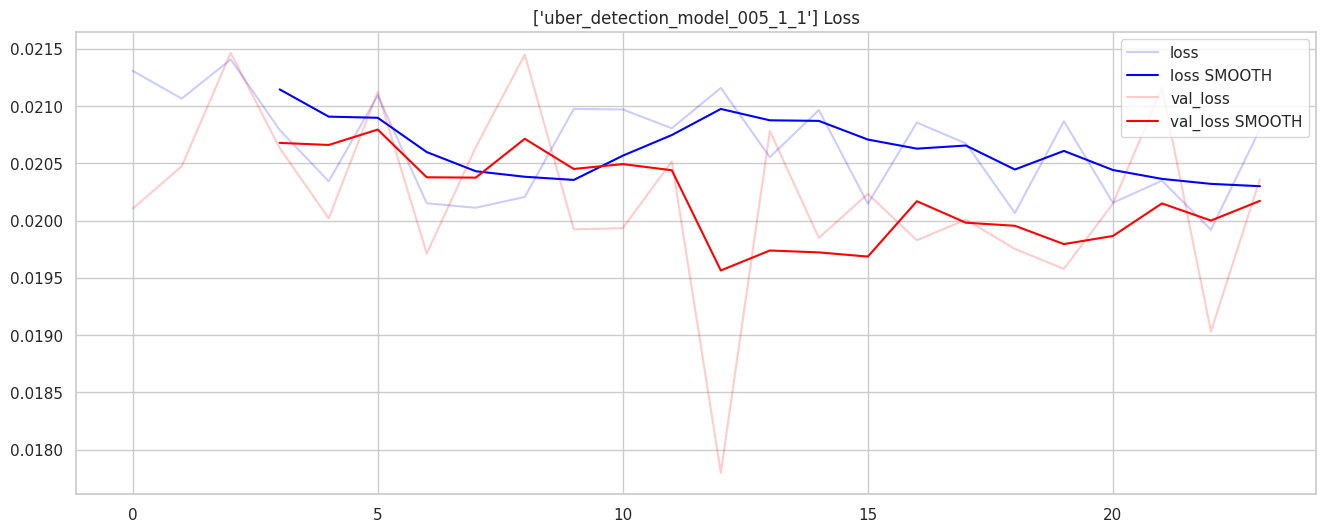

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


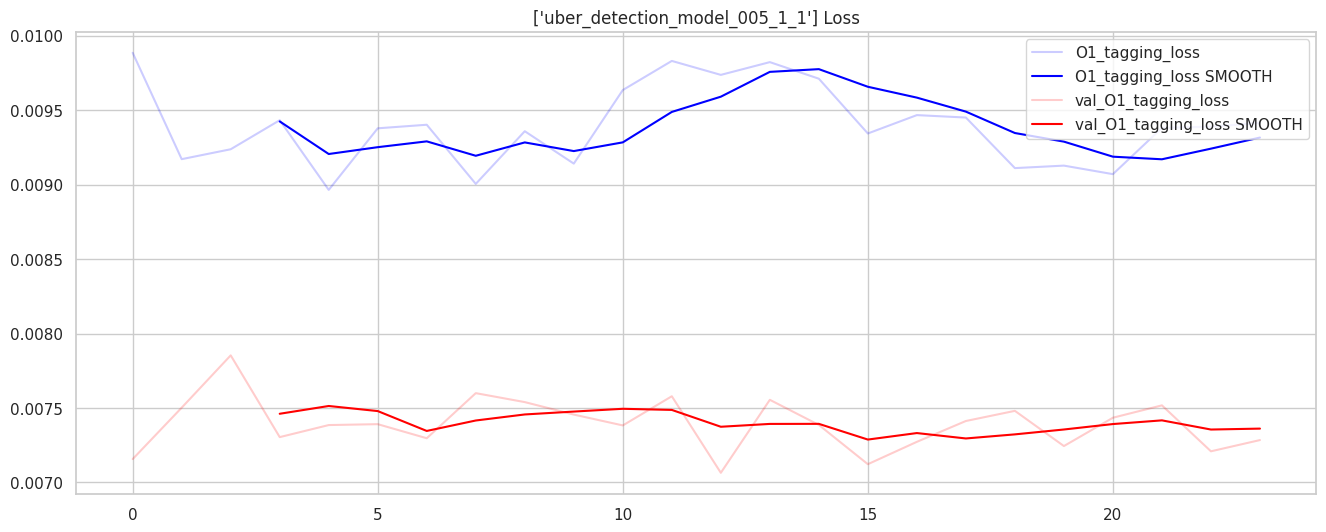

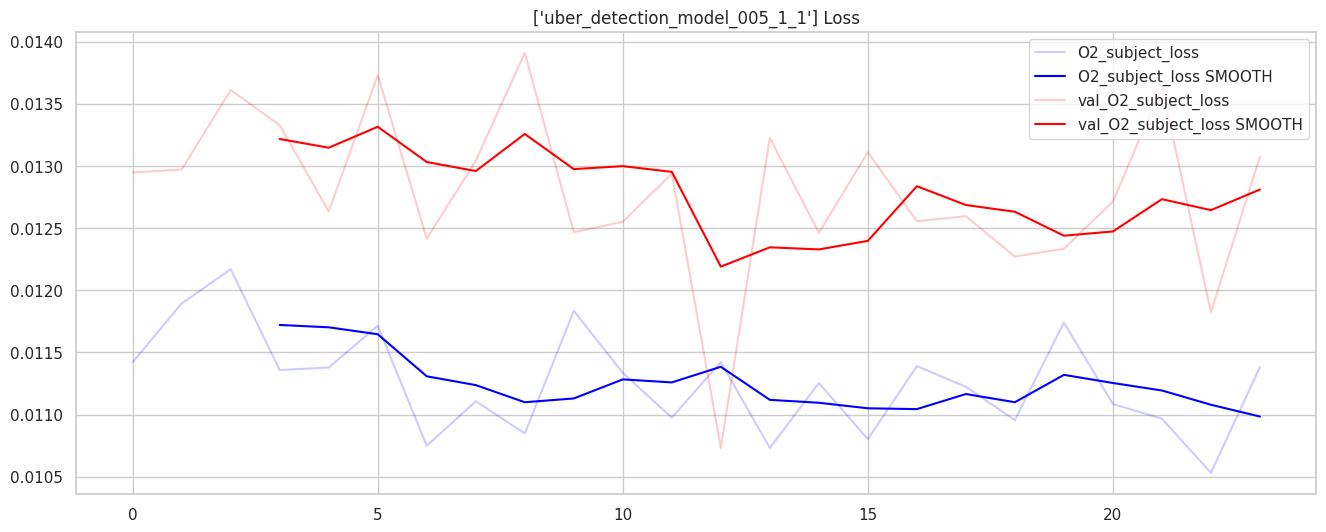

In [46]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [47]:
# umtm.stats
# semantic_map_keys_contract


6391b4771864c6df4d29f332


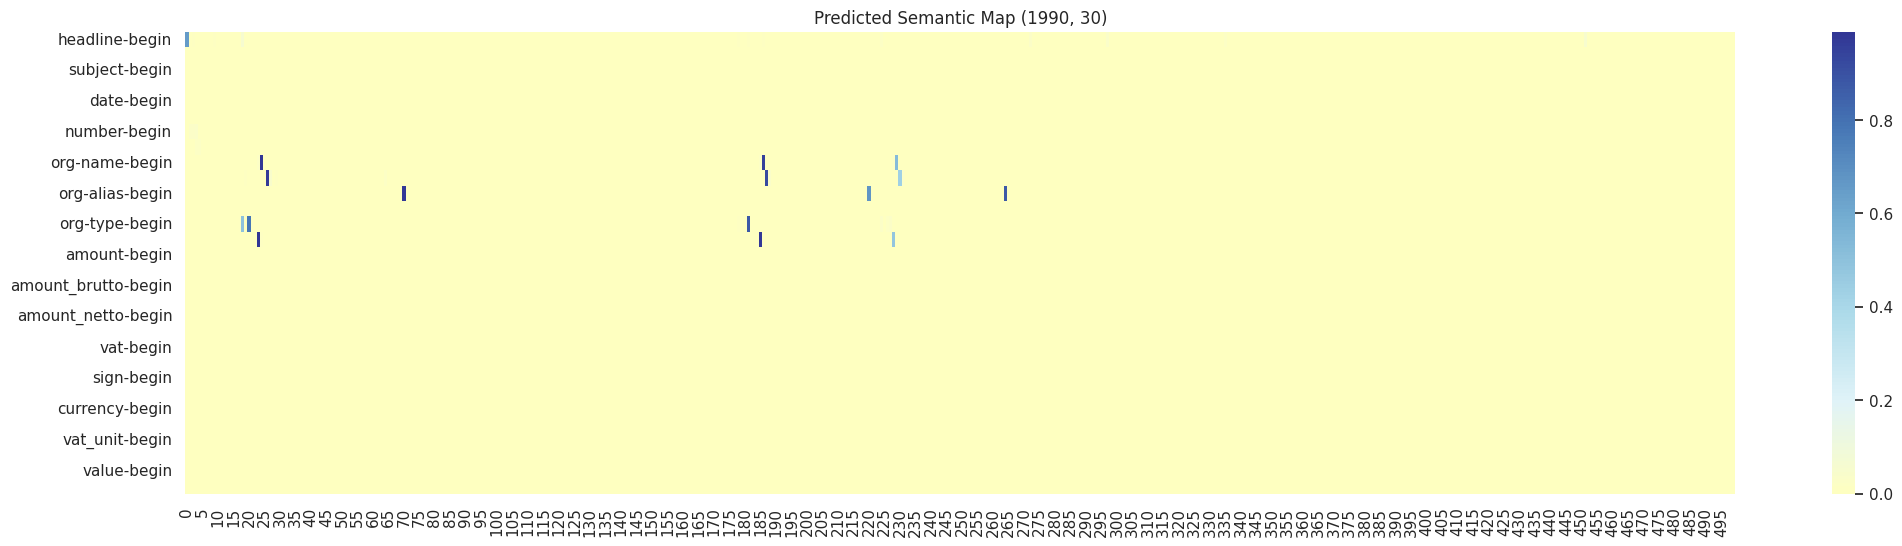

In [48]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [49]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [50]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'